# French Addresses Tokenizer and Analyzer

## Chapter 1 – load disambiguate resources
In many cases, nlp tokenizer classify firstnames as adjectives. To disambiguate, we use two datasets that are used one after another: the list of common French firstnames that have a high priority in odonyms ; the list of French adjectives to help nlp tokenizer classification

### Firstnames
The list of French common firstnames comes from [Liste de prénoms français et de la francophonie](https://fr.wikipedia.org/wiki/Liste_de_pr%C3%A9noms_fran%C3%A7ais_et_de_la_francophonie). The HTML file is analyzed to get the gender and the name in a dictionary.

In [8]:
from bs4 import BeautifulSoup

firstnames = {}
genders = {'féminin':'fem','masculin':'masc'}
with open('dataset-firstnames.html','r') as htmlfp:
    soup = BeautifulSoup(htmlfp,"lxml")
    dds = soup.find_all('dd')
for dd in dds:
    try: 
        firstname = dd.a.text.lower()
        gender = dd.span['title'].split()[-1]
        firstnames[firstname]=genders[gender]
    except:
        pass
print('Analysis successful,',len(firstnames),'found: stored in [firstnames]')

Analysis successful, 889 found: stored in [firstnames]


In [9]:
'rené' in firstnames

True

### Adjectives
Adjectives comes from a relatively large xml file, offline copy of [French wiktionary](https://fr.wiktionary.org/wiki/Aide:Consulter_le_Wiktionnaire_hors-connexion), listing all French adjectives with their possible gender. Gender is then used to disambiguate as they need to remain compatible

```python
from collections import OrderedDict
import mwparserfromhell
from ipywidgets import FloatProgress
from IPython.display import display

adjectives=[]

def isAdjective(page):
    try:
        text = page['revision']['text']['#text']
        wikicode = mwparserfromhell.parse(text)
        
        isFrench = False
        i=0
        for heading in wikicode.filter_headings():
            
            if '{langue|fr}' in heading.title:
                isFrench = True
                i=0
            if '|nom|' in heading.title and isFrench:
                i+=1
            if '|adjectif|' in heading.title and isFrench:
                i+=1
                return page['title'],i
            if 'langue' in heading.title and not '{langue|fr}' in heading.title:
                isFrench = False
    except KeyError:
        return None
    
    return None

def handle_page(_, page):
    result = isAdjective(page)
    if result is not None :
        adjective, priority = result
        global adjectives
        adjectives.append((adjective,priority))
    return True
```

```python
import xmltodict
from bz2 import BZ2File

#f = FloatProgress(min=0, max=35688)
#display(f)
#i = 0

xmltodict.parse(BZ2File('/Users/fabien/Downloads/frwiktionary-latest-pages-articles-multistream.xml.bz2'),item_depth=2, item_callback=handle_page)
print('Analysis successful,',len(adjectives),'found: stored in [adjectives]')
```

```python
import pickle
with open('dataset-adjectives.pkl','wb+') as fp:
    pickle.dump(adjectives, fp)
```

In [10]:
import pickle
with open('dataset-adjectives.pkl','rb') as fp:
    adjectives = pickle.load(fp)
    adj_high_priority = [a for a,p in adjectives if p==1]
    adj_low_priority = [a for a,p in adjectives if p>1]
print('Analysis successful,',len(adjectives),'found: stored in [adjectives]')

Analysis successful, 165611 found: stored in [adjectives]


In [11]:
'neuf' in adj_low_priority

True

### list of military ranks in French Army
Military ranks are often used in the street names. The grades comes from [Grades de l'Armée française](https://fr.wikipedia.org/wiki/Grades_de_l%27Arm%C3%A9e_fran%C3%A7aise)

In [12]:
with open('dataset-grade.txt','r') as fp:
    lines = fp.readlines()
    gds=set()
    for line in lines:
        gds.add(line.strip().lower())
grades = list(gds)
print('Analysis successful,',len(grades),'found: stored in [grades]')

Analysis successful, 32 found: stored in [grades]


## Chapter 2 – Load Odonym Categories & Prepare regular expression matches

Load lemmas from the xls file, prepared by 3 researchers (_Dominique Badariotti, Fabien Pfaender, Jean-Luc Pinol_). 
Each Lemma has a regex, a lemma, and 4 signifier levels from specific to general. 
The XLS is loaded in a DataFrame

In [13]:
import pandas as pd
import re

# read the excel reference file and create a dataframe
dfLemmas = pd.read_excel('france-street-category.DB2.xls',
                   sheet_name='france-street-category',
                   usecols='A:I',
                   names=['raw_regex','lemma','signifier_lvl_0','signifier_lvl_1','signifier_lvl_2','signifier_lvl_3','signifier_common','etymology_language','etymology_region'])

# sort the dataframe
# key: longer regex alphabetically to prioritize larger street names over partial/shorter one (avenue > av.)
dfLemmas = dfLemmas.sort_values(by='raw_regex', ascending=False)

# create a column with the regex precompiled
regexes = []
for index, row in dfLemmas.iterrows():
    regex = re.compile(r'\b'+ row['raw_regex'] + r'\b', re.IGNORECASE | re.DOTALL | re.UNICODE)
    regexes.append(regex)
dfLemmas = dfLemmas.assign(regex=regexes)
print('[Info] first row of the dataframe shall last alphabetical longer one:',dfLemmas.iloc[0]['lemma'])
print(dfLemmas.iloc[0])

[Info] first row of the dataframe shall last alphabetical longer one: zone industrielle
raw_regex                                             zone industrielle
lemma                                                 zone industrielle
signifier_lvl_0                                       zone industrielle
signifier_lvl_1                                                    zone
signifier_lvl_2                                                    zone
signifier_lvl_3                                                     NaN
signifier_common                                                    NaN
etymology_language                                                  NaN
etymology_region                                                    NaN
regex                 re.compile('\\bzone industrielle\\b', re.IGNOR...
Name: 511, dtype: object


In [14]:
# create best candidate function returning candidate index in lemmaDF if found
def bestCandidate(name):
    matches = []
    for index,row in dfLemmas.iterrows():
        match = row['regex'].search(name)
        # if regex match on a name, append row index in dataframe, position and length of the match
        # prioritize over the closer to beginning and longer match
        if match is not None:
            matches.append((index, match.span()[0], match.span()[1]-match.span()[0]))
            print(matches)
    try:
        index,start,length = sorted(matches, key=lambda tup: tup[1],reverse=False)[0]
        return dfLemmas.loc[index]
    except IndexError:
        return None
bestCandidate('rue du moulin')

[(474, 0, 3)]
[(474, 0, 3), (246, 7, 6)]


raw_regex                                                         rues?
lemma                                                               rue
signifier_lvl_0                                                     rue
signifier_lvl_1                                                     rue
signifier_lvl_2                                      voie communication
signifier_lvl_3                                                     NaN
signifier_common                                                    NaN
etymology_language                                                  NaN
etymology_region                                                    NaN
regex                 re.compile('\\brues?\\b', re.IGNORECASE|re.DOT...
Name: 474, dtype: object

## Chapter 3  - Prepare NLP Analysis

possible Part of Speech includes 
+ *ADJ*: adjective
+ *ADP*: determinant
+ *ADV*: adverb
+ *DET*: determinant
+ *PRON*: pronoun
+ *PROPN*: noun proposition
+ *NOUN*: noun
+ *VERB*: verb
+ *PUNCT*: ponctuation

In [15]:
import spacy

nlp = spacy.load('fr')

In [16]:
from collections import OrderedDict
import re 
import pandas as pd
import requests

class Odonym(object):
    def __init__(self,name,lemma,lieuDit):
        self.df = None
        self.name = name
        self.lemma = lemma
        self.original = None
        self.lieuDit = lieuDit
        self.doc = nlp(self.name)
        self.potentialLemma = None
        
        if not self.lieuDit:
            self.setLemmaBoundaries()

        self.setDataFrame()
        
        if self.lieuDit:
            self.searchForPotentialLemma()
            
        else:
            lemmaStart, lemmaEnd, preLemma, postLemma = self.lemma_boundaries
            if preLemma >= 0:
                self.analysePreLemma()
            else:
                self.prelemma_df = None
            if postLemma < len(self.doc):
                self.analysePostLemma()
            else:
                self.specific_df = None
                self.postlemma_df = None
                
                
    def setLemmaBoundaries(self):
        # calculate position of generic in the tokens
        lemma_idx = [t.text for t in self.doc].index('Fffff')
        tailLen = (len(self.doc)-1-lemma_idx)
        pre_lemma_idx = lemma_idx-1
        
        # recreate the original for better nlp analysis
        original = ' '.join([t.text for t in self.doc][:lemma_idx])+' '+self.lemma+' '+' '.join([t.text for t in self.doc][lemma_idx+1:])
        self.original = original.strip()

        # reanalyse nlp original and set boundaries of the lemma
        self.doc = nlp(self.original)
        post_lemma_idx = (len(self.doc)-tailLen)
        self.lemma_boundaries=(lemma_idx,post_lemma_idx-1,pre_lemma_idx,post_lemma_idx)
        
    def setDataFrame(self):
        tokens=[]
        # analyze each token in text and set gender an dnumber if exist
        for token in self.doc:
            #print(token.text, token.pos_, token.tag_, token.lemma_)
            tag = token.tag_.split('__')[1]
            gender=None
            number=None
            if len(tag)>2:
                properties = tag.split('|')
                for p in properties:
                    key,value = p.split('=')
                    if 'Gender' == key:
                        gender = value.lower()
                    if 'Number' == key:
                        number = value.lower()
            tokens.append([token.text,token.pos_,gender,number,token.lemma_])
        # return pandas dataframe
        self.df = pd.DataFrame(data=tokens, columns=['text','position','gender','number','lemma'])
        
    def searchForPotentialLemma(self):
        # potential lemma has two conditions: (1) the "...(de...)?" shape or (2) noun exist in fr wiktionary
        # create a pattern for a potential lemma
        pattern = re.compile(r"(NOUN|PRON)+(ADJ)?((DET|ADP)+([A-Z]+)+)?")
        tokenPos = ''.join(self.df['position'].tolist())
        tokenLen = [len(i) for i in self.df['position'].tolist() ]
        match = pattern.search(tokenPos)
        # if we find the pattern we extract the corresponding lemma
        
        if match is not None:
            position = match.start()
            #print('found potential lemma at position',position,'in',tokenPos)
            for i in range(0,len(tokenLen)):
                if sum(tokenLen[:i])== position:
                    self.lemma = self.df['text'].iloc[i]
                    self.lemmatized = self.df['lemma'].iloc[i]
                    #print('lemma is at position',i,'in dataFrame & lemma is',self.lemma)
            
            # if potential lemma is found, query wiktionary to check if noun exists and get origin
            try:
                url = 'http://fr.wiktionary.org/w/api.php?action=parse&page='+self.lemma+'&prop=sections&format=json'
                r = requests.get(url)
                page = r.json()
                langInPage = {}
                langHasNoun = {}
                for section in page['parse']['sections']:
                    if section['toclevel']==1:
                        langInPage[section['number']]=section['anchor']
                        langHasNoun[section['number']]=False
                    if section['toclevel']==2 and 'Nom' in section['anchor']:
                        langHasNoun[section['number'].split('.')[0]]=True
                languages = ([langInPage[i] for i in langInPage.keys() if i in langHasNoun.keys()])
            except:
                languages = None
            self.potentialLemma = (self.lemma, languages, self.lemmatized)
    
    def analysePreLemma(self):
        lemmaStart, lemmaEnd, preLemma, postLemma = self.lemma_boundaries
        
        # if the token just before the generic is a noun it might as well a adjective 
        if self.df['position'].loc[preLemma] == 'NOUN':
            t, p, g, n, l = self.df.loc[preLemma]
            if l in adj_high_priority:
                self.df.at[preLemma] = [t,'ADJ',g,n,l]
        self.prelemma_df = self.df.loc[:preLemma]#.to_json(orient='records')self.prelemma_df = self.prelemma_df[self.prelemma_d.position != 'PUNCT']
        self.prelemma_df = self.prelemma_df[self.prelemma_df.position != 'PUNCT']
        #print('[INFO] pre lemma',self.prelemma_df)
        
    def analysePostLemma(self):
        lemmaStart, lemmaEnd, preLemma, postLemma = self.lemma_boundaries
        # SPECIAL if the first position after lemma is an ADJ there might be a mistake
        i = postLemma
        pos = self.df['position'].loc[i]
        dfLen = len(self.df)
        #print(self.df['position'])
        while pos in ['PUNCT','DET','AUX','ADJ','CCONJ','NOUN','VERB','PROPN','ADP']:
            
            if pos not in ['ADJ','DET','AUX','NOUN','VERB','PROPN','ADP']:
                # verify 
                if i+1 < dfLen:
                    i += 1
                    pos = self.df['position'].loc[i]
                    continue
                else:
                    break
                    
            t, p, g, n, l = self.df.loc[i]
            
            if t in ['d','du','des']:
                if pos != 'DET':
                    self.df.at[i] = [t,'DET',g,n,'un']
                    break
                else:
                    break
                
            #print(pos,t, p, g, n, l )
            if pos == 'ADJ':        
                # 1 - If adjective is mistaken for a firstname (more common in street name): reset adjective
                if t in firstnames.keys() and i+1 < dfLen :
                    self.df.at[i] = [t,'NOUN',firstnames[t],'sing',t]
                    break
                    
                # 2 - If adjective is mistaken for a grade (more common in street name): reset adjective
                elif l in grades and i+1 < dfLen:
                    self.df.at[i] = [t,'NOUN',g,n,l]
                    break
                    
                # 3 - If Adjective lemma is not in the list of french adjectives top priority, it is unlikely it is one. 
                elif l not in adj_high_priority:
                    self.df.at[i] = [t,'NOUN',g,n,l]
                    break
                    
                else: 
                    if i+1 < dfLen:
                        i += 1
                        pos = self.df['position'].loc[i]
                    else:
                        break
                        
            elif pos in ['NOUN','VERB', 'AUX','PROPN','DET','ADP']:
                # if NOUN or VERB or AUX or DET : CAN BE AN ADJ IF ADJ TOP PRIORITY
                
                if l in adj_high_priority:
                    self.df.at[i] = [t,'ADJ',g,n,l]
                    
                elif l in adj_low_priority and i+1 == dfLen and self.df['position'].loc[i-1] != 'DET' :
                    self.df.at[i] = [t,'ADJ',g,n,l]
                    i += 1
                    break
                    
                elif t in firstnames.keys() and pos != 'NOUN' and i+1 < dfLen:
                    self.df.at[i] = [t,'NOUN',firstnames[t],'sing',t]
                    #print('found first name not in ADJ',t, i)
                    break
                elif t in firstnames.keys() and pos == 'NOUN':
                    break
            if i+1 < dfLen:
                i += 1
                pos = self.df['position'].loc[i]
            else:
                break
            
        specific_df = self.df.loc[i:]
        if not specific_df.empty :
            specific_filtered_list = specific_df.loc[~specific_df['position'].isin(['DET'])].index.tolist()
            # if it is an empty list, there is no specific, we don't filter as it is unlikely that a street ends with a DET POS
            if len(specific_filtered_list) == 0:
                filtered_i = i
            else:
                filtered_i = specific_filtered_list[0]
            #print(specific)
            self.specific_df = self.df.loc[filtered_i:]
            #print(self.specific_df)
            self.postlemma_df = self.df.loc[postLemma:filtered_i-1]
            #print(self.postlemma_df)
            self.specific_df = self.specific_df[self.specific_df.position != 'PUNCT']
            self.postlemma_df = self.postlemma_df[self.postlemma_df.position != 'PUNCT']
        else:
            self.specific_df = self.df.loc[i:]
            self.postlemma_df = self.df.loc[postLemma:i]
        
            self.specific_df = self.specific_df[self.specific_df.position != 'PUNCT']
            self.postlemma_df = self.postlemma_df[self.postlemma_df.position != 'PUNCT']
        
        #print('[INFO] post lemma', self.postlemma_df)
        #print('[INFO] specific', self.specific_df)
    
    def getDataFrames(self):
        if self.lieuDit:
            return self.df, self.potentialLemma
        else:
            return self.prelemma_df, self.postlemma_df, self.specific_df

#odonym = Odonym('Fffff neuf','moulin',False)
#odonym = Odonym('le Fffff neuf','moulin',False)
odonym = Odonym('Fffff jacques ségélat','rue',False)

#odonym = Odonym('la Fffff du général','rue',False)
#odonym = Odonym('Fffff rené laennec','place',False)
#analyzeOdonym("à gauche de la belle Fffff rouge des chats qui pètent les ballons",'grande rue',15)
#analyzeOdonym('maréchal delattre Fffff','ruette',0,True)

In [17]:
streets = ['à gauche de la grande rue de grande rue chats qui pètent les ballons']
streets.append('ldt la trouée qui gratte')
streets.append('le moulin neuf')
streets.append('la rue générale')
streets.append('la rue du général')
streets.append('place rené laennec')
streets.append('3 bis les basses rues des thés')
streets.append('première col. d\'altus')
streets.append('les vieux tunnels du chien qui broute')
streets.append('grand-rue de la grande perrière')
streets.append('montée neuve d\'australie')

In [18]:
import os
from os.path import join
import numpy as np
types = {'nom_voie':str,'numero':np.int32,'code_insee':str,'code_post':str,'nom_ld':str,'x':np.float64,'y':np.float64,'lon':np.float64,'lat':np.float64,'nom_commune':str} 
for root, dirs, files in os.walk('/Users/fabien/Downloads/BAN_licence_gratuite_repartage/'):
    for name in files:
        if name.endswith('csv'):
            bandf = pd.read_csv(join(root,name),sep=';', usecols=list(types.keys()),dtype=types)
        break
        

print(bandf.iloc[0])
        # copy all nom_ld in Nomvoie si nom_voie est vide et nom_ld ne l'es pas
bandf['nom_voie'] = bandf.apply(
    lambda row: row['nom_ld'].lower() if row['nom_voie'] is np.NAN else row['nom_voie'],
    axis=1
)

potentials= []
ban = []
for (city,street), group in bandf.groupby(['nom_commune','nom_voie']):
    numbers = group[['numero','x','y','lon','lat']].to_json(orient='records')
    record = {"nom_commune":city,"code_insee":group['code_insee'].iloc[0],"code_post":group['code_post'].iloc[0],"nom_voie":street, 'numero':numbers}
    lemma_row = bestCandidate(street)
    
    if lemma_row is not None:
        print(city,', ',street,', ',lemma_row['lemma'])
        street = lemma_row['regex'].sub('Fffff', street,1)
        #print(city,', ',street,', ',lemma_row['lemma'])
        if 'Fffff\'' in street:
            street = street.replace('Fffff\'','Fffff ')
        #print(city,', ',street,', ',lemma_row['lemma'])
        odonym = Odonym(street,lemma_row['lemma'],False)
        prelemma, postlemma, specific = odonym.getDataFrames()
        record['prelemma'] = prelemma.to_dict(orient='records') if prelemma is not None else None
        record['postlemma'] = postlemma.to_dict(orient='records') if postlemma is not None else None
        record['specific'] = specific.to_dict(orient='records') if specific is not None else None
        record.update(lemma_row.to_dict())
    else:
        if street.startswith('ldt'):
            street = street[4:]
        elif street.startswith('lieu dit'):
            street = street[8:]
        odonym = Odonym(street,None,True)
        specific, potential = odonym.getDataFrames()
        lieudit = {'raw_regex':'','lemma':'lieu dit','signifier_lvl_0':'lieu dit','signifier_lvl_1':'lieu dit','signifier_lvl_2':'voie communication','signifier_lvl_3':None,'signifier_common':'oui','etymology_language':'fr','etymology_region':'France'}

        if potential is not None:
            generic, languages, lemma = potential
            if generic != 'ldt' and generic !='lieu dit':
                potentials.append({'generic':generic,'languages':languages,'lemma':lemma, 'street':street})
            
        record['prelemma'] = None
        record['postlemma'] = None
        record['specific'] = specific.to_dict(orient='records') if specific is not None else None
        record.update(lieudit)
    ban.append(record)    
bandf2 = pd.DataFrame.from_records(ban)
bandf2potentials = pd.DataFrame.from_records(potentials)

nom_voie               NaN
numero                   1
code_insee           29001
code_post            29560
nom_ld           LE MOULIN
x                   157707
y              6.81945e+06
lon               -4.31614
lat                48.2491
nom_commune          Argol
Name: 0, dtype: object
[(370, 0, 5)]
Argol ,  allée des noisetiers ,  allée
[(35, 0, 7)]
Argol ,  garenne urben ,  garenne
[(199, 3, 8)]
Argol ,  la fontaine blanche ,  fontaine
[(106, 3, 7)]
Argol ,  le chateau d eau ,  château
[(246, 3, 6)]
Argol ,  le moulin ,  moulin
[(131, 3, 4)]
Argol ,  le pont lanvily ,  pont
[(160, 0, 11)]
Argol ,  lotissement ar feunteun ,  lotissement
[(160, 0, 11)]
[(160, 0, 11), (515, 15, 3)]
Argol ,  lotissement de ker ys ,  lotissement
[(160, 0, 11)]
Argol ,  lotissement goarem vanel ,  lotissement
[(246, 0, 6)]
Argol ,  moulin d'argol ,  moulin
[(246, 0, 6)]
Argol ,  moulin de cameros ,  moulin
[(246, 0, 6)]
Argol ,  moulin neuf ,  moulin
[(60, 7, 4)]
Argol ,  pen ar prat ,  prat
[(170, 0

[(170, 0, 5)]
[(170, 0, 5), (299, 22, 5)]
Audierne ,  place chevalier de la barre ,  place
[(170, 0, 5)]
Audierne ,  place de l'embarcadère ,  place
[(170, 0, 5)]
Audierne ,  place de l'océan ,  place
[(170, 0, 5)]
[(170, 0, 5), (123, 11, 6)]
Audierne ,  place de l'église ,  place
[(170, 0, 5)]
Audierne ,  place de la liberte (audierne) ,  place
[(170, 0, 5)]
Audierne ,  place de la république ,  place
[(170, 0, 5)]
Audierne ,  place de la résistance ,  place
[(170, 0, 5)]
[(170, 0, 5), (39, 10, 6)]
Audierne ,  place des halles ,  place
[(170, 0, 5)]
Audierne ,  place du gannaeg ,  place
[(170, 0, 5)]
Audierne ,  place du général de gaulle ,  place
[(170, 0, 5)]
Audierne ,  place jean keravec ,  place
[(170, 0, 5)]
Audierne ,  place leon gambetta ,  place
[(170, 0, 5)]
Audierne ,  place rené laennec ,  place
[(131, 0, 4)]
Audierne ,  pont prenn ,  pont
[(225, 0, 4)]
Audierne ,  quai anatole france ,  quai
[(225, 0, 4)]
Audierne ,  quai camille pelletan ,  quai
[(225, 0, 4)]
Audierne , 

[(474, 0, 3)]
Audierne ,  rue rameau ,  rue
[(474, 0, 3)]
Audierne ,  rue raymond couillandre ,  rue
[(474, 0, 3)]
Audierne ,  rue raymond stephan ,  rue
[(474, 0, 3)]
Audierne ,  rue renoir ,  rue
[(474, 0, 3)]
Audierne ,  rue rené autret ,  rue
[(474, 0, 3)]
Audierne ,  rue roz an dour ,  rue
[(474, 0, 3)]
Audierne ,  rue saint-saëns ,  rue
[(474, 0, 3)]
Audierne ,  rue stalingrad ,  rue
[(474, 0, 3)]
Audierne ,  rue surcouf-esquibien ,  rue
[(474, 0, 3)]
Audierne ,  rue tal ar groaz ,  rue
[(474, 0, 3)]
Audierne ,  rue théodore botrel ,  rue
[(479, 4, 8)]
[(479, 4, 8), (474, 0, 3)]
Audierne ,  rue traverse ,  rue
[(474, 0, 3)]
Audierne ,  rue van parys ,  rue
[(474, 0, 3)]
Audierne ,  rue victor hugo ,  rue
[(474, 0, 3)]
Audierne ,  rue voltaire ,  rue
[(474, 0, 3)]
Audierne ,  rue waldeck rousseau ,  rue
[(474, 0, 3)]
Audierne ,  rue yves jade ,  rue
[(474, 0, 3)]
[(474, 0, 3), (312, 10, 6)]
Audierne ,  rue émile combes ,  rue
[(474, 0, 3)]
Audierne ,  rue émile zola ,  rue
[(172, 

[(474, 0, 3), (164, 7, 6)]
Bannalec ,  rue du manoir ,  rue
[(474, 0, 3)]
[(474, 0, 3), (246, 7, 6)]
Bannalec ,  rue du moulin rozhuel ,  rue
[(474, 0, 3)]
Bannalec ,  rue du onze novembre 1918 ,  rue
[(474, 0, 3)]
[(474, 0, 3), (223, 7, 5)]
Bannalec ,  rue du puits ,  rue
[(474, 0, 3)]
Bannalec ,  rue du trévoux ,  rue
[(474, 0, 3)]
Bannalec ,  rue eugène cadic ,  rue
[(474, 0, 3)]
Bannalec ,  rue eugène lorec ,  rue
[(474, 0, 3)]
Bannalec ,  rue glenmor ,  rue
[(474, 0, 3)]
Bannalec ,  rue isidore colas ,  rue
[(474, 0, 3)]
Bannalec ,  rue jean jaurès ,  rue
[(474, 0, 3)]
[(474, 0, 3), (246, 9, 6)]
Bannalec ,  rue jean moulin ,  rue
[(474, 0, 3)]
Bannalec ,  rue joseph cotonnec ,  rue
[(474, 0, 3)]
Bannalec ,  rue jules ferry ,  rue
[(474, 0, 3)]
Bannalec ,  rue louise michel ,  rue
[(474, 0, 3)]
Bannalec ,  rue men guen ,  rue
[(474, 0, 3)]
Bannalec ,  rue michel yvonnou ,  rue
[(474, 0, 3)]
Bannalec ,  rue nationale ,  rue
[(474, 0, 3)]
Bannalec ,  rue pierre jakez helias ,  rue
[(

Beuzec-Cap-Sizun ,  rue des ajoncs ,  rue
[(474, 0, 3)]
[(474, 0, 3), (262, 8, 8)]
Beuzec-Cap-Sizun ,  rue des bruyères ,  rue
[(474, 0, 3)]
Beuzec-Cap-Sizun ,  rue du cordonnier ,  rue
[(474, 0, 3)]
Beuzec-Cap-Sizun ,  rue du garde françois cotonea ,  rue
[(253, 7, 5)]
[(253, 7, 5), (474, 0, 3)]
Beuzec-Cap-Sizun ,  rue du stade ,  rue
[(474, 0, 3)]
Beuzec-Cap-Sizun ,  rue henri matisse ,  rue
[(474, 0, 3)]
[(474, 0, 3), (515, 10, 3)]
Beuzec-Cap-Sizun ,  rue kreiz ker ,  rue
[(370, 0, 5)]
Bodilis ,  allée des calvaires ,  allée
[(515, 7, 3)]
Bodilis ,  gueled ker ,  ker
[(151, 0, 6)]
Bodilis ,  hameau de kerandivez ,  hameau
[(151, 0, 6)]
[(151, 0, 6), (121, 13, 5)]
Bodilis ,  hameau de la croix des maltôtiers ,  hameau
[(151, 0, 6)]
Bodilis ,  hameau de messiou ar guerent ,  hameau
[(151, 0, 6)]
[(151, 0, 6), (76, 13, 9)]
Bodilis ,  hameau des 4 barrières ,  hameau
[(151, 0, 6)]
Bodilis ,  hameau du canardic ,  hameau
[(437, 0, 7)]
[(437, 0, 7), (35, 14, 7)]
Bodilis ,  impasse de la g

[(268, 3, 5)]
[(268, 3, 5), (269, 3, 5)]
Bolazec ,  la foret ,  forêt
[(246, 0, 6)]
Bolazec ,  moulin hilvern ,  moulin
[(170, 0, 5)]
Bolazec ,  place du 19 mars 1962 ,  place
[(469, 0, 5)]
Bolazec ,  route d'huelgoat ,  route
[(469, 0, 5)]
Bolazec ,  route de callac ,  route
[(469, 0, 5)]
Bolazec ,  route de morlaix ,  route
[(474, 0, 3)]
[(474, 0, 3), (199, 10, 8)]
Bolazec ,  rue de la fontaine ,  rue
[(140, 0, 5)]
Botmeur ,  bourg ,  bourg
[(121, 0, 5)]
Botmeur ,  croix cassée ,  croix
[(91, 3, 8)]
Botmeur ,  la métairie ,  métairie
[(356, 0, 3)]
Botmeur ,  roc'h ar c'hezec ,  roc
[(515, 0, 3)]
Botsorhel ,  ker ar groas ,  ker
[(271, 3, 4)]
Botsorhel ,  la haie ,  haie
[(160, 0, 11)]
Botsorhel ,  lotissement de bel-air I ,  lotissement
[(160, 0, 11)]
Botsorhel ,  lotissement de bel-air II ,  lotissement
[(160, 0, 11)]
Botsorhel ,  lotissement de kerzouezou ,  lotissement
[(246, 0, 6)]
Botsorhel ,  moulin de kergariou ,  moulin
[(131, 10, 4)]
[(131, 10, 4), (246, 0, 6)]
Botsorhel ,  

[(474, 0, 3), (199, 10, 8)]
Brasparts ,  rue de la fontaine ,  rue
[(474, 0, 3)]
Brasparts ,  rue de la mairie ,  rue
[(474, 0, 3)]
Brasparts ,  rue des patriotes ,  rue
[(474, 0, 3)]
[(474, 0, 3), (106, 7, 7)]
Brasparts ,  rue du château d'eau ,  rue
[(474, 0, 3)]
Brasparts ,  rue françois joncour ,  rue
[(474, 0, 3)]
Brasparts ,  rue frédéric le guyader ,  rue
[(474, 0, 3)]
Brasparts ,  rue saint-michel ,  rue
[(356, 6, 3)]
Brasparts ,  ti ar roc'hellou ,  roc
[(118, 0, 4)]
Brennilis ,  cité an hent koz ,  cité
[(515, 5, 3)]
[(515, 5, 3), (118, 0, 4)]
Brennilis ,  cité ker ellez ,  cité
[(356, 0, 3)]
Brennilis ,  roc'h ar had ,  roc
[(469, 0, 5)]
Brennilis ,  route de kermorvan ,  route
[(469, 0, 5)]
Brennilis ,  route de la centrale ,  route
[(474, 0, 3)]
[(474, 0, 3), (128, 10, 4)]
Brennilis ,  rue de la gare ,  rue
[(474, 0, 3)]
[(474, 0, 3), (140, 7, 5)]
Brennilis ,  rue du bourg ,  rue
[(370, 0, 5)]
Brest ,  allée de broceliande ,  allée
[(515, 9, 3)]
[(515, 9, 3), (370, 0, 5)]


[(141, 8, 4)]
Brest ,  kergoel caer ,  caer
[(474, 7, 3)]
[(474, 7, 3), (123, 16, 6)]
Brest ,  petite rue de l'église ,  rue
[(474, 7, 3)]
Brest ,  petite rue vauban ,  rue
[(170, 0, 5)]
Brest ,  place albert 1er ,  place
[(170, 0, 5)]
Brest ,  place capitaine guynemer ,  place
[(170, 0, 5)]
Brest ,  place de la liberté ,  place
[(170, 0, 5)]
Brest ,  place de metz ,  place
[(170, 0, 5)]
Brest ,  place de penhelen ,  place
[(60, 9, 4)]
[(60, 9, 4), (170, 0, 5)]
Brest ,  place de prat ledan ,  place
[(170, 0, 5)]
Brest ,  place de quilbignon ,  place
[(170, 0, 5)]
Brest ,  place de roscanvel ,  place
[(170, 0, 5)]
Brest ,  place de strasbourg ,  place
[(170, 0, 5)]
Brest ,  place des canneurs ,  place
[(170, 0, 5)]
Brest ,  place des delisseurs ,  place
[(170, 0, 5)]
Brest ,  place des ffi ,  place
[(170, 0, 5)]
Brest ,  place des francs-tireurs et partisans français ,  place
[(170, 0, 5)]
Brest ,  place des gargots ,  place
[(170, 0, 5)]
Brest ,  place du 19e régiment d'infanterie ,  p

Brest ,  rue anne selle ,  rue
[(474, 0, 3)]
Brest ,  rue antoine laurent de jussieu ,  rue
[(474, 0, 3)]
Brest ,  rue antoine raby ,  rue
[(474, 0, 3)]
Brest ,  rue antoine vitez ,  rue
[(474, 0, 3)]
Brest ,  rue ar feunteun ,  rue
[(474, 0, 3)]
Brest ,  rue arago ,  rue
[(474, 0, 3)]
[(474, 0, 3), (186, 13, 6)]
Brest ,  rue aristide berges ,  rue
[(474, 0, 3)]
Brest ,  rue aristide briand ,  rue
[(474, 0, 3)]
Brest ,  rue arletty ,  rue
[(474, 0, 3)]
Brest ,  rue armand keravel ,  rue
[(474, 0, 3)]
Brest ,  rue armand robin ,  rue
[(474, 0, 3)]
Brest ,  rue armand rousseau ,  rue
[(474, 0, 3)]
Brest ,  rue armor ,  rue
[(474, 0, 3)]
Brest ,  rue armorique ,  rue
[(474, 0, 3)]
Brest ,  rue arthur hendrycks ,  rue
[(474, 0, 3)]
Brest ,  rue arthur honegger ,  rue
[(474, 0, 3)]
Brest ,  rue arthur rimbaud ,  rue
[(474, 0, 3)]
Brest ,  rue arvor ,  rue
[(474, 0, 3)]
Brest ,  rue auguste antoine thomazi ,  rue
[(474, 0, 3)]
Brest ,  rue auguste bergot ,  rue
[(474, 0, 3)]
Brest ,  rue aug

[(474, 0, 3)]
Brest ,  rue comtesse de noailles ,  rue
[(474, 0, 3)]
Brest ,  rue comtesse de ségur ,  rue
[(474, 0, 3)]
Brest ,  rue condillac ,  rue
[(474, 0, 3)]
Brest ,  rue condorcet ,  rue
[(474, 0, 3)]
Brest ,  rue conseil ,  rue
[(474, 0, 3)]
Brest ,  rue constant roudaut ,  rue
[(474, 0, 3)]
[(474, 0, 3), (143, 13, 5)]
Brest ,  rue corentin carré ,  rue
[(474, 0, 3)]
Brest ,  rue corneille ,  rue
[(474, 0, 3)]
Brest ,  rue corot ,  rue
[(474, 0, 3)]
Brest ,  rue cosmao dumanoir ,  rue
[(474, 0, 3)]
Brest ,  rue cosmao pretot ,  rue
[(474, 0, 3)]
Brest ,  rue cronstadt ,  rue
[(474, 0, 3)]
Brest ,  rue cruguel ,  rue
[(474, 0, 3)]
Brest ,  rue cuirasse bretagne ,  rue
[(474, 0, 3)]
Brest ,  rue célestin freinet ,  rue
[(474, 0, 3)]
Brest ,  rue césar franck ,  rue
[(474, 0, 3)]
Brest ,  rue d'aboville ,  rue
[(474, 0, 3)]
Brest ,  rue d'aiguillon ,  rue
[(474, 0, 3)]
Brest ,  rue d'alembert ,  rue
[(474, 0, 3)]
Brest ,  rue d'algérie ,  rue
[(474, 0, 3)]
Brest ,  rue d'anjou , 

[(474, 0, 3)]
[(474, 0, 3), (346, 10, 6)]
Brest ,  rue de la pointe ,  rue
[(474, 0, 3)]
[(474, 0, 3), (94, 10, 5)]
Brest ,  rue de la porte ,  rue
[(474, 0, 3)]
[(474, 0, 3), (94, 10, 5)]
Brest ,  rue de la porte rouge ,  rue
[(474, 0, 3)]
Brest ,  rue de la république ,  rue
[(474, 0, 3)]
Brest ,  rue de la résistance ,  rue
[(474, 0, 3)]
Brest ,  rue de la réunion ,  rue
[(474, 0, 3)]
Brest ,  rue de la sarthe ,  rue
[(474, 0, 3)]
Brest ,  rue de la savoie ,  rue
[(474, 0, 3)]
Brest ,  rue de la somme ,  rue
[(474, 0, 3)]
Brest ,  rue de la source ,  rue
[(139, 10, 4)]
[(139, 10, 4), (474, 0, 3)]
Brest ,  rue de la tour ,  rue
[(179, 10, 5)]
[(179, 10, 5), (474, 0, 3)]
Brest ,  rue de la ville d'ys ,  rue
[(474, 0, 3)]
Brest ,  rue de la villemarque ,  rue
[(474, 0, 3)]
Brest ,  rue de la villeneuve ,  rue
[(474, 0, 3)]
Brest ,  rue de landévennec ,  rue
[(474, 0, 3)]
Brest ,  rue de lanninguer ,  rue
[(474, 0, 3)]
Brest ,  rue de lannion ,  rue
[(474, 0, 3)]
Brest ,  rue de lanvian

Brest ,  rue du bot ,  rue
[(474, 0, 3)]
Brest ,  rue du bouguen ,  rue
[(474, 0, 3)]
Brest ,  rue du bourbonnais ,  rue
[(474, 0, 3)]
Brest ,  rue du brigadier le cann ,  rue
[(474, 0, 3)]
Brest ,  rue du béarn ,  rue
[(474, 0, 3)]
Brest ,  rue du calvaire ,  rue
[(474, 0, 3)]
[(474, 0, 3), (305, 7, 3)]
Brest ,  rue du cap de bonne espérance ,  rue
[(474, 0, 3)]
[(474, 0, 3), (305, 7, 3)]
Brest ,  rue du cap finisterre ,  rue
[(474, 0, 3)]
[(474, 0, 3), (305, 7, 3)]
Brest ,  rue du cap horn ,  rue
[(474, 0, 3)]
Brest ,  rue du capitaine de vaisseau pierre renon ,  rue
[(474, 0, 3)]
Brest ,  rue du capitaine ferdinand ferber ,  rue
[(474, 0, 3)]
Brest ,  rue du capitaine guynemer ,  rue
[(474, 0, 3)]
Brest ,  rue du cardinal lavigerie ,  rue
[(474, 0, 3)]
Brest ,  rue du caro ,  rue
[(474, 0, 3)]
Brest ,  rue du carpon ,  rue
[(474, 0, 3)]
Brest ,  rue du chanoine saluden ,  rue
[(474, 0, 3)]
Brest ,  rue du chevalier d'assas ,  rue
[(474, 0, 3)]
[(474, 0, 3), (106, 7, 7)]
Brest ,  rue

[(474, 0, 3)]
Brest ,  rue faraday ,  rue
[(474, 0, 3)]
Brest ,  rue farigoul ,  rue
[(474, 0, 3)]
Brest ,  rue fautras ,  rue
[(474, 0, 3)]
Brest ,  rue federico garcia lorca ,  rue
[(474, 0, 3)]
Brest ,  rue ferdinand brunetière ,  rue
[(474, 0, 3)]
Brest ,  rue ferdinand de lesseps ,  rue
[(474, 0, 3)]
Brest ,  rue fernand widal ,  rue
[(474, 0, 3)]
Brest ,  rue fernandel ,  rue
[(474, 0, 3)]
Brest ,  rue florent schmitt ,  rue
[(474, 0, 3)]
Brest ,  rue florian ,  rue
[(474, 0, 3)]
Brest ,  rue fonck ,  rue
[(474, 0, 3)]
[(474, 0, 3), (199, 4, 8)]
Brest ,  rue fontaine margot ,  rue
[(474, 0, 3)]
Brest ,  rue fontenelle ,  rue
[(474, 0, 3)]
Brest ,  rue forestou creis ,  rue
[(474, 0, 3)]
Brest ,  rue foy ,  rue
[(474, 0, 3)]
Brest ,  rue fragonard ,  rue
[(474, 0, 3)]
Brest ,  rue france combattante ,  rue
[(474, 0, 3)]
Brest ,  rue francis garnier ,  rue
[(474, 0, 3)]
Brest ,  rue francis jammes ,  rue
[(474, 0, 3)]
Brest ,  rue francis poulenc ,  rue
[(474, 0, 3)]
Brest ,  rue f

Brest ,  rue henri moissan ,  rue
[(474, 0, 3)]
Brest ,  rue henri moreau ,  rue
[(474, 0, 3)]
Brest ,  rue henri poincaré ,  rue
[(474, 0, 3)]
Brest ,  rue henri queffelec ,  rue
[(474, 0, 3)]
Brest ,  rue henri salaun ,  rue
[(474, 0, 3)]
Brest ,  rue henri waquet ,  rue
[(474, 0, 3)]
Brest ,  rue henry bataille ,  rue
[(474, 0, 3)]
Brest ,  rue henry bordeaux ,  rue
[(474, 0, 3)]
Brest ,  rue henry de monfreid ,  rue
[(474, 0, 3)]
Brest ,  rue henry de montherlant ,  rue
[(474, 0, 3)]
Brest ,  rue herry léon ,  rue
[(474, 0, 3)]
Brest ,  rue hervé branellec ,  rue
[(474, 0, 3)]
Brest ,  rue hippolyte masson ,  rue
[(474, 0, 3)]
Brest ,  rue hippolyte violeau ,  rue
[(474, 0, 3)]
Brest ,  rue hms warspite ,  rue
[(474, 0, 3)]
Brest ,  rue hoche ,  rue
[(474, 0, 3)]
Brest ,  rue honoré de balzac ,  rue
[(474, 0, 3)]
Brest ,  rue hubertine auclert ,  rue
[(474, 0, 3)]
Brest ,  rue hundertwasser ,  rue
[(474, 0, 3)]
Brest ,  rue huon de kermadec ,  rue
[(474, 0, 3)]
Brest ,  rue huysman

Brest ,  rue lars ,  rue
[(474, 0, 3)]
Brest ,  rue latouche tréville ,  rue
[(474, 0, 3)]
Brest ,  rue laurent legendre ,  rue
[(474, 0, 3)]
Brest ,  rue lavoisier ,  rue
[(474, 0, 3)]
Brest ,  rue lazare carnot ,  rue
[(474, 0, 3)]
Brest ,  rue le gonidec ,  rue
[(474, 0, 3)]
Brest ,  rue le gréco ,  rue
[(474, 0, 3)]
Brest ,  rue le guennec ,  rue
[(474, 0, 3)]
Brest ,  rue le minihy ,  rue
[(474, 0, 3)]
Brest ,  rue le moyne de laborderie ,  rue
[(474, 0, 3)]
Brest ,  rue le titien ,  rue
[(474, 0, 3)]
Brest ,  rue le verrier ,  rue
[(474, 0, 3)]
[(474, 0, 3), (215, 17, 4)]
Brest ,  rue leconte de l'isle ,  rue
[(474, 0, 3)]
Brest ,  rue leonor fini ,  rue
[(474, 0, 3)]
Brest ,  rue lesage ,  rue
[(474, 0, 3)]
Brest ,  rue levot ,  rue
[(474, 0, 3)]
Brest ,  rue lieutenant colonel flatters ,  rue
[(474, 0, 3)]
Brest ,  rue lino ventura ,  rue
[(474, 0, 3)]
Brest ,  rue littré ,  rue
[(474, 0, 3)]
Brest ,  rue lord byron ,  rue
[(474, 0, 3)]
Brest ,  rue lore ,  rue
[(474, 0, 3)]
Br

[(474, 0, 3)]
Brest ,  rue palestrina ,  rue
[(474, 0, 3)]
Brest ,  rue parmentier ,  rue
[(474, 0, 3)]
Brest ,  rue pascal ,  rue
[(474, 0, 3)]
Brest ,  rue paul bert ,  rue
[(474, 0, 3)]
Brest ,  rue paul bourget ,  rue
[(474, 0, 3)]
Brest ,  rue paul burckel ,  rue
[(474, 0, 3)]
Brest ,  rue paul claudel ,  rue
[(474, 0, 3)]
Brest ,  rue paul cézanne ,  rue
[(474, 0, 3)]
Brest ,  rue paul doumer ,  rue
[(474, 0, 3)]
Brest ,  rue paul dukas ,  rue
[(474, 0, 3)]
Brest ,  rue paul eluard ,  rue
[(474, 0, 3)]
Brest ,  rue paul feval ,  rue
[(474, 0, 3)]
[(474, 0, 3), (127, 9, 4)]
Brest ,  rue paul fort ,  rue
[(474, 0, 3)]
Brest ,  rue paul heroult ,  rue
[(474, 0, 3)]
Brest ,  rue paul hervieu ,  rue
[(474, 0, 3)]
Brest ,  rue paul ladmirault ,  rue
[(474, 0, 3)]
Brest ,  rue paul le flemm ,  rue
[(474, 0, 3)]
Brest ,  rue paul leonnec ,  rue
[(474, 0, 3)]
Brest ,  rue paul marzin ,  rue
[(474, 0, 3)]
Brest ,  rue paul masson ,  rue
[(474, 0, 3)]
Brest ,  rue paul pochard ,  rue
[(474,

Brest ,  rue taine ,  rue
[(474, 0, 3)]
Brest ,  rue tanguy du châtel ,  rue
[(474, 0, 3)]
Brest ,  rue tanguy malmanche ,  rue
[(474, 0, 3)]
Brest ,  rue thebault ,  rue
[(474, 0, 3)]
Brest ,  rue thenenan monot ,  rue
[(474, 0, 3)]
Brest ,  rue thiers ,  rue
[(474, 0, 3)]
Brest ,  rue théodore botrel ,  rue
[(474, 0, 3)]
Brest ,  rue théodore de banville ,  rue
[(474, 0, 3)]
Brest ,  rue théodore monod ,  rue
[(474, 0, 3)]
Brest ,  rue théophile gautier ,  rue
[(474, 0, 3)]
Brest ,  rue thérèse clément ,  rue
[(474, 0, 3)]
Brest ,  rue tino rossi ,  rue
[(474, 0, 3)]
Brest ,  rue torpilleur bourrasque ,  rue
[(474, 0, 3)]
Brest ,  rue tourot ,  rue
[(474, 0, 3)]
Brest ,  rue tourville ,  rue
[(479, 4, 8)]
[(479, 4, 8), (474, 0, 3)]
Brest ,  rue traverse ,  rue
[(479, 4, 8)]
[(479, 4, 8), (474, 0, 3)]
[(479, 4, 8), (474, 0, 3), (123, 18, 6)]
Brest ,  rue traverse de l'église ,  rue
[(474, 0, 3)]
Brest ,  rue treberon ,  rue
[(474, 0, 3)]
Brest ,  rue treninez ,  rue
[(474, 0, 3)]
Bres

[(80, 3, 4)]
Briec ,  le clos de lannec huen ,  clos
[(246, 3, 6)]
Briec ,  le moulin de mogueric ,  moulin
[(121, 10, 5)]
Briec ,  les trois croix ,  croix
[(121, 10, 5)]
Briec ,  les trois croix alleur ,  croix
[(199, 10, 9)]
Briec ,  les trois fontaines ,  fontaine
[(160, 0, 11)]
Briec ,  lotissement de queneac'h du ,  lotissement
[(160, 0, 11)]
Briec ,  lotissement julien gracq ,  lotissement
[(160, 0, 11)]
Briec ,  lotissement lucie aubrac ,  lotissement
[(160, 0, 11)]
Briec ,  lotissement park ollivier ,  lotissement
[(164, 0, 6)]
Briec ,  manoir de tregain ,  manoir
[(356, 6, 3)]
Briec ,  menez roc'h meur ,  roc
[(131, 6, 4)]
Briec ,  nenez pont gwin ,  pont
[(167, 0, 4)]
Briec ,  parc amou bihan ,  parc
[(167, 0, 4)]
Briec ,  parc amou braz ,  parc
[(238, 7, 2)]
Briec ,  parkou ru ,  ruisseau
[(370, 8, 5)]
Briec ,  penn an allee ,  allée
[(60, 5, 4)]
Briec ,  penn prat ,  prat
[(170, 0, 5)]
Briec ,  place de l'ancien collège ,  place
[(170, 0, 5)]
Briec ,  place de ruthin ,  pl

[(400, 0, 6)]
Bénodet ,  chemin du tourigou ,  chemin
[(313, 0, 8)]
Bénodet ,  corniche de groasguen ,  corniche
[(313, 0, 8)]
Bénodet ,  corniche de l'estuaire ,  corniche
[(313, 0, 8)]
Bénodet ,  corniche de la mer ,  corniche
[(313, 0, 8)]
Bénodet ,  corniche de la plage ,  corniche
[(519, 0, 3)]
Bénodet ,  cpg de la plage ,  camping
[(252, 0, 4)]
Bénodet ,  golf de l'odet ,  golf
[(437, 0, 7)]
Bénodet ,  impasse alavoine ,  impasse
[(437, 0, 7)]
Bénodet ,  impasse de bouillenou ,  impasse
[(437, 0, 7)]
Bénodet ,  impasse de carn palud ,  impasse
[(437, 0, 7)]
Bénodet ,  impasse de creisanguer ,  impasse
[(437, 0, 7)]
Bénodet ,  impasse de kerangales ,  impasse
[(437, 0, 7)]
Bénodet ,  impasse de keranguyon vihan ,  impasse
[(437, 0, 7)]
Bénodet ,  impasse de kerconan bihan ,  impasse
[(437, 0, 7)]
Bénodet ,  impasse de kerliezec vihan ,  impasse
[(437, 0, 7)]
Bénodet ,  impasse de kerloc'h ,  impasse
[(437, 0, 7)]
Bénodet ,  impasse de kermadec ,  impasse
[(437, 0, 7)]
Bénodet ,  i

[(374, 0, 6)]
Camaret-sur-Mer ,  avenue de busum ,  avenue
[(236, 15, 7)]
[(236, 15, 7), (400, 0, 6)]
Camaret-sur-Mer ,  chemin bernard rivière ,  chemin
[(400, 0, 6)]
Camaret-sur-Mer ,  chemin de coecilian ,  chemin
[(400, 0, 6)]
Camaret-sur-Mer ,  chemin de kersaludu ,  chemin
[(400, 0, 6)]
Camaret-sur-Mer ,  chemin des fougères ,  chemin
[(223, 10, 5)]
[(223, 10, 5), (400, 0, 6)]
Camaret-sur-Mer ,  chemin du puits ,  chemin
[(122, 0, 5)]
Camaret-sur-Mer ,  ecole de kerloc'h ,  école
[(419, 0, 9)]
Camaret-sur-Mer ,  esplanade jim sevellec ,  esplanade
[(437, 0, 7)]
Camaret-sur-Mer ,  impasse bernardine le garrec ,  impasse
[(437, 0, 7)]
Camaret-sur-Mer ,  impasse colbert ,  impasse
[(437, 0, 7)]
Camaret-sur-Mer ,  impasse de kerhos ,  impasse
[(437, 0, 7)]
[(437, 0, 7), (35, 14, 7)]
Camaret-sur-Mer ,  impasse de la garenne d'eau ,  impasse
[(219, 14, 6)]
[(219, 14, 6), (437, 0, 7)]
Camaret-sur-Mer ,  impasse de la marine ,  impasse
[(437, 0, 7)]
Camaret-sur-Mer ,  impasse des courlis

[(284, 10, 4), (370, 0, 5)]
Carantec ,  allée des pins ,  allée
[(370, 0, 5)]
Carantec ,  allée du cosmeur ,  allée
[(374, 0, 6)]
Carantec ,  avenue de kerdanet ,  avenue
[(469, 27, 5)]
[(469, 27, 5), (313, 39, 8)]
[(469, 27, 5), (313, 39, 8), (374, 0, 6)]
Carantec ,  avenue des français libres-route de la corniche ,  avenue
[(400, 0, 6)]
Carantec ,  chemin de coat hir ,  chemin
[(400, 0, 6)]
Carantec ,  chemin de cosquer ven ,  chemin
[(400, 0, 6)]
Carantec ,  chemin de kerdanet cosquer ,  chemin
[(400, 0, 6)]
Carantec ,  chemin de lan ar vern ,  chemin
[(400, 0, 6)]
Carantec ,  chemin de roz ar grillet ,  chemin
[(400, 0, 6)]
Carantec ,  chemin de saint-guénolé ,  chemin
[(400, 0, 6)]
Carantec ,  chemin de troborn ,  chemin
[(400, 0, 6)]
Carantec ,  chemin de ty nod ,  chemin
[(400, 0, 6)]
Carantec ,  chemin de villemet ,  chemin
[(400, 0, 6)]
Carantec ,  chemin des huîtres ,  chemin
[(400, 0, 6)]
Carantec ,  chemin du penquer ,  chemin
[(356, 10, 3)]
[(356, 10, 3), (400, 0, 6)]
Cara

[(474, 0, 3)]
[(474, 0, 3), (167, 4, 4)]
Carantec ,  rue parc océan ,  rue
[(474, 0, 3)]
Carantec ,  rue pasteur ,  rue
[(474, 0, 3)]
Carantec ,  rue primauguet ,  rue
[(474, 0, 3)]
Carantec ,  rue rené cassin ,  rue
[(474, 0, 3)]
Carantec ,  rue sane ,  rue
[(474, 0, 3)]
Carantec ,  rue suffren ,  rue
[(474, 0, 3)]
Carantec ,  rue surcouf ,  rue
[(474, 0, 3)]
Carantec ,  rue théodore botrel ,  rue
[(474, 0, 3)]
Carantec ,  rue villaret de joyeuse ,  rue
[(474, 0, 3)]
Carantec ,  rue yves landouar ,  rue
[(474, 0, 3)]
Carantec ,  rue yves le guen ,  rue
[(174, 0, 6)]
Carantec ,  square du grand saconnex ,  square
[(139, 0, 4)]
Carantec ,  tour blanche ,  tour
[(504, 0, 15)]
Carantec ,  zone artisanale de kerinec ,  zone artisanale
[(212, 0, 3)]
Carantec ,  île callot ,  île
[(370, 0, 5)]
Carhaix-Plouguer ,  allée des peupliers ,  allée
[(370, 0, 5)]
Carhaix-Plouguer ,  allée du pen duick ,  allée
[(131, 9, 4)]
[(131, 9, 4), (370, 0, 5)]
Carhaix-Plouguer ,  allée du pont romain ,  allée

[(474, 0, 3)]
Carhaix-Plouguer ,  rue danton ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de bazeilles ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de beg avel ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de brest ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de callac ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de dartmoor ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de dawlish ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de gourin ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de kerampuilh ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de kergelenn ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de kerhenor ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de kernigez ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de kerwazou ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de kerwenn ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de kroaz loc'hou ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de l'abattoir ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue de l'exode ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  r

[(474, 0, 3)]
Carhaix-Plouguer ,  rue pierre loti ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue pierre postollec ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue pierre semard ,  rue
[(474, 0, 3)]
[(474, 0, 3), (60, 4, 4)]
Carhaix-Plouguer ,  rue prat kerledan ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue raymond poincaré ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue rené pleven ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue ricou ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue robert froger ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue saint-pol roux ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue saint-quijeau ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue saint-yves ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue salvador allende ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue sir winston churchill ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue sébastien ar balp ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue tanguy prigent ,  rue
[(474, 0, 3)]
Carhaix-Plouguer ,  rue théodore botrel ,  rue
[(139, 4, 4)]
[(139,

Châteaulin ,  rue de clonakilty ,  rue
[(474, 0, 3)]
Châteaulin ,  rue de coatigoff ,  rue
[(474, 0, 3)]
Châteaulin ,  rue de coatigrac'h ,  rue
[(474, 0, 3)]
Châteaulin ,  rue de kerguestec ,  rue
[(474, 0, 3)]
Châteaulin ,  rue de kerlobret ,  rue
[(474, 0, 3)]
[(474, 0, 3), (123, 9, 6)]
Châteaulin ,  rue de l'église ,  rue
[(474, 0, 3)]
Châteaulin ,  rue de la beurrerie ,  rue
[(474, 0, 3)]
[(474, 0, 3), (128, 10, 4)]
Châteaulin ,  rue de la gare ,  rue
[(474, 0, 3)]
[(474, 0, 3), (91, 10, 8)]
Châteaulin ,  rue de la métairie ,  rue
[(474, 0, 3)]
Châteaulin ,  rue de la piscine ,  rue
[(474, 0, 3)]
[(474, 0, 3), (344, 10, 6)]
Châteaulin ,  rue de la plaine ,  rue
[(474, 0, 3)]
Châteaulin ,  rue de pennarun ,  rue
[(474, 0, 3)]
Châteaulin ,  rue de rostomic ,  rue
[(474, 0, 3)]
[(474, 0, 3), (143, 10, 5)]
Châteaulin ,  rue de ty carré ,  rue
[(474, 0, 3)]
Châteaulin ,  rue des ajoncs ,  rue
[(474, 0, 3)]
[(474, 0, 3), (262, 8, 8)]
Châteaulin ,  rue des bruyères ,  rue
[(474, 0, 3)]
C

[(474, 0, 3)]
[(474, 0, 3), (123, 9, 6)]
Châteauneuf-du-Faou ,  rue de l'église ,  rue
[(474, 0, 3)]
[(474, 0, 3), (35, 10, 7)]
Châteauneuf-du-Faou ,  rue de la garenne du loup ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de la libération ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de la mairie ,  rue
[(248, 10, 7)]
[(248, 10, 7), (474, 0, 3)]
Châteauneuf-du-Faou ,  rue de la scierie ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de lennon ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de morlaix ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de park brug ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de park hir ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de park lann ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de penn ar roz ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de pontadig ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de quimper ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de roz aon ,  rue
[(474, 0, 3)]
Châteauneuf-du-Faou ,  rue de south brent ,  

[(121, 0, 5)]
Clohars-Carnoët ,  croix de kernous ,  croix
[(121, 0, 5)]
Clohars-Carnoët ,  croix de kervec ,  croix
[(36, 12, 6)]
[(36, 12, 6), (121, 0, 5)]
Clohars-Carnoët ,  croix de la grange ,  croix
[(235, 7, 4)]
Clohars-Carnoët ,  doelan rive droite ,  rive
[(235, 7, 4)]
Clohars-Carnoët ,  doelan rive gauche ,  rive
[(127, 0, 4)]
Clohars-Carnoët ,  fort clohars ,  fort
[(151, 0, 6)]
[(151, 0, 6), (121, 13, 5)]
Clohars-Carnoët ,  hameau de la croix de keranguen ,  hameau
[(65, 18, 6)]
[(65, 18, 6), (151, 0, 6)]
Clohars-Carnoët ,  hameau des grands sables ,  hameau
[(437, 0, 7)]
Clohars-Carnoët ,  impasse ar morvran ,  impasse
[(437, 0, 7)]
Clohars-Carnoët ,  impasse de feunteunigou ,  impasse
[(437, 0, 7)]
Clohars-Carnoët ,  impasse de la paix ,  impasse
[(437, 0, 7)]
Clohars-Carnoët ,  impasse de lanmeur ,  impasse
[(437, 0, 7)]
Clohars-Carnoët ,  impasse des pêcheurs ,  impasse
[(437, 0, 7)]
Clohars-Carnoët ,  impasse du bel-air ,  impasse
[(437, 0, 7)]
Clohars-Carnoët ,  impas

[(498, 0, 3)]
Clohars-Carnoët ,  zac du pouldu ,  zac
[(509, 0, 27)]
Clohars-Carnoët ,  zone d'amenagement concerte de keranna ,  zone d'aménagement concerté
[(370, 0, 5)]
Clohars-Fouesnant ,  allée henri wacquet ,  allée
[(370, 0, 5)]
Clohars-Fouesnant ,  allée lucien simon ,  allée
[(370, 0, 5)]
Clohars-Fouesnant ,  allée michel julien ,  allée
[(370, 0, 5)]
Clohars-Fouesnant ,  allée vibert ,  allée
[(374, 0, 6)]
Clohars-Fouesnant ,  avenue jean bernard dessaux ,  avenue
[(400, 0, 6)]
Clohars-Fouesnant ,  chemin de brominou ,  chemin
[(400, 0, 6)]
Clohars-Fouesnant ,  chemin de kercolin ,  chemin
[(400, 0, 6)]
Clohars-Fouesnant ,  chemin de kervras ,  chemin
[(80, 0, 4)]
Clohars-Fouesnant ,  clos de kerhall ,  clos
[(80, 0, 4)]
Clohars-Fouesnant ,  clos ty glas ,  clos
[(31, 0, 7)]
Clohars-Fouesnant ,  domaine de l'olivier ,  domaine
[(31, 0, 7)]
Clohars-Fouesnant ,  domaine du kreisker ,  domaine
[(31, 0, 7)]
Clohars-Fouesnant ,  domaine hent ar moor ,  domaine
[(252, 0, 4)]
Clohar

[(469, 0, 5)]
Cléden-Poher ,  route de botaval ,  route
[(469, 0, 5)]
Cléden-Poher ,  route de loc'h ar vaten ,  route
[(469, 0, 5)]
[(469, 0, 5), (131, 9, 4)]
Cléden-Poher ,  route de pont gonan ,  route
[(469, 0, 5)]
Cléden-Poher ,  route de saint-hernin ,  route
[(469, 0, 5)]
Cléden-Poher ,  route de tremillo ,  route
[(253, 9, 5)]
[(253, 9, 5), (469, 0, 5)]
Cléden-Poher ,  route du stade ,  route
[(474, 0, 3)]
Cléden-Poher ,  rue de la mairie ,  rue
[(71, 8, 7)]
[(71, 8, 7), (474, 0, 3)]
Cléden-Poher ,  rue des vergers ,  rue
[(474, 0, 3)]
Cléden-Poher ,  rue du 19 mars 1962 ,  rue
[(474, 0, 3)]
Cléden-Poher ,  rue du kreizker ,  rue
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Cléden-Poher ,  résidence des tourterelles ,  résidence
[(508, 0, 15)]
Cléden-Poher ,  zone d'activite de kerherve ,  zone d'activité
[(196, 0, 6)]
Cléden-Poher ,  écluse de lesnevez ,  écluse
[(257, 9, 4)]
[(257, 9, 4), (370, 0, 5)]
Cléder ,  allée du bois neuf ,  allée
[(106, 0, 7)]
Cléder ,  château de kermen

Coat-Méal ,  rue du chastel ,  rue
[(474, 0, 3)]
Coat-Méal ,  rue du garo ,  rue
[(474, 0, 3)]
Coat-Méal ,  rue du léon ,  rue
[(474, 0, 3)]
Coat-Méal ,  rue du tregor ,  rue
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Coat-Méal ,  résidence du salou ,  résidence
[(482, 0, 7)]
Coat-Méal ,  venelle des sabotiers ,  venelle
[(515, 8, 3)]
[(515, 8, 3), (118, 0, 4)]
Collorec ,  cité de ker eol ,  cité
[(118, 0, 4)]
Collorec ,  cité des glycines ,  cité
[(118, 0, 4)]
Collorec ,  cité des primevères ,  cité
[(35, 3, 7)]
Collorec ,  la garenne ,  garenne
[(80, 3, 4)]
Collorec ,  le clos de bel-air ,  clos
[(246, 0, 6)]
Collorec ,  moulin de kervaro ,  moulin
[(170, 0, 5)]
[(170, 0, 5), (123, 11, 6)]
Collorec ,  place de l'église ,  place
[(170, 0, 5)]
[(170, 0, 5), (241, 12, 5)]
Collorec ,  place de la forge ,  place
[(170, 0, 5)]
Collorec ,  place du 19 mars 1962 ,  place
[(469, 0, 5)]
Collorec ,  route de botlan ,  route
[(469, 0, 5)]
Collorec ,  route de carhaix ,  route
[(469, 0, 5)]
Collore

[(474, 0, 3), (212, 9, 3)]
Combrit ,  rue de l'île du loch ,  rue
[(474, 0, 3)]
[(474, 0, 3), (212, 9, 3)]
Combrit ,  rue de l'île saint-nicolas ,  rue
[(474, 0, 3)]
Combrit ,  rue de la clarté ,  rue
[(474, 0, 3)]
[(474, 0, 3), (199, 10, 8)]
Combrit ,  rue de la fontaine ,  rue
[(474, 0, 3)]
Combrit ,  rue de la plage ,  rue
[(474, 0, 3)]
Combrit ,  rue de menez noas ,  rue
[(474, 0, 3)]
Combrit ,  rue de mortemart ,  rue
[(474, 0, 3)]
Combrit ,  rue de pen duick ,  rue
[(474, 0, 3)]
Combrit ,  rue de pen morvan ,  rue
[(474, 0, 3)]
Combrit ,  rue de ty lez ,  rue
[(474, 0, 3)]
Combrit ,  rue des ajoncs ,  rue
[(474, 0, 3)]
Combrit ,  rue des bergeronnettes ,  rue
[(474, 0, 3)]
[(474, 0, 3), (262, 8, 8)]
Combrit ,  rue des bruyères ,  rue
[(474, 0, 3)]
Combrit ,  rue des camélias ,  rue
[(474, 0, 3)]
Combrit ,  rue des genêts ,  rue
[(474, 0, 3)]
Combrit ,  rue des glenan ,  rue
[(474, 0, 3)]
Combrit ,  rue des hortensias ,  rue
[(474, 0, 3)]
Combrit ,  rue des primevères ,  rue
[(289

Concarneau ,  chemin de kerancordenner ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerandaillet ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerangoasquin ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de keransquer ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerauret bihan ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerfest ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerguères ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerhuel ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerilin ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerlaten ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerlean ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kermingham ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kernous ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerorgant ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de keroulin ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kerriou ,  chemin
[(400, 0, 6)]
Concarneau ,  chemin de kersaby ,  chemin
[(400, 0, 6)]
Concarneau 

[(437, 0, 7)]
Concarneau ,  impasse georges caudan ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse henri becquerel ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse hent dall an digounnar ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse hent dall prajeier ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse hervé nader ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse hoche ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse honoré daumier ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse jacques cassard ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse jacques daguerre ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse jean mermoz ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse jeanne dieulafoy ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse le score ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse louis braille ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse louise michel ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse marion du faouët ,  impasse
[(437, 0, 7)]
Concarneau ,  impasse maryse bastié ,  impasse
[(437, 0, 7)

Concarneau ,  rue de kerancalvez ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerangall ,  rue
[(474, 0, 3)]
Concarneau ,  rue de keransignour ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerbleiz ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerfeunteun ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerhelene ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerhun ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerilis ,  rue
[(474, 0, 3)]
Concarneau ,  rue de keriolet ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerneac'h ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerose ,  rue
[(474, 0, 3)]
Concarneau ,  rue de keroter ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerrichard ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kersale ,  rue
[(474, 0, 3)]
Concarneau ,  rue de kerviniou ,  rue
[(474, 0, 3)]
Concarneau ,  rue de l'alma ,  rue
[(474, 0, 3)]
Concarneau ,  rue de l'artimon ,  rue
[(474, 0, 3)]
Concarneau ,  rue de l'astrolabe ,  rue
[(474, 0, 3)]
Concarneau ,  rue de l'aulne ,  rue
[(474, 0, 3)]
Concarneau ,  rue de 

Concarneau ,  rue du beaupré ,  rue
[(474, 0, 3)]
Concarneau ,  rue du cacatois ,  rue
[(474, 0, 3)]
Concarneau ,  rue du chant des oiseaux ,  rue
[(474, 0, 3)]
Concarneau ,  rue du chèvrefeuille ,  rue
[(474, 0, 3)]
Concarneau ,  rue du clinfoc ,  rue
[(474, 0, 3)]
Concarneau ,  rue du colonel moll ,  rue
[(474, 0, 3)]
Concarneau ,  rue du corven ,  rue
[(474, 0, 3)]
Concarneau ,  rue du docteur calmette ,  rue
[(474, 0, 3)]
Concarneau ,  rue du docteur henri dubois ,  rue
[(474, 0, 3)]
Concarneau ,  rue du docteur roux ,  rue
[(474, 0, 3)]
Concarneau ,  rue du flamant rose ,  rue
[(474, 0, 3)]
Concarneau ,  rue du galion ,  rue
[(474, 0, 3)]
Concarneau ,  rue du grand foc ,  rue
[(474, 0, 3)]
Concarneau ,  rue du génois ,  rue
[(474, 0, 3)]
Concarneau ,  rue du général morvan ,  rue
[(474, 0, 3)]
Concarneau ,  rue du lin ,  rue
[(474, 0, 3)]
Concarneau ,  rue du loch ,  rue
[(474, 0, 3)]
Concarneau ,  rue du loup ,  rue
[(474, 0, 3)]
Concarneau ,  rue du maréchal foch ,  rue
[(474, 0

[(474, 0, 3)]
Concarneau ,  rue rené madec ,  rue
[(474, 0, 3)]
Concarneau ,  rue saint-exupéry ,  rue
[(474, 0, 3)]
Concarneau ,  rue saint-guénolé ,  rue
[(474, 0, 3)]
Concarneau ,  rue saint-jacques ,  rue
[(474, 0, 3)]
Concarneau ,  rue sarah bernhardt ,  rue
[(474, 0, 3)]
Concarneau ,  rue simone de beauvoir ,  rue
[(474, 0, 3)]
Concarneau ,  rue sonia delaunay ,  rue
[(474, 0, 3)]
Concarneau ,  rue surcouf ,  rue
[(474, 0, 3)]
Concarneau ,  rue suzanne lenglen ,  rue
[(474, 0, 3)]
Concarneau ,  rue théodore botrel ,  rue
[(474, 0, 3)]
Concarneau ,  rue théophile louarn ,  rue
[(474, 0, 3)]
Concarneau ,  rue tourville ,  rue
[(474, 0, 3)]
Concarneau ,  rue tristan corbière ,  rue
[(474, 0, 3)]
Concarneau ,  rue turenne ,  rue
[(474, 0, 3)]
Concarneau ,  rue utrillo ,  rue
[(474, 0, 3)]
Concarneau ,  rue vauban ,  rue
[(474, 0, 3)]
Concarneau ,  rue victoire daubie ,  rue
[(474, 0, 3)]
Concarneau ,  rue victor hugo ,  rue
[(474, 0, 3)]
Concarneau ,  rue victor schoelcher ,  rue
[(4

[(400, 0, 6)]
Crozon ,  chemin an douar melen ,  chemin
[(400, 0, 6)]
Crozon ,  chemin de kerastrobel ,  chemin
[(400, 0, 6)]
Crozon ,  chemin de kergaonac'h ,  chemin
[(400, 0, 6)]
[(400, 0, 6), (191, 13, 4)]
Crozon ,  chemin de la cale de rostellec ,  chemin
[(128, 13, 4)]
[(128, 13, 4), (400, 0, 6)]
Crozon ,  chemin de la gare ,  chemin
[(400, 0, 6)]
Crozon ,  chemin de maen gwenn ,  chemin
[(400, 0, 6)]
Crozon ,  chemin de menez gaoulac'h ,  chemin
[(400, 0, 6)]
Crozon ,  chemin de penn toull gleud ,  chemin
[(400, 0, 6)]
Crozon ,  chemin de pors haor ,  chemin
[(400, 0, 6)]
Crozon ,  chemin de run daoulin ,  chemin
[(400, 0, 6)]
Crozon ,  chemin des grands chevaux ,  chemin
[(289, 11, 6)]
[(289, 11, 6), (400, 0, 6)]
Crozon ,  chemin des saules ,  chemin
[(400, 0, 6)]
Crozon ,  chemin des sources ,  chemin
[(127, 10, 4)]
[(127, 10, 4), (400, 0, 6)]
Crozon ,  chemin du fort kador ,  chemin
[(400, 0, 6)]
Crozon ,  chemin du treizhig ,  chemin
[(118, 0, 4)]
Crozon ,  cité des ajoncs d

[(474, 0, 3)]
[(474, 0, 3), (305, 7, 3)]
Crozon ,  rue du cap de la chèvre ,  rue
[(474, 0, 3)]
Crozon ,  rue du chanoine grall ,  rue
[(474, 0, 3)]
[(474, 0, 3), (106, 7, 7)]
Crozon ,  rue du château d'eau ,  rue
[(474, 0, 3)]
Crozon ,  rue du crenoc ,  rue
[(474, 0, 3)]
Crozon ,  rue du guesclin ,  rue
[(474, 0, 3)]
Crozon ,  rue du menhir ,  rue
[(474, 0, 3)]
[(474, 0, 3), (246, 7, 6)]
Crozon ,  rue du moulin du chat ,  rue
[(474, 0, 3)]
[(474, 0, 3), (90, 7, 3)]
Crozon ,  rue du mur ,  rue
[(474, 0, 3)]
[(474, 0, 3), (129, 7, 5)]
Crozon ,  rue du phare ,  rue
[(474, 0, 3)]
Crozon ,  rue du portzic ,  rue
[(474, 0, 3)]
Crozon ,  rue du rozen ,  rue
[(474, 0, 3)]
Crozon ,  rue du vallon ,  rue
[(177, 7, 7)]
[(177, 7, 7), (474, 0, 3)]
Crozon ,  rue du village de keramprovost ,  rue
[(474, 0, 3)]
Crozon ,  rue du yunic ,  rue
[(474, 0, 3)]
Crozon ,  rue duguay-trouin ,  rue
[(474, 0, 3)]
Crozon ,  rue enez hir ,  rue
[(474, 0, 3)]
Crozon ,  rue enseigne de vaisseau bisson ,  rue
[(474,

Daoulas ,  rue du valy ,  rue
[(474, 0, 3)]
Daoulas ,  rue jacques dubois ,  rue
[(474, 0, 3)]
Daoulas ,  rue joseph bihan ,  rue
[(474, 0, 3)]
Daoulas ,  rue marie-josé christien ,  rue
[(474, 0, 3)]
Daoulas ,  rue pen ar guer ,  rue
[(474, 0, 3)]
Daoulas ,  rue saint-roch ,  rue
[(474, 0, 3)]
Daoulas ,  rue victor segalen ,  rue
[(474, 0, 3)]
Daoulas ,  rue xavier grall ,  rue
[(474, 0, 3)]
Daoulas ,  rue édouard danguy des déserts ,  rue
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Daoulas ,  résidence de la duchesse anne ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
[(172, 0, 9), (135, 0, 9), (279, 12, 4)]
[(172, 0, 9), (135, 0, 9), (279, 12, 4), (257, 20, 4)]
Daoulas ,  résidence l'orée du bois ,  résidence
[(482, 0, 7)]
Daoulas ,  venelle des orfèvres ,  venelle
[(482, 0, 7)]
Daoulas ,  venelle kan ar marc'h ,  venelle
[(482, 0, 7)]
Daoulas ,  venelle saint-nicolas ,  venelle
[(370, 0, 5)]
Dinéault ,  allée des primevères ,  allée
[(400, 0, 6)]
Dinéault ,  chemin du garvan , 

[(257, 10, 4)]
[(257, 10, 4), (374, 0, 6)]
Douarnenez ,  avenue du bois d'isis ,  avenue
[(374, 0, 6)]
Douarnenez ,  avenue pablo neruda ,  avenue
[(380, 0, 9)]
Douarnenez ,  boulevard camille reaud ,  boulevard
[(380, 0, 9)]
Douarnenez ,  boulevard de la france libre ,  boulevard
[(380, 0, 9)]
Douarnenez ,  boulevard du général de gaulle ,  boulevard
[(246, 15, 6)]
[(246, 15, 6), (380, 0, 9)]
Douarnenez ,  boulevard jean moulin ,  boulevard
[(380, 0, 9)]
Douarnenez ,  boulevard jean richepin ,  boulevard
[(400, 0, 6)]
Douarnenez ,  chemin de brungwenn ,  chemin
[(400, 0, 6)]
Douarnenez ,  chemin de clementec ,  chemin
[(400, 0, 6)]
Douarnenez ,  chemin de coataner ,  chemin
[(515, 10, 3)]
[(515, 10, 3), (400, 0, 6)]
Douarnenez ,  chemin de ker anna ,  chemin
[(400, 0, 6)]
Douarnenez ,  chemin de keralec ,  chemin
[(400, 0, 6)]
Douarnenez ,  chemin de keratry ,  chemin
[(400, 0, 6)]
Douarnenez ,  chemin de kerbellay ,  chemin
[(400, 0, 6)]
Douarnenez ,  chemin de kerbiguet ,  chemin
[(

[(437, 0, 7)]
Douarnenez ,  impasse du nevet ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse du pays de galles ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse du perceval ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse du reuniat ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse du rohou ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse du stang ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse eole ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse eugène belleguic ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse eugène gonidec ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse excalibur ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse françois villon ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse gabriel le signe ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse galaad ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse gwalarn ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse hent ar veil ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse jacques cartier ,  impasse
[(437, 0, 7)]
Douarnenez ,  impasse jacques giocondi ,  

[(474, 0, 3)]
Douarnenez ,  rue camelinat ,  rue
[(474, 0, 3)]
Douarnenez ,  rue charles de foucauld ,  rue
[(474, 0, 3)]
Douarnenez ,  rue charles le goffic ,  rue
[(474, 0, 3)]
Douarnenez ,  rue charles péguy ,  rue
[(474, 0, 3)]
Douarnenez ,  rue commandant louis le friant ,  rue
[(474, 0, 3)]
Douarnenez ,  rue corentin celton ,  rue
[(474, 0, 3)]
Douarnenez ,  rue corentin pérennes ,  rue
[(474, 0, 3)]
Douarnenez ,  rue croas talud ,  rue
[(474, 0, 3)]
Douarnenez ,  rue d'estienne d'orves ,  rue
[(474, 0, 3)]
Douarnenez ,  rue d'ys ,  rue
[(474, 0, 3)]
Douarnenez ,  rue daniel le flanchec ,  rue
[(474, 0, 3)]
Douarnenez ,  rue de birou ,  rue
[(474, 0, 3)]
Douarnenez ,  rue de broceliande ,  rue
[(474, 0, 3)]
Douarnenez ,  rue de coataner ,  rue
[(474, 0, 3)]
Douarnenez ,  rue de cornouaille ,  rue
[(474, 0, 3)]
Douarnenez ,  rue de falmouth ,  rue
[(474, 0, 3)]
Douarnenez ,  rue de kerbervet ,  rue
[(474, 0, 3)]
Douarnenez ,  rue de kerbiguet ,  rue
[(474, 0, 3)]
Douarnenez ,  rue

[(474, 0, 3)]
Douarnenez ,  rue jean briand ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean cloarec ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean guellec ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean jacques rousseau ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean jaurès ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean kervoalen ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean moreau ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean peuziat ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean pierre calloc'h ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean tanguy ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jean toth ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jeanne d'arc ,  rue
[(474, 0, 3)]
Douarnenez ,  rue joséphine pencalet ,  rue
[(474, 0, 3)]
Douarnenez ,  rue jules verne ,  rue
[(474, 0, 3)]
Douarnenez ,  rue kostez an aod ,  rue
[(474, 0, 3)]
Douarnenez ,  rue laennec ,  rue
[(474, 0, 3)]
Douarnenez ,  rue laez ar vourc'h ,  rue
[(474, 0, 3)]
Douarnenez ,  rue lamennais ,  rue
[(474, 0, 3)]
Douarnenez ,  rue laurent gonidec ,  

[(504, 0, 15)]
Edern ,  zone artisanale de langelin ,  zone artisanale
[(370, 0, 5)]
Elliant ,  allée de saint-cloud ,  allée
[(257, 0, 4)]
Elliant ,  bois d'elliant ,  bois
[(257, 0, 4)]
Elliant ,  bois daniel ,  bois
[(400, 0, 6)]
Elliant ,  chemin de carn zu ,  chemin
[(118, 0, 4)]
Elliant ,  cité chalonic ,  cité
[(118, 0, 4)]
Elliant ,  cité de stang louvard ,  cité
[(157, 5, 7)]
[(157, 5, 7), (118, 0, 4)]
Elliant ,  cité jardins ,  cité
[(284, 5, 3)]
Elliant ,  coat pin kerhor ,  pin
[(314, 0, 4)]
Elliant ,  corn groas treanna ,  corne
[(170, 6, 5)]
Elliant ,  grand place ,  place
[(151, 0, 6)]
Elliant ,  hameau de keryannick ,  hameau
[(151, 0, 6)]
Elliant ,  hameau de kestennou ,  hameau
[(151, 0, 6)]
Elliant ,  hameau de lann bleiz ,  hameau
[(151, 0, 6)]
Elliant ,  hameau de pennaneac'h ,  hameau
[(437, 0, 7)]
Elliant ,  impasse de gorrequer ,  impasse
[(437, 0, 7)]
Elliant ,  impasse de penalen ,  impasse
[(437, 0, 7)]
Elliant ,  impasse des haras ,  impasse
[(437, 0, 7)]
El

[(370, 0, 5)]
Ergué-Gabéric ,  allée thomas edison ,  allée
[(374, 0, 6)]
Ergué-Gabéric ,  avenue anne de bretagne ,  avenue
[(374, 0, 6)]
Ergué-Gabéric ,  avenue de coray ,  avenue
[(374, 0, 6)]
Ergué-Gabéric ,  avenue de garsalec ,  avenue
[(374, 0, 6)]
Ergué-Gabéric ,  avenue de lestonan ,  avenue
[(374, 0, 6)]
Ergué-Gabéric ,  avenue de pen carn lestonan ,  avenue
[(374, 0, 6)]
Ergué-Gabéric ,  avenue de poulduic ,  avenue
[(374, 0, 6)]
Ergué-Gabéric ,  avenue du rouillen ,  avenue
[(374, 0, 6)]
Ergué-Gabéric ,  avenue per jakez helias ,  avenue
[(400, 0, 6)]
Ergué-Gabéric ,  chemin de beg ar menez ,  chemin
[(400, 0, 6)]
Ergué-Gabéric ,  chemin de garn glas ,  chemin
[(400, 0, 6)]
Ergué-Gabéric ,  chemin de guilly ,  chemin
[(400, 0, 6)]
Ergué-Gabéric ,  chemin de kerfres ,  chemin
[(400, 0, 6)]
Ergué-Gabéric ,  chemin de kerganou ,  chemin
[(400, 0, 6)]
Ergué-Gabéric ,  chemin de kermoysan ,  chemin
[(400, 0, 6)]
Ergué-Gabéric ,  chemin de kernaon ,  chemin
[(400, 0, 6)]
Ergué-Ga

Ergué-Gabéric ,  rue albert einstein ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue albert schweitzer ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue ampère ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue andré charles boulle ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue anita conti ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue annie girardot ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue ar ster ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue arletty ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue auguste renoir ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue boris vian ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue bourvil ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue carn ar cosquer ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue de coat chapel ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue de croas ar gac ,  rue
[(474, 0, 3)]
[(474, 0, 3), (515, 7, 3)]
Ergué-Gabéric ,  rue de ker avel ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue de kerampensal ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue de kerangueo ,  rue
[(474, 0, 3)]
Ergué-Gabéric ,  rue de kerdevot 

[(400, 0, 6)]
Fouesnant ,  chemin de kergaradec ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de kerledan ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de kerlosquen ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de kerneuc ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de kernoac'h ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de kerolland ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de kerpol ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de kervastard ,  chemin
[(400, 0, 6)]
[(400, 0, 6), (191, 13, 4)]
Fouesnant ,  chemin de la cale ,  chemin
[(194, 13, 5)]
[(194, 13, 5), (400, 0, 6)]
Fouesnant ,  chemin de la digue ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de maez reun ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de malabry ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de menez roue ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de menez rouz ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de mesyouen ,  chemin
[(400, 0, 6)]
Fouesnant ,  chemin de park ar c'hastel ,  chemin
[(400, 0, 6)]
Fouesnant ,  chem

[(172, 0, 9), (135, 0, 9), (327, 14, 5)]
Fouesnant ,  résidence des dunes ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
[(172, 0, 9), (135, 0, 9), (35, 14, 8)]
Fouesnant ,  résidence des garennes ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
[(172, 0, 9), (135, 0, 9), (284, 14, 4)]
Fouesnant ,  résidence des pins ,  résidence
[(289, 14, 6)]
[(289, 14, 6), (172, 0, 9)]
[(289, 14, 6), (172, 0, 9), (135, 0, 9)]
Fouesnant ,  résidence des saules ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Fouesnant ,  résidence dihen vras ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Fouesnant ,  résidence du loch ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Fouesnant ,  résidence du park d'arvor ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Fouesnant ,  résidence gwez dero ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Fouesnant ,  résidence les hortensias ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
[(172, 0, 9), (135, 0, 9), (157, 14, 7)

[(437, 0, 7)]
Gouesnou ,  impasse claude de forbin ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse croiseur georges leygues ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse croiseur gloire ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse croiseur montcalm ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse de beniguet ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse de kergaele ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse de kerinaouen ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse de kerleo ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse de kerlosquet ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse de l'avocette ,  impasse
[(437, 0, 7)]
[(437, 0, 7), (241, 14, 5)]
Gouesnou ,  impasse de la forge ,  impasse
[(167, 11, 4)]
[(167, 11, 4), (437, 0, 7)]
Gouesnou ,  impasse de parc ar chapel ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse de pen ar valy ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse de trielen ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse des alizés ,  impasse
[(437, 0, 7)]
Gouesnou ,  impasse des châtaignier

[(474, 0, 3)]
Gouesnou ,  rue kergaradec bras ,  rue
[(474, 0, 3)]
Gouesnou ,  rue kerinaouen ,  rue
[(367, 7, 6)]
[(367, 7, 6), (474, 0, 3)]
Gouesnou ,  rue la vallée verte ,  rue
[(474, 0, 3)]
Gouesnou ,  rue laennec ,  rue
[(474, 0, 3)]
Gouesnou ,  rue loic caradec ,  rue
[(474, 0, 3)]
Gouesnou ,  rue léonard de vinci ,  rue
[(474, 0, 3)]
Gouesnou ,  rue marie curie ,  rue
[(474, 0, 3)]
Gouesnou ,  rue mathurin meheut ,  rue
[(474, 0, 3)]
Gouesnou ,  rue maurice genevoix ,  rue
[(474, 0, 3)]
Gouesnou ,  rue mendy bihan ,  rue
[(474, 0, 3)]
Gouesnou ,  rue mendy bras ,  rue
[(474, 0, 3)]
Gouesnou ,  rue mozart ,  rue
[(474, 0, 3)]
Gouesnou ,  rue park al leur ,  rue
[(474, 0, 3)]
Gouesnou ,  rue paul phelep ,  rue
[(474, 0, 3)]
Gouesnou ,  rue paul sabatier ,  rue
[(474, 0, 3)]
Gouesnou ,  rue pierre péron ,  rue
[(474, 0, 3)]
[(474, 0, 3), (60, 4, 4)]
Gouesnou ,  rue prat loualc'h ,  rue
[(474, 0, 3)]
Gouesnou ,  rue richelieu ,  rue
[(474, 0, 3)]
Gouesnou ,  rue rosemonde gérard , 

[(400, 0, 6)]
Guengat ,  chemin de kerarneuff ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kerdrein ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kerdriolet ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kerescar ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kerfretay ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kergaradec ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kerglas d'al lae ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kerglaz ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kergoat ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kergorentin ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kergueff an traon ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kerguerbe ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de keridou ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kermapguennou ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kermarc ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kermarc izella ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kermoal bihan ,  chemin
[(400, 0, 6)]
Guengat ,  chemin de kernoga

[(400, 0, 6)]
Guiclan ,  chemin sant dodu ,  chemin
[(151, 0, 6)]
Guiclan ,  hameau des coquelicots ,  hameau
[(293, 11, 8)]
[(293, 11, 8), (151, 0, 6)]
Guiclan ,  hameau des tilleuls ,  hameau
[(437, 0, 7)]
Guiclan ,  impasse de bel-air ,  impasse
[(437, 0, 7)]
Guiclan ,  impasse de kerourien ,  impasse
[(437, 0, 7)]
Guiclan ,  impasse des bleuets ,  impasse
[(437, 0, 7)]
Guiclan ,  impasse des hortensias ,  impasse
[(437, 0, 7)]
Guiclan ,  impasse des lilas ,  impasse
[(335, 12, 5)]
[(335, 12, 5), (437, 0, 7)]
Guiclan ,  impasse des monts d'arrée ,  impasse
[(293, 12, 8)]
[(293, 12, 8), (437, 0, 7)]
Guiclan ,  impasse des tilleuls ,  impasse
[(437, 0, 7)]
Guiclan ,  impasse des violettes ,  impasse
[(437, 0, 7)]
Guiclan ,  impasse du steir ,  impasse
[(60, 8, 4)]
[(60, 8, 4), (437, 0, 7)]
Guiclan ,  impasse prat ar feunteun ,  impasse
[(121, 3, 5)]
Guiclan ,  la croix neuve ,  croix
[(35, 3, 7)]
Guiclan ,  la garenne ,  garenne
[(273, 3, 5)]
Guiclan ,  la lande ,  lande
[(355, 3, 5)]

[(474, 0, 3)]
Guilers ,  rue branly ,  rue
[(474, 0, 3)]
Guilers ,  rue broceliande ,  rue
[(474, 0, 3)]
Guilers ,  rue calmette ,  rue
[(474, 0, 3)]
Guilers ,  rue catherine briconnet ,  rue
[(474, 0, 3)]
Guilers ,  rue charcot ,  rue
[(474, 0, 3)]
Guilers ,  rue charles berthelot ,  rue
[(474, 0, 3)]
Guilers ,  rue charles de foucauld ,  rue
[(474, 0, 3)]
Guilers ,  rue charles de gaulle ,  rue
[(474, 0, 3)]
Guilers ,  rue charles le goffic ,  rue
[(474, 0, 3)]
Guilers ,  rue charles le hir ,  rue
[(474, 0, 3)]
Guilers ,  rue charles péguy ,  rue
[(474, 0, 3)]
Guilers ,  rue charlotte brissieux ,  rue
[(474, 0, 3)]
Guilers ,  rue chateaubriand ,  rue
[(474, 0, 3)]
Guilers ,  rue clément ader ,  rue
[(474, 0, 3)]
Guilers ,  rue commandant malbert ,  rue
[(474, 0, 3)]
Guilers ,  rue d'estienne d'orves ,  rue
[(474, 0, 3)]
Guilers ,  rue d'oradour-sur-glane ,  rue
[(474, 0, 3)]
Guilers ,  rue de bohars ,  rue
[(474, 0, 3)]
Guilers ,  rue de coat ar gueot ,  rue
[(474, 0, 3)]
Guilers ,  

[(174, 0, 6)]
Guilers ,  square de ballyhaunis ,  square
[(174, 0, 6)]
Guilers ,  square victor jara ,  square
[(482, 0, 7)]
Guilers ,  venelle commandant drogou ,  venelle
[(482, 0, 7)]
Guilers ,  venelle des coquelicots ,  venelle
[(482, 0, 7)]
Guilers ,  venelle des jonquilles ,  venelle
[(482, 0, 7)]
Guilers ,  venelle des myosotis ,  venelle
[(482, 0, 7)]
Guilers ,  venelle des pâquerettes ,  venelle
[(482, 0, 7)]
Guilers ,  venelle des renoncules ,  venelle
[(503, 0, 2)]
Guilers ,  zi du buis ,  zi
[(167, 13, 4)]
Guilligomarc'h ,  castel paris parc ar belle ,  parc
[(368, 5, 3)]
[(368, 5, 3), (80, 0, 4)]
Guilligomarc'h ,  clos val ,  clos
[(121, 0, 5)]
Guilligomarc'h ,  croix guiscaer ,  croix
[(437, 0, 7)]
Guilligomarc'h ,  impasse de poulronjou ,  impasse
[(265, 3, 9)]
Guilligomarc'h ,  la clairière ,  clairière
[(131, 3, 4)]
Guilligomarc'h ,  le pont neuf ,  pont
[(246, 0, 6)]
Guilligomarc'h ,  moulin de kerlegant ,  moulin
[(170, 0, 5)]
[(170, 0, 5), (123, 11, 6)]
Guilligomar

[(474, 0, 3)]
Guilvinec ,  rue jules guesde ,  rue
[(474, 0, 3)]
Guilvinec ,  rue kerguelen ,  rue
[(474, 0, 3)]
Guilvinec ,  rue lagad yar ,  rue
[(474, 0, 3)]
Guilvinec ,  rue lanvar ,  rue
[(474, 0, 3)]
Guilvinec ,  rue le bail meignant ,  rue
[(474, 0, 3)]
Guilvinec ,  rue louis berrou ,  rue
[(474, 0, 3)]
Guilvinec ,  rue louis pasteur ,  rue
[(474, 0, 3)]
Guilvinec ,  rue lucien sampaix ,  rue
[(474, 0, 3)]
Guilvinec ,  rue marc scouarnec ,  rue
[(474, 0, 3)]
Guilvinec ,  rue marcel cachin ,  rue
[(474, 0, 3)]
Guilvinec ,  rue marcel sembat ,  rue
[(474, 0, 3)]
Guilvinec ,  rue michel baltas ,  rue
[(474, 0, 3)]
Guilvinec ,  rue pablo neruda ,  rue
[(474, 0, 3)]
Guilvinec ,  rue paul eluard ,  rue
[(474, 0, 3)]
Guilvinec ,  rue pierre curie ,  rue
[(474, 0, 3)]
Guilvinec ,  rue pierre gueguin ,  rue
[(474, 0, 3)]
Guilvinec ,  rue pierre le goff ,  rue
[(474, 0, 3)]
Guilvinec ,  rue pierre semard ,  rue
[(474, 0, 3)]
Guilvinec ,  rue politzer ,  rue
[(474, 0, 3)]
Guilvinec ,  rue 

[(437, 0, 7)]
Guipavas ,  impasse jean bosco ,  impasse
[(437, 0, 7)]
Guipavas ,  impasse louis hemon ,  impasse
[(437, 0, 7)]
Guipavas ,  impasse monfort kerdiles ,  impasse
[(437, 0, 7)]
Guipavas ,  impasse rené char ,  impasse
[(437, 0, 7)]
Guipavas ,  impasse saint-pierre ,  impasse
[(437, 0, 7)]
Guipavas ,  impasse élisabeth boselli ,  impasse
[(160, 0, 11)]
Guipavas ,  lotissement de la pyrotechnie saint-nicolas ,  lotissement
[(163, 0, 6)]
Guipavas ,  maison blanche ,  maison
[(131, 7, 4)]
Guipavas ,  mln du pont ,  pont
[(170, 0, 5)]
Guipavas ,  place alain fournier ,  place
[(170, 0, 5)]
Guipavas ,  place alphonse daudet ,  place
[(170, 0, 5)]
Guipavas ,  place andré chénier ,  place
[(170, 0, 5)]
Guipavas ,  place charles péguy ,  place
[(170, 0, 5)]
Guipavas ,  place de kerastivel ,  place
[(170, 0, 5)]
Guipavas ,  place des amandiers ,  place
[(170, 0, 5)]
Guipavas ,  place des cyprès ,  place
[(170, 0, 5)]
Guipavas ,  place des frênes ,  place
[(170, 0, 5)]
[(170, 0, 5), (

[(474, 0, 3)]
Guipavas ,  rue des sittelles ,  rue
[(474, 0, 3)]
Guipavas ,  rue des tadornes ,  rue
[(293, 8, 8)]
[(293, 8, 8), (474, 0, 3)]
Guipavas ,  rue des tilleuls ,  rue
[(474, 0, 3)]
Guipavas ,  rue des tourterelles ,  rue
[(474, 0, 3)]
Guipavas ,  rue des verdiers ,  rue
[(474, 0, 3)]
Guipavas ,  rue du berry ,  rue
[(474, 0, 3)]
Guipavas ,  rue du dauphine ,  rue
[(474, 0, 3)]
Guipavas ,  rue du docteur albert schweitzer ,  rue
[(474, 0, 3)]
Guipavas ,  rue du docteur charcot ,  rue
[(474, 0, 3)]
Guipavas ,  rue du docteur gales ,  rue
[(474, 0, 3)]
Guipavas ,  rue du docteur jean lavenant ,  rue
[(474, 0, 3)]
Guipavas ,  rue du douvez ,  rue
[(474, 0, 3)]
Guipavas ,  rue du froutven ,  rue
[(474, 0, 3)]
Guipavas ,  rue du guesclin ,  rue
[(474, 0, 3)]
[(474, 0, 3), (515, 7, 3)]
Guipavas ,  rue du ker huella ,  rue
[(474, 0, 3)]
Guipavas ,  rue du languedoc ,  rue
[(474, 0, 3)]
Guipavas ,  rue du limousin ,  rue
[(474, 0, 3)]
Guipavas ,  rue du léon ,  rue
[(474, 0, 3)]
[(47

[(207, 3, 5)]
Guissény ,  la greve ,  grève
[(72, 3, 5)]
Guissény ,  la vigne ,  vigne
[(80, 4, 4)]
Guissény ,  mez clos fourn ,  clos
[(170, 0, 5)]
Guissény ,  place saint-sezny ,  place
[(60, 0, 4)]
Guissény ,  prat ar gac ,  prat
[(60, 0, 4)]
Guissény ,  prat bihan ,  prat
[(356, 6, 3)]
[(356, 6, 3), (458, 0, 5)]
Guissény ,  rampe roc'hzu ,  rampe
[(469, 0, 5)]
Guissény ,  route an tri di ,  route
[(469, 0, 5)]
Guissény ,  route de brendaouez ,  route
[(469, 0, 5)]
[(469, 0, 5), (121, 12, 5)]
Guissény ,  route de la croix ,  route
[(469, 0, 5)]
Guissény ,  route de penn an dig ,  route
[(469, 0, 5)]
[(469, 0, 5), (60, 9, 4)]
Guissény ,  route de prat ledan ,  route
[(469, 0, 5)]
Guissény ,  route de trimean ,  route
[(469, 0, 5)]
[(469, 0, 5), (327, 10, 5)]
Guissény ,  route des dunes ,  route
[(469, 0, 5)]
Guissény ,  route du curnic ,  route
[(469, 0, 5)]
Guissény ,  route du palud ,  route
[(469, 0, 5)]
[(469, 0, 5), (222, 9, 4)]
Guissény ,  route du port ,  route
[(469, 0, 5)]
G

[(474, 0, 3)]
[(474, 0, 3), (131, 7, 4)]
Henvic ,  rue du pont ,  rue
[(474, 0, 3)]
Henvic ,  rue jacques gueguen ,  rue
[(474, 0, 3)]
Henvic ,  rue éric tabarly ,  rue
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
[(172, 0, 9), (135, 0, 9), (262, 14, 8)]
Henvic ,  résidence des bruyères ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Henvic ,  résidence kerhuel ,  résidence
[(370, 0, 5)]
Huelgoat ,  allée des lauriers ,  allée
[(400, 0, 6)]
Huelgoat ,  chemin paul sérusier ,  chemin
[(118, 0, 4)]
Huelgoat ,  cite du fao ,  cité
[(334, 14, 8)]
[(334, 14, 8), (437, 0, 7)]
Huelgoat ,  impasse de la montagne ,  impasse
[(437, 0, 7)]
Huelgoat ,  impasse des ajoncs ,  impasse
[(437, 0, 7)]
Huelgoat ,  impasse des bonnets rouges ,  impasse
[(437, 0, 7)]
Huelgoat ,  impasse des cendres ,  impasse
[(437, 0, 7)]
[(437, 0, 7), (199, 12, 9)]
Huelgoat ,  impasse des fontaines ,  impasse
[(437, 0, 7)]
Huelgoat ,  impasse des oiseaux ,  impasse
[(437, 0, 7)]
Huelgoat ,  impasse du 19 mars 1962 ,  i

Hôpital-Camfrout ,  résidence de rhun vraz ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Hôpital-Camfrout ,  résidence de toulbelory ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Hôpital-Camfrout ,  résidence porz huel ,  résidence
[(482, 0, 7)]
[(482, 0, 7), (131, 18, 4)]
Hôpital-Camfrout ,  venelle de pen ar pont ,  venelle
[(482, 0, 7)]
Hôpital-Camfrout ,  venelle hent ar zaout ,  venelle
[(212, 0, 3)]
Hôpital-Camfrout ,  île tibidi ,  île
[(370, 0, 5)]
Irvillac ,  allée des genêts ,  allée
[(370, 0, 5)]
Irvillac ,  allée des potagers ,  allée
[(131, 10, 4)]
[(131, 10, 4), (400, 0, 6)]
Irvillac ,  chemin de pont ar c'hlan ,  chemin
[(400, 0, 6)]
Irvillac ,  chemin de poul ar goquet ,  chemin
[(118, 0, 4)]
Irvillac ,  cité de pen ar dorguen ,  cité
[(118, 0, 4)]
Irvillac ,  cité du bot ,  cité
[(118, 0, 4)]
Irvillac ,  cité du cosquer vian ,  cité
[(121, 0, 5)]
Irvillac ,  croix de cléguer ,  croix
[(437, 0, 7)]
Irvillac ,  impasse des verdiers ,  impasse
[(515, 0, 3)

Kerlouan ,  route de la pointe ,  route
[(469, 0, 5)]
Kerlouan ,  route de lesquiou ,  route
[(479, 9, 8)]
[(479, 9, 8), (469, 0, 5)]
Kerlouan ,  route de traverse ,  route
[(469, 0, 5)]
Kerlouan ,  route de tresseny ,  route
[(469, 0, 5)]
[(469, 0, 5), (327, 10, 5)]
Kerlouan ,  route des dunes ,  route
[(469, 0, 5)]
Kerlouan ,  route des littorines ,  route
[(469, 0, 5)]
Kerlouan ,  route des salicornes ,  route
[(469, 0, 5)]
Kerlouan ,  route des vents ,  route
[(469, 0, 5)]
Kerlouan ,  route du bendin ,  route
[(469, 0, 5)]
[(469, 0, 5), (257, 9, 4)]
Kerlouan ,  route du bois de pauline ,  route
[(469, 0, 5)]
Kerlouan ,  route du triomphe ,  route
[(474, 0, 3)]
Kerlouan ,  rue abbés petton et habasque ,  rue
[(474, 0, 3)]
Kerlouan ,  rue de l'arvor ,  rue
[(474, 0, 3)]
Kerlouan ,  rue de l'avoine ,  rue
[(474, 0, 3)]
Kerlouan ,  rue de l'orge ,  rue
[(474, 0, 3)]
Kerlouan ,  rue de la chaumière ,  rue
[(474, 0, 3)]
[(474, 0, 3), (317, 10, 4)]
Kerlouan ,  rue de la côte des légendes 

[(502, 0, 2)]
Kersaint-Plabennec ,  za de goarem goz ,  za
[(502, 0, 2)]
[(502, 0, 2), (267, 14, 6)]
Kersaint-Plabennec ,  za de penn ar forest ,  za
[(515, 8, 3)]
La Feuillée ,  goueled ker ,  ker
[(170, 0, 5)]
La Feuillée ,  place des marronniers ,  place
[(469, 0, 5)]
La Feuillée ,  route de brest ,  route
[(469, 0, 5)]
La Feuillée ,  route de kerbargain ,  route
[(474, 0, 3)]
La Feuillée ,  rue jean louis goarnisson ,  rue
[(474, 0, 3)]
La Feuillée ,  rue lap ,  rue
[(370, 0, 5)]
La Forest-Landerneau ,  allée de coat mez ,  allée
[(515, 9, 3)]
[(515, 9, 3), (370, 0, 5)]
La Forest-Landerneau ,  allée de ker arzel ,  allée
[(370, 0, 5)]
La Forest-Landerneau ,  allée de kerjean ,  allée
[(370, 0, 5)]
La Forest-Landerneau ,  allée de keroualin ,  allée
[(370, 0, 5)]
La Forest-Landerneau ,  allée de kervalan ,  allée
[(370, 0, 5)]
La Forest-Landerneau ,  allée des châtaigniers ,  allée
[(370, 0, 5)]
La Forest-Landerneau ,  allée des cyprès ,  allée
[(257, 15, 4)]
[(257, 15, 4), (370, 0,

[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse de kerambraz ,  impasse
[(437, 0, 7)]
[(437, 0, 7), (182, 14, 4)]
La Forêt-Fouesnant ,  impasse de la baie ,  impasse
[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse de la mer ,  impasse
[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse de loc amand ,  impasse
[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse de menez berrou ,  impasse
[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse de penity ,  impasse
[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse de pouljigou ,  impasse
[(437, 0, 7)]
[(437, 0, 7), (262, 12, 8)]
La Forêt-Fouesnant ,  impasse des bruyères ,  impasse
[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse des hauts de guern ,  impasse
[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse des hortensias ,  impasse
[(65, 12, 6)]
[(65, 12, 6), (437, 0, 7)]
La Forêt-Fouesnant ,  impasse des sables ,  impasse
[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse du gouerou ,  impasse
[(437, 0, 7)]
La Forêt-Fouesnant ,  impasse du poull dour ,  impasse
[(167, 8, 4)]
[(167, 8, 4), (437,

La Martyre ,  route de ty croas ,  route
[(469, 0, 5)]
La Martyre ,  route du keff ,  route
[(474, 0, 3)]
[(474, 0, 3), (85, 9, 6)]
La Martyre ,  rue de l'enclos ,  rue
[(474, 0, 3)]
[(474, 0, 3), (35, 8, 8)]
La Martyre ,  rue des garennes ,  rue
[(474, 0, 3)]
[(474, 0, 3), (278, 8, 5)]
La Martyre ,  rue des ormes ,  rue
[(474, 0, 3)]
La Martyre ,  rue kloz bihan ,  rue
[(474, 0, 3)]
La Martyre ,  rue saint-salomon ,  rue
[(482, 0, 7)]
La Martyre ,  venelle des frênes ,  venelle
[(293, 10, 8)]
[(293, 10, 8), (370, 0, 5)]
La Roche-Maurice ,  allée des tilleuls ,  allée
[(370, 0, 5)]
La Roche-Maurice ,  allée du pontois ,  allée
[(118, 0, 4)]
La Roche-Maurice ,  cité de keravel ,  cité
[(118, 0, 4)]
La Roche-Maurice ,  cité de kerguinou ,  cité
[(118, 0, 4)]
La Roche-Maurice ,  cité de kerhuel ,  cité
[(118, 0, 4)]
La Roche-Maurice ,  cité de pesmarch ,  cité
[(80, 0, 4)]
La Roche-Maurice ,  clos neuf ,  clos
[(356, 6, 3)]
La Roche-Maurice ,  gorre roc'h ,  roc
[(170, 6, 5)]
La Roche-Mau

[(437, 0, 7)]
Lampaul-Plouarzel ,  impasse de milin an aod ,  impasse
[(437, 0, 7)]
Lampaul-Plouarzel ,  impasse de pelleoc ,  impasse
[(437, 0, 7)]
Lampaul-Plouarzel ,  impasse de ty koad ,  impasse
[(437, 0, 7)]
Lampaul-Plouarzel ,  impasse des prunelliers ,  impasse
[(437, 0, 7)]
Lampaul-Plouarzel ,  impasse du creac'h ,  impasse
[(437, 0, 7)]
Lampaul-Plouarzel ,  impasse du rohennic ,  impasse
[(160, 0, 11)]
Lampaul-Plouarzel ,  lotissement de lampaul goz ,  lotissement
[(170, 0, 5)]
Lampaul-Plouarzel ,  place de kerludu ,  place
[(170, 0, 5)]
[(170, 0, 5), (123, 11, 6)]
Lampaul-Plouarzel ,  place de l'église ,  place
[(170, 0, 5)]
Lampaul-Plouarzel ,  place de perros ,  place
[(170, 0, 5)]
Lampaul-Plouarzel ,  place du gouerou ,  place
[(474, 0, 3)]
Lampaul-Plouarzel ,  rue d'ouessant ,  rue
[(474, 0, 3)]
Lampaul-Plouarzel ,  rue de balanec ,  rue
[(474, 0, 3)]
Lampaul-Plouarzel ,  rue de beg ar vir ,  rue
[(474, 0, 3)]
Lampaul-Plouarzel ,  rue de beniguet ,  rue
[(474, 0, 3)]
Lam

Landeleau ,  rue kreisker ,  rue
[(474, 0, 3)]
Landeleau ,  rue park menez ,  rue
[(482, 0, 7)]
[(482, 0, 7), (277, 11, 5)]
Landeleau ,  venelle du noyer ,  venelle
[(370, 0, 5)]
Landerneau ,  allée de keraneost ,  allée
[(370, 0, 5)]
Landerneau ,  allée de kerloret ,  allée
[(370, 0, 5)]
Landerneau ,  allée de kernevez ,  allée
[(370, 0, 5)]
Landerneau ,  allée de l'hermitage ,  allée
[(370, 0, 5)]
Landerneau ,  allée de l'élorn ,  allée
[(201, 12, 5)]
[(201, 12, 5), (370, 0, 5)]
Landerneau ,  allée de la fosse aux loups ,  allée
[(370, 0, 5)]
Landerneau ,  allée de lavallot ,  allée
[(370, 0, 5)]
Landerneau ,  allée de mescoat ,  allée
[(370, 0, 5)]
Landerneau ,  allée de pen ar c'hoat ,  allée
[(370, 0, 5)]
Landerneau ,  allée de roskelen ,  allée
[(370, 0, 5)]
Landerneau ,  allée de tremaria ,  allée
[(370, 0, 5)]
Landerneau ,  allée des 4 vents ,  allée
[(370, 0, 5)]
Landerneau ,  allée des anges ,  allée
[(370, 0, 5)]
Landerneau ,  allée des camélias ,  allée
[(370, 0, 5)]
Lander

[(474, 0, 3)]
Landerneau ,  rue de l'aber ildut ,  rue
[(474, 0, 3)]
Landerneau ,  rue de l'aber wrach ,  rue
[(474, 0, 3)]
Landerneau ,  rue de l'aulne ,  rue
[(474, 0, 3)]
Landerneau ,  rue de l'aven ,  rue
[(474, 0, 3)]
Landerneau ,  rue de l'est ,  rue
[(474, 0, 3)]
Landerneau ,  rue de l'horn ,  rue
[(474, 0, 3)]
Landerneau ,  rue de l'isole ,  rue
[(474, 0, 3)]
Landerneau ,  rue de l'odet ,  rue
[(474, 0, 3)]
Landerneau ,  rue de l'oratoire ,  rue
[(474, 0, 3)]
Landerneau ,  rue de l'yser ,  rue
[(474, 0, 3)]
[(474, 0, 3), (123, 9, 6)]
Landerneau ,  rue de l'église saint-houardon ,  rue
[(474, 0, 3)]
Landerneau ,  rue de la blanchisserie ,  rue
[(474, 0, 3)]
[(474, 0, 3), (310, 10, 7)]
Landerneau ,  rue de la colline ,  rue
[(474, 0, 3)]
Landerneau ,  rue de la douffine ,  rue
[(474, 0, 3)]
Landerneau ,  rue de la filature ,  rue
[(474, 0, 3)]
[(474, 0, 3), (199, 10, 8)]
Landerneau ,  rue de la fontaine blanche ,  rue
[(474, 0, 3)]
[(474, 0, 3), (201, 10, 5)]
Landerneau ,  rue de

[(474, 0, 3)]
Landerneau ,  rue park ar forn ,  rue
[(474, 0, 3)]
Landerneau ,  rue park ar graeoc ,  rue
[(474, 0, 3)]
Landerneau ,  rue park ar menez ,  rue
[(474, 0, 3)]
Landerneau ,  rue park ar vengleuz ,  rue
[(474, 0, 3)]
Landerneau ,  rue park lann ,  rue
[(474, 0, 3)]
Landerneau ,  rue park trikorn ,  rue
[(474, 0, 3)]
Landerneau ,  rue parmentier ,  rue
[(474, 0, 3)]
Landerneau ,  rue paul cézanne ,  rue
[(474, 0, 3)]
Landerneau ,  rue paul de flotte ,  rue
[(474, 0, 3)]
Landerneau ,  rue paul doumer ,  rue
[(474, 0, 3)]
Landerneau ,  rue paul gauguin ,  rue
[(474, 0, 3)]
Landerneau ,  rue paul verlaine ,  rue
[(474, 0, 3)]
Landerneau ,  rue pelletier ,  rue
[(474, 0, 3)]
Landerneau ,  rue pierre brossolette ,  rue
[(474, 0, 3)]
Landerneau ,  rue pierre loti ,  rue
[(474, 0, 3)]
Landerneau ,  rue poul ar stang ,  rue
[(474, 0, 3)]
Landerneau ,  rue rené descartes ,  rue
[(474, 0, 3)]
Landerneau ,  rue rené laennec ,  rue
[(474, 0, 3)]
Landerneau ,  rue robert schuman ,  rue
[

[(474, 0, 3)]
Landivisiau ,  rue corneille ,  rue
[(474, 0, 3)]
Landivisiau ,  rue d'arvor ,  rue
[(474, 0, 3)]
Landivisiau ,  rue d'orléans ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de castelnau ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de chinon ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de coat mez ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de creac'h iller ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de douaumont ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de guebriant ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de keravel ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de kerhuel ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de kerneguez ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de kerven ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de l'aber wrach ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de l'argoat ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de l'armorique ,  rue
[(474, 0, 3)]
Landivisiau ,  rue de l'orphelinat ,  rue
[(474, 0, 3)]
[(474, 0, 3), (123, 9, 6)]
Landivisiau ,  rue de l'église ,  rue
[(474, 0, 3)]
Landivisiau ,  ru

[(474, 0, 3)]
Landivisiau ,  rue théodore botrel ,  rue
[(474, 0, 3)]
Landivisiau ,  rue tristan corbière ,  rue
[(474, 0, 3)]
Landivisiau ,  rue turenne ,  rue
[(474, 0, 3)]
Landivisiau ,  rue vauban ,  rue
[(474, 0, 3)]
Landivisiau ,  rue vaucouleurs ,  rue
[(474, 0, 3)]
Landivisiau ,  rue victor hugo ,  rue
[(474, 0, 3)]
Landivisiau ,  rue vincent auriol ,  rue
[(474, 0, 3)]
Landivisiau ,  rue voltaire ,  rue
[(474, 0, 3)]
Landivisiau ,  rue yan d'argent ,  rue
[(474, 0, 3)]
Landivisiau ,  rue édith piaf ,  rue
[(474, 0, 3)]
Landivisiau ,  rue édouard manet ,  rue
[(474, 0, 3)]
Landivisiau ,  rue émile souvestre ,  rue
[(174, 0, 6)]
Landivisiau ,  square anatole le braz ,  square
[(174, 0, 6)]
Landivisiau ,  square des ajoncs ,  square
[(174, 0, 6)]
[(174, 0, 6), (264, 11, 6)]
Landivisiau ,  square des chênes verts ,  square
[(482, 0, 7)]
Landivisiau ,  venelle de l'argoat ,  venelle
[(482, 0, 7)]
Landivisiau ,  venelle de streat ar coz ,  venelle
[(482, 0, 7)]
Landivisiau ,  venell

[(400, 0, 6)]
Landunvez ,  chemin de la plage ,  chemin
[(400, 0, 6)]
Landunvez ,  chemin de pen ar pavé ,  chemin
[(400, 0, 6)]
Landunvez ,  chemin des moines blancs ,  chemin
[(400, 0, 6)]
Landunvez ,  chemin des mouettes ,  chemin
[(400, 0, 6)]
Landunvez ,  chemin du colombier ,  chemin
[(400, 0, 6)]
Landunvez ,  chemin du cruguel ,  chemin
[(400, 0, 6)]
Landunvez ,  chemin du facteur ,  chemin
[(246, 10, 6)]
[(246, 10, 6), (400, 0, 6)]
Landunvez ,  chemin du moulin ,  chemin
[(400, 0, 6)]
Landunvez ,  chemin du pigeonnier ,  chemin
[(400, 0, 6)]
Landunvez ,  chemin du tahli ,  chemin
[(400, 0, 6)]
Landunvez ,  chemin du treas ,  chemin
[(139, 12, 4)]
Landunvez ,  hent beg an tour ,  tour
[(437, 0, 7)]
Landunvez ,  impasse avel vor ,  impasse
[(437, 0, 7)]
Landunvez ,  impasse de kerriou ,  impasse
[(437, 0, 7)]
Landunvez ,  impasse de kerzournic ,  impasse
[(437, 0, 7)]
[(437, 0, 7), (212, 13, 3)]
Landunvez ,  impasse de l'île d'yoc'h ,  impasse
[(437, 0, 7)]
[(437, 0, 7), (307, 14

[(469, 0, 5)]
Langolen ,  route de quimper ,  route
[(469, 0, 5)]
Langolen ,  route de trohanet ,  route
[(474, 0, 3)]
Langolen ,  rue amiral de la grandière ,  rue
[(474, 0, 3)]
Langolen ,  rue de kerfaenn ,  rue
[(474, 0, 3)]
Langolen ,  rue de l'odet ,  rue
[(474, 0, 3)]
[(474, 0, 3), (121, 10, 5)]
Langolen ,  rue de la croix rouge ,  rue
[(474, 0, 3)]
Langolen ,  rue de perente ,  rue
[(474, 0, 3)]
Langolen ,  rue du croissant ,  rue
[(474, 0, 3)]
Langolen ,  rue du presbytère ,  rue
[(474, 0, 3)]
Langolen ,  rue laurent pennec ,  rue
[(474, 0, 3)]
Langolen ,  rue marie de kerstrat ,  rue
[(370, 0, 5)]
Lanhouarneau ,  allée des jonquilles ,  allée
[(370, 0, 5)]
Lanhouarneau ,  allée xavier grall ,  allée
[(400, 0, 6)]
Lanhouarneau ,  chemin du lavoir ,  chemin
[(118, 0, 4)]
Lanhouarneau ,  cité baradozic ,  cité
[(284, 9, 4)]
[(284, 9, 4), (118, 0, 4)]
Lanhouarneau ,  cité des pins ,  cité
[(170, 6, 5)]
Lanhouarneau ,  grand place ,  place
[(437, 0, 7)]
Lanhouarneau ,  impasse des 

Lanmeur ,  rue du collège ,  rue
[(474, 0, 3)]
Lanmeur ,  rue du leurdanet ,  rue
[(474, 0, 3)]
Lanmeur ,  rue du saint-sacrement ,  rue
[(474, 0, 3)]
Lanmeur ,  rue du terrain des sports ,  rue
[(474, 0, 3)]
Lanmeur ,  rue du tregor ,  rue
[(474, 0, 3)]
Lanmeur ,  rue keravel huella ,  rue
[(474, 0, 3)]
Lanmeur ,  rue scoen ,  rue
[(474, 0, 3)]
Lanmeur ,  rue traon ,  rue
[(474, 0, 3)]
Lanmeur ,  rue ty melar ,  rue
[(474, 0, 3)]
Lanmeur ,  rue ty pistel ,  rue
[(474, 0, 3)]
Lanmeur ,  rue verderel ,  rue
[(474, 0, 3)]
Lanmeur ,  rue yves moal ,  rue
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Lanmeur ,  résidence avel dro ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Lanmeur ,  résidence des châtaigniers ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
[(172, 0, 9), (135, 0, 9), (264, 14, 6)]
Lanmeur ,  résidence des chênes ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Lanmeur ,  résidence tyrien glas ,  résidence
[(482, 0, 7)]
Lanmeur ,  venelle de kernitron ,  ven

Lannilis ,  rue des violettes ,  rue
[(474, 0, 3)]
Lannilis ,  rue dom michel le nobletz ,  rue
[(474, 0, 3)]
Lannilis ,  rue du 18 juin ,  rue
[(474, 0, 3)]
[(474, 0, 3), (106, 7, 7)]
Lannilis ,  rue du château ,  rue
[(474, 0, 3)]
Lannilis ,  rue du cosquer ,  rue
[(474, 0, 3)]
Lannilis ,  rue du couvent ,  rue
[(474, 0, 3)]
Lannilis ,  rue du docteur joseph caraes ,  rue
[(474, 0, 3)]
Lannilis ,  rue du docteur morvan ,  rue
[(474, 0, 3)]
Lannilis ,  rue du flescou ,  rue
[(474, 0, 3)]
Lannilis ,  rue du lia ,  rue
[(474, 0, 3)]
Lannilis ,  rue du lin ,  rue
[(474, 0, 3)]
Lannilis ,  rue du onze novembre 1918 ,  rue
[(474, 0, 3)]
[(474, 0, 3), (60, 7, 4)]
Lannilis ,  rue du prat per ,  rue
[(474, 0, 3)]
[(474, 0, 3), (60, 17, 4)]
Lannilis ,  rue du vallon de prat per ,  rue
[(474, 0, 3)]
Lannilis ,  rue du vercors ,  rue
[(474, 0, 3)]
Lannilis ,  rue georges brassens ,  rue
[(474, 0, 3)]
Lannilis ,  rue georges pompidou ,  rue
[(474, 0, 3)]
Lannilis ,  rue gorrequear ,  rue
[(474, 0

Lanrivoaré ,  rue des coccinelles ,  rue
[(474, 0, 3)]
Lanrivoaré ,  rue des hortensias ,  rue
[(474, 0, 3)]
Lanrivoaré ,  rue du mégalithe ,  rue
[(253, 7, 5)]
[(253, 7, 5), (474, 0, 3)]
Lanrivoaré ,  rue du stade ,  rue
[(474, 0, 3)]
Lanrivoaré ,  rue pen ar gaerell ,  rue
[(474, 0, 3)]
Lanrivoaré ,  rue toullou lern ,  rue
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Lanrivoaré ,  résidence de la source ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Lanrivoaré ,  résidence des érables ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Lanrivoaré ,  résidence du park ,  résidence
[(174, 0, 6)]
[(174, 0, 6), (355, 13, 5)]
Lanrivoaré ,  square de la roche ,  square
[(504, 0, 15)]
Lanrivoaré ,  zone artisanale de kerdrioual ,  zone artisanale
[(264, 10, 6)]
[(264, 10, 6), (370, 0, 5)]
Lanvéoc ,  allée des chênes ,  allée
[(370, 0, 5)]
Lanvéoc ,  allée des frênes ,  allée
[(219, 16, 6)]
[(219, 16, 6), (380, 0, 9)]
Lanvéoc ,  boulevard de la marine ,  boulevard
[(400, 0, 6)]
Lanvéoc

Le Cloître-Saint-Thégonnec ,  rue du lavoir ,  rue
[(474, 0, 3)]
Le Cloître-Saint-Thégonnec ,  rue du roudour ,  rue
[(253, 7, 5)]
[(253, 7, 5), (474, 0, 3)]
Le Cloître-Saint-Thégonnec ,  rue du stade ,  rue
[(474, 0, 3)]
Le Cloître-Saint-Thégonnec ,  rue du télégraphe ,  rue
[(479, 4, 8)]
[(479, 4, 8), (474, 0, 3)]
Le Cloître-Saint-Thégonnec ,  rue traverse ,  rue
[(356, 10, 3)]
[(356, 10, 3), (172, 0, 9)]
[(356, 10, 3), (172, 0, 9), (135, 0, 9)]
Le Cloître-Saint-Thégonnec ,  résidence roc'h ar bagnard ,  résidence
[(284, 17, 4)]
[(284, 17, 4), (257, 9, 4)]
[(284, 17, 4), (257, 9, 4), (370, 0, 5)]
Le Conquet ,  allée du bois de pins ,  allée
[(191, 0, 4)]
Le Conquet ,  cale saint-christophe ,  cale
[(400, 0, 6)]
Le Conquet ,  chemin de kervouroc ,  chemin
[(163, 13, 6)]
[(163, 13, 6), (400, 0, 6)]
Le Conquet ,  chemin de la maison blanche ,  chemin
[(400, 0, 6)]
Le Conquet ,  chemin de la passerelle ,  chemin
[(400, 0, 6)]
Le Conquet ,  chemin des lavandières ,  chemin
[(129, 16, 5)]


[(474, 0, 3)]
Le Conquet ,  rue pierre corneille ,  rue
[(474, 0, 3)]
Le Conquet ,  rue pierre loti ,  rue
[(474, 0, 3)]
Le Conquet ,  rue poncelin ,  rue
[(474, 0, 3)]
Le Conquet ,  rue radio conquet ,  rue
[(474, 0, 3)]
Le Conquet ,  rue robert schuman ,  rue
[(474, 0, 3)]
Le Conquet ,  rue saint-christophe ,  rue
[(474, 0, 3)]
Le Conquet ,  rue sainte-barbe ,  rue
[(474, 0, 3)]
Le Conquet ,  rue sainte-geneviève ,  rue
[(474, 0, 3)]
Le Conquet ,  rue surcouf ,  rue
[(474, 0, 3)]
Le Conquet ,  rue théodore botrel ,  rue
[(474, 0, 3)]
Le Conquet ,  rue troadec ,  rue
[(474, 0, 3)]
Le Conquet ,  rue victor segalen ,  rue
[(474, 0, 3)]
Le Conquet ,  rue winston churchill ,  rue
[(474, 0, 3)]
Le Conquet ,  rue xavier grall ,  rue
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Le Conquet ,  résidence de poul conq ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Le Conquet ,  résidence du ponant ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Le Conquet ,  résidence plein sud ,  résid

[(370, 0, 5)]
Le Folgoët ,  allée des jonquilles ,  allée
[(370, 0, 5)]
Le Folgoët ,  allée des primevères ,  allée
[(370, 0, 5)]
Le Folgoët ,  allée du meunier ,  allée
[(246, 9, 6)]
[(246, 9, 6), (370, 0, 5)]
Le Folgoët ,  allée du moulin ,  allée
[(370, 0, 5)]
Le Folgoët ,  allée primauguet ,  allée
[(400, 0, 6)]
Le Folgoët ,  chemin des peupliers ,  chemin
[(284, 11, 4)]
[(284, 11, 4), (400, 0, 6)]
Le Folgoët ,  chemin des pins ,  chemin
[(118, 0, 4)]
Le Folgoët ,  cité des quatre vents ,  cité
[(151, 0, 6)]
Le Folgoët ,  hameau de kerbriant ,  hameau
[(151, 0, 6)]
Le Folgoët ,  hameau de lannuchen ,  hameau
[(151, 0, 6)]
Le Folgoët ,  hameau pen ar vilin ,  hameau
[(437, 0, 7)]
Le Folgoët ,  impasse du lin ,  impasse
[(515, 0, 3)]
Le Folgoët ,  ker anna ,  ker
[(121, 3, 5)]
Le Folgoët ,  la croix rouge ,  croix
[(151, 3, 6)]
Le Folgoët ,  le hameau de kerduff ,  hameau
[(246, 3, 6)]
Le Folgoët ,  le moulin de coat junval ,  moulin
[(157, 4, 7)]
Le Folgoët ,  les jardins de kerduff

[(370, 0, 5)]
Le Relecq-Kerhuon ,  allée de kervarlaes ,  allée
[(370, 0, 5)]
Le Relecq-Kerhuon ,  allée de lossulien ,  allée
[(370, 0, 5)]
Le Relecq-Kerhuon ,  allée des pêcheuses ,  allée
[(370, 0, 5)]
Le Relecq-Kerhuon ,  allée du cosquer ,  allée
[(370, 0, 5)]
Le Relecq-Kerhuon ,  allée du mesto ,  allée
[(370, 0, 5)]
Le Relecq-Kerhuon ,  allée louis lichou ,  allée
[(370, 0, 5)]
Le Relecq-Kerhuon ,  allée ronsard ,  allée
[(374, 0, 6)]
Le Relecq-Kerhuon ,  avenue du président allende ,  avenue
[(374, 0, 6)]
Le Relecq-Kerhuon ,  avenue ghilino ,  avenue
[(380, 0, 9)]
Le Relecq-Kerhuon ,  boulevard charles de gaulle ,  boulevard
[(380, 0, 9)]
Le Relecq-Kerhuon ,  boulevard clemenceau ,  boulevard
[(380, 0, 9)]
Le Relecq-Kerhuon ,  boulevard gambetta ,  boulevard
[(380, 0, 9)]
Le Relecq-Kerhuon ,  boulevard léopold maissin ,  boulevard
[(400, 0, 6)]
Le Relecq-Kerhuon ,  chemin de coatmez ,  chemin
[(437, 0, 7)]
Le Relecq-Kerhuon ,  impasse beg avel ,  impasse
[(437, 0, 7)]
Le Relecq

Le Relecq-Kerhuon ,  rue des hauts de kerhorres ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue des lilas ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue des mouettes ,  rue
[(474, 0, 3)]
[(474, 0, 3), (222, 20, 4)]
Le Relecq-Kerhuon ,  rue des ouvriers du port ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue des poudriers ,  rue
[(474, 0, 3)]
[(474, 0, 3), (58, 8, 8)]
Le Relecq-Kerhuon ,  rue des prairies ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue des primevères ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue des pêcheurs kerhorres ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue des vanneaux ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue des violettes ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue descartes ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue du 19 mars 1962 ,  rue
[(474, 0, 3)]
[(474, 0, 3), (257, 7, 4)]
Le Relecq-Kerhuon ,  rue du bois de sapins ,  rue
[(474, 0, 3)]
[(474, 0, 3), (400, 7, 6)]
Le Relecq-Kerhuon ,  rue du chemin de fer ,  rue
[(474, 0, 3)]
Le Relecq-Kerhuon ,  rue du 

[(482, 0, 7)]
Le Relecq-Kerhuon ,  venelle du petit cosquer ,  venelle
[(482, 0, 7)]
Le Relecq-Kerhuon ,  venelle du suroît ,  venelle
[(482, 0, 7)]
Le Relecq-Kerhuon ,  venelle rosalie léon ,  venelle
[(121, 0, 5)]
Le Tréhou ,  croix de goas su ,  croix
[(151, 0, 6)]
[(151, 0, 6), (121, 13, 5)]
Le Tréhou ,  hameau de la croix neuve ,  hameau
[(151, 0, 6)]
Le Tréhou ,  hameau la peupleraie ,  hameau
[(140, 3, 5)]
Le Tréhou ,  le bourg ,  bourg
[(80, 3, 4)]
Le Tréhou ,  le clos du pennker ,  clos
[(400, 4, 7)]
[(400, 4, 7), (140, 15, 5)]
Le Tréhou ,  les chemins du bourg ,  chemin
[(160, 0, 11)]
Le Tréhou ,  lotissement coat huella ,  lotissement
[(160, 0, 11)]
[(160, 0, 11), (20, 23, 6)]
Le Tréhou ,  lotissement la clé des champs ,  lotissement
[(160, 0, 11)]
Le Tréhou ,  lotissement ty ruz ,  lotissement
[(131, 7, 4)]
Le Tréhou ,  mln du pont ,  pont
[(246, 0, 6)]
Le Tréhou ,  moulin de la boissière ,  moulin
[(356, 0, 3)]
Le Tréhou ,  roc'h zu ,  roc
[(469, 0, 5)]
Le Tréhou ,  route 

[(170, 0, 5)]
[(170, 0, 5), (106, 9, 7)]
Lesneven ,  place du château ,  place
[(170, 0, 5)]
Lesneven ,  place du commandant charcot ,  place
[(170, 0, 5)]
Lesneven ,  place du maréchal foch ,  place
[(131, 9, 4)]
[(131, 9, 4), (170, 0, 5)]
Lesneven ,  place du pont ,  place
[(170, 0, 5)]
Lesneven ,  place georges brassens ,  place
[(170, 0, 5)]
Lesneven ,  place glenmor ,  place
[(170, 0, 5)]
Lesneven ,  place général le flo ,  place
[(170, 0, 5)]
Lesneven ,  place jacques brel ,  place
[(170, 0, 5)]
Lesneven ,  place jacques cartier ,  place
[(170, 0, 5)]
Lesneven ,  place jeanne jugan ,  place
[(170, 0, 5)]
Lesneven ,  place jules verne ,  place
[(170, 0, 5)]
Lesneven ,  place monseigneur testard du cosquer ,  place
[(60, 0, 4)]
Lesneven ,  prat al lann ,  prat
[(60, 0, 4)]
Lesneven ,  prat ar mear ,  prat
[(469, 0, 5)]
Lesneven ,  route de plouider ,  route
[(469, 0, 5)]
[(469, 0, 5), (60, 9, 4)]
Lesneven ,  route de prat allan ,  route
[(469, 0, 5)]
Lesneven ,  route du parcou ,  

[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Lesneven ,  résidence pen ar cosquer ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Lesneven ,  résidence rené cassin ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Lesneven ,  résidence ty ruz ,  résidence
[(174, 0, 6)]
Lesneven ,  square maréchal de lattre de tassigny ,  square
[(174, 0, 6)]
Lesneven ,  square max jacob ,  square
[(174, 0, 6)]
Lesneven ,  square victor hugo ,  square
[(118, 0, 4)]
Leuhan ,  cité de kerloquic ,  cité
[(185, 9, 3)]
Leuhan ,  croaz ar bec ,  bec
[(437, 0, 7)]
Leuhan ,  impasse saint-joseph ,  impasse
[(437, 0, 7)]
Leuhan ,  impasse saint-yves ,  impasse
[(515, 0, 3)]
Leuhan ,  ker odet ,  ker
[(515, 0, 3)]
Leuhan ,  ker vihan ,  ker
[(244, 20, 4)]
[(244, 20, 4), (160, 0, 11)]
Leuhan ,  lotissement de carn mine ,  lotissement
[(160, 0, 11)]
Leuhan ,  lotissement de goarem ,  lotissement
[(160, 0, 11)]
Leuhan ,  lotissement de kerloquic ,  lotissement
[(160, 0, 11)]
Leuhan ,  lotissement de menez bras

[(151, 6, 6)]
Locmaria-Plouzané ,  petit hameau de tregana ,  hameau
[(170, 0, 5)]
Locmaria-Plouzané ,  place de la mairie ,  place
[(170, 0, 5)]
Locmaria-Plouzané ,  place henri gestin ,  place
[(170, 0, 5)]
Locmaria-Plouzané ,  place michel lareur ,  place
[(469, 0, 5)]
Locmaria-Plouzané ,  route de deolen ,  route
[(469, 0, 5)]
Locmaria-Plouzané ,  route de goulven ,  route
[(469, 0, 5)]
[(469, 0, 5), (515, 9, 3)]
Locmaria-Plouzané ,  route de ker yan ,  route
[(469, 0, 5)]
Locmaria-Plouzané ,  route de kerabomnes ,  route
[(469, 0, 5)]
Locmaria-Plouzané ,  route de kerfily ,  route
[(469, 0, 5)]
Locmaria-Plouzané ,  route de kerhoalac'h ,  route
[(469, 0, 5)]
Locmaria-Plouzané ,  route de kervizien ,  route
[(469, 0, 5)]
Locmaria-Plouzané ,  route de mesmean ,  route
[(469, 0, 5)]
Locmaria-Plouzané ,  route de pen ar menez ,  route
[(469, 0, 5)]
[(469, 0, 5), (60, 16, 4)]
Locmaria-Plouzané ,  route de pen ar prat ,  route
[(469, 0, 5)]
Locmaria-Plouzané ,  route de penher ,  route


Locquirec ,  impasse parcou balan ,  impasse
[(437, 0, 7)]
Locquirec ,  impasse penn ar rhun ,  impasse
[(356, 8, 3)]
[(356, 8, 3), (437, 0, 7)]
Locquirec ,  impasse roc'h crenn ,  impasse
[(437, 0, 7)]
Locquirec ,  impasse tachenn kreiz ,  impasse
[(437, 0, 7)]
Locquirec ,  impasse ty forn ,  impasse
[(212, 2, 3)]
Locquirec ,  l'ile blanche ,  île
[(65, 4, 6)]
Locquirec ,  les sables blancs ,  sable
[(160, 0, 11)]
Locquirec ,  lotissement de keranroc'h ,  lotissement
[(160, 0, 11)]
Locquirec ,  lotissement de kermarquer ,  lotissement
[(317, 9, 4)]
Locquirec ,  nouvelle côte ,  côte
[(170, 0, 5)]
Locquirec ,  place de la france libre ,  place
[(222, 9, 4)]
[(222, 9, 4), (170, 0, 5)]
Locquirec ,  place du port ,  place
[(469, 0, 5)]
Locquirec ,  route de keraloas ,  route
[(469, 0, 5)]
Locquirec ,  route de kerboulic ,  route
[(469, 0, 5)]
Locquirec ,  route de plestin ,  route
[(469, 0, 5)]
Locquirec ,  route de poull rodou ,  route
[(474, 0, 3)]
Locquirec ,  rue conseillerou ,  rue
[

Locronan ,  route de gorrequer ,  route
[(469, 0, 5)]
[(469, 0, 5), (204, 9, 6)]
Locronan ,  route de goulet ar guer ,  route
[(469, 0, 5)]
Locronan ,  route de leustec ,  route
[(469, 0, 5)]
Locronan ,  route de moellien ,  route
[(469, 0, 5)]
Locronan ,  route de penhoat ,  route
[(469, 0, 5)]
Locronan ,  route de plonévez-porzay ,  route
[(469, 0, 5)]
Locronan ,  route de rosarguen ,  route
[(469, 0, 5)]
Locronan ,  route de tresseol ,  route
[(469, 0, 5)]
[(469, 0, 5), (257, 9, 4)]
Locronan ,  route du bois du nevet ,  route
[(469, 0, 5)]
Locronan ,  route du creac'h ,  route
[(469, 0, 5)]
Locronan ,  route du mez ,  route
[(474, 0, 3)]
Locronan ,  rue de châteaulin ,  rue
[(474, 0, 3)]
[(474, 0, 3), (334, 10, 8)]
Locronan ,  rue de la montagne ,  rue
[(474, 0, 3)]
Locronan ,  rue de la tromenie ,  rue
[(474, 0, 3)]
Locronan ,  rue des ajoncs ,  rue
[(474, 0, 3)]
[(474, 0, 3), (262, 8, 8)]
Locronan ,  rue des bruyères ,  rue
[(474, 0, 3)]
Locronan ,  rue des charrettes ,  rue
[(474

[(469, 0, 5)]
[(469, 0, 5), (131, 9, 4)]
Loctudy ,  route du pont ,  route
[(469, 0, 5)]
Loctudy ,  route du ster ,  route
[(469, 0, 5)]
Loctudy ,  route du traon ,  route
[(474, 0, 3)]
Loctudy ,  rue andré dauchez ,  rue
[(474, 0, 3)]
Loctudy ,  rue camille boiry ,  rue
[(474, 0, 3)]
Loctudy ,  rue corentin cariou ,  rue
[(474, 0, 3)]
[(474, 0, 3), (314, 7, 4)]
Loctudy ,  rue de corn lan ar bleis ,  rue
[(474, 0, 3)]
Loctudy ,  rue de ezer ,  rue
[(474, 0, 3)]
Loctudy ,  rue de fishguard-goodwick ,  rue
[(474, 0, 3)]
Loctudy ,  rue de glevian ,  rue
[(474, 0, 3)]
Loctudy ,  rue de hent glaz ,  rue
[(474, 0, 3)]
Loctudy ,  rue de hent pouligou ,  rue
[(474, 0, 3)]
Loctudy ,  rue de kareck hir ,  rue
[(474, 0, 3)]
Loctudy ,  rue de kerafede ,  rue
[(474, 0, 3)]
Loctudy ,  rue de kerandouret ,  rue
[(474, 0, 3)]
Loctudy ,  rue de kerbernez ,  rue
[(474, 0, 3)]
Loctudy ,  rue de kerfriant ,  rue
[(474, 0, 3)]
Loctudy ,  rue de kergall ,  rue
[(474, 0, 3)]
Loctudy ,  rue de kergoff ,  rue


[(437, 0, 7)]
Locunolé ,  impasse de beg ar roz ,  impasse
[(437, 0, 7)]
Locunolé ,  impasse des ajoncs ,  impasse
[(167, 9, 4)]
Locunolé ,  kerdudan parc leur ,  parc
[(157, 14, 6)]
Locunolé ,  keronarc'h ar jardin ,  jardin
[(121, 3, 5)]
Locunolé ,  la croix rouge ,  croix
[(160, 0, 11)]
[(160, 0, 11), (262, 16, 8)]
Locunolé ,  lotissement des bruyères ,  lotissement
[(160, 0, 11)]
Locunolé ,  lotissement judicarre ,  lotissement
[(160, 0, 11)]
[(160, 0, 11), (188, 17, 5)]
Locunolé ,  lotissement toul bonde ,  lotissement
[(131, 10, 4)]
[(131, 10, 4), (246, 0, 6)]
Locunolé ,  moulin du pont neuf ,  moulin
[(246, 0, 6)]
Locunolé ,  moulin du stall ,  moulin
[(246, 0, 6)]
Locunolé ,  moulin kerleon ,  moulin
[(131, 0, 4)]
Locunolé ,  pont ar lann ,  pont
[(131, 0, 4)]
Locunolé ,  pont neuf ,  pont
[(469, 0, 5)]
Locunolé ,  route de roscariou ,  route
[(474, 0, 3)]
Locunolé ,  rue de beg ar roz ,  rue
[(474, 0, 3)]
[(474, 0, 3), (122, 9, 5)]
Locunolé ,  rue de l'école ,  rue
[(474, 0, 3

[(469, 0, 5)]
Loperhet ,  route de veniec ,  route
[(469, 0, 5)]
Loperhet ,  route du carn ,  route
[(469, 0, 5)]
Loperhet ,  route du fogot ,  route
[(469, 0, 5)]
Loperhet ,  route du guern traon élorn ,  route
[(469, 0, 5)]
Loperhet ,  route ty ar zant ,  route
[(474, 0, 3)]
Loperhet ,  rue aimée césaire ,  rue
[(474, 0, 3)]
Loperhet ,  rue coat kaer ,  rue
[(474, 0, 3)]
Loperhet ,  rue de coadic vihan ,  rue
[(474, 0, 3)]
[(474, 0, 3), (123, 9, 6)]
Loperhet ,  rue de l'église ,  rue
[(474, 0, 3)]
[(474, 0, 3), (128, 10, 4)]
Loperhet ,  rue de la gare ,  rue
[(474, 0, 3)]
Loperhet ,  rue des cyprès ,  rue
[(474, 0, 3)]
Loperhet ,  rue des genêts d'or ,  rue
[(474, 0, 3)]
Loperhet ,  rue des mésanges ,  rue
[(474, 0, 3)]
Loperhet ,  rue du c'houldry ,  rue
[(474, 0, 3)]
[(474, 0, 3), (106, 7, 7)]
Loperhet ,  rue du château d'eau ,  rue
[(474, 0, 3)]
Loperhet ,  rue du menez ,  rue
[(474, 0, 3)]
Loperhet ,  rue du menez c'houldry ,  rue
[(253, 7, 5)]
[(253, 7, 5), (474, 0, 3)]
Loperhet

[(246, 3, 6)]
Melgven ,  le moulin de coat forn ,  moulin
[(246, 3, 6)]
Melgven ,  le moulin de kerangoc ,  moulin
[(246, 3, 6)]
Melgven ,  le moulin de meros ,  moulin
[(246, 3, 6)]
Melgven ,  le moulin de tremadur ,  moulin
[(246, 3, 6)]
Melgven ,  le moulin du fresq ,  moulin
[(93, 3, 7)]
Melgven ,  le plessis ,  plessis
[(400, 9, 7)]
Melgven ,  les cinq chemins ,  chemin
[(131, 9, 4)]
Melgven ,  loc'h ar pont ,  pont
[(246, 0, 6)]
Melgven ,  moulin de kerrozic ,  moulin
[(246, 0, 6)]
Melgven ,  moulin neuf ,  moulin
[(167, 0, 4)]
Melgven ,  parc an oguen ,  parc
[(167, 0, 4)]
Melgven ,  parc ar gloan ,  parc
[(170, 0, 5)]
[(170, 0, 5), (264, 15, 5)]
Melgven ,  place du grand chene ,  place
[(131, 0, 4)]
Melgven ,  pont an ilis ,  pont
[(131, 0, 4)]
Melgven ,  pont ar go ,  pont
[(131, 0, 4)]
Melgven ,  pont ar roudou ,  pont
[(131, 0, 4)]
Melgven ,  pont louet ,  pont
[(131, 0, 4)]
Melgven ,  pont stival ,  pont
[(131, 0, 4)]
Melgven ,  pont ternel ,  pont
[(469, 0, 5)]
Melgven ,  

[(370, 0, 5)]
Milizac-Guipronvel ,  allée de molène ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée de pen ar strejou ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée de penlan ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée de trielen ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée des aulnes ,  allée
[(262, 10, 8)]
[(262, 10, 8), (370, 0, 5)]
Milizac-Guipronvel ,  allée des bruyères ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée des lauriers ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée des mimosas ,  allée
[(246, 10, 7)]
[(246, 10, 7), (370, 0, 5)]
Milizac-Guipronvel ,  allée des moulins ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée des peupliers ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée des rosiers ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée du fromveur ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée du stiff ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée le han ,  allée
[(370, 0, 5)]
Milizac-Guipronvel ,  allée maxime maufra ,  allée

[(400, 0, 6)]
Morlaix ,  chemin du menguen ,  chemin
[(118, 0, 4)]
Morlaix ,  cite d'aumont ,  cité
[(118, 0, 4)]
Morlaix ,  cité laennec ,  cité
[(405, 0, 5)]
Morlaix ,  cours beaumont ,  cour
[(324, 0, 3)]
Morlaix ,  cte des marronniers ,  côte
[(416, 0, 8)]
[(416, 0, 8), (106, 12, 7)]
Morlaix ,  escalier du château ,  escalier
[(474, 6, 3)]
[(474, 6, 3), (426, 0, 9)]
Morlaix ,  grand-rue ,  grande rue
[(482, 7, 7)]
Morlaix ,  grande venelle ,  venelle
[(151, 0, 6)]
[(151, 0, 6), (20, 10, 5)]
Morlaix ,  hameau du champ breton ,  hameau
[(151, 0, 6)]
[(151, 0, 6), (80, 10, 4)]
Morlaix ,  hameau du clos des futaies ,  hameau
[(151, 0, 6)]
Morlaix ,  hameau sainte-marthe ,  hameau
[(437, 0, 7)]
Morlaix ,  impasse amedeo modigliani ,  impasse
[(437, 0, 7)]
Morlaix ,  impasse antoine watteau ,  impasse
[(437, 0, 7)]
Morlaix ,  impasse auguste renoir ,  impasse
[(437, 0, 7)]
Morlaix ,  impasse bellevue de la madeleine ,  impasse
[(437, 0, 7)]
Morlaix ,  impasse boris vian ,  impasse
[(437,

[(474, 0, 3)]
Morlaix ,  rue charles gambon ,  rue
[(474, 0, 3)]
Morlaix ,  rue charles gerardin ,  rue
[(474, 0, 3)]
Morlaix ,  rue charles le goffic ,  rue
[(474, 0, 3)]
Morlaix ,  rue charles longuet ,  rue
[(474, 0, 3)]
Morlaix ,  rue coat ar faou ,  rue
[(474, 0, 3)]
Morlaix ,  rue courte ,  rue
[(474, 0, 3)]
Morlaix ,  rue creac'h joly ,  rue
[(474, 0, 3)]
Morlaix ,  rue d'aiguillon ,  rue
[(474, 0, 3)]
Morlaix ,  rue daumesnil ,  rue
[(474, 0, 3)]
Morlaix ,  rue de belizal ,  rue
[(474, 0, 3)]
Morlaix ,  rue de botlore ,  rue
[(474, 0, 3)]
Morlaix ,  rue de brehat ,  rue
[(474, 0, 3)]
Morlaix ,  rue de brest ,  rue
[(474, 0, 3)]
Morlaix ,  rue de callac ,  rue
[(474, 0, 3)]
Morlaix ,  rue de coat congar ,  rue
[(474, 0, 3)]
Morlaix ,  rue de göttingen ,  rue
[(474, 0, 3)]
Morlaix ,  rue de keredern ,  rue
[(474, 0, 3)]
Morlaix ,  rue de kerfraval ,  rue
[(474, 0, 3)]
Morlaix ,  rue de kergariou ,  rue
[(474, 0, 3)]
Morlaix ,  rue de kerjoaic ,  rue
[(474, 0, 3)]
Morlaix ,  rue d

[(474, 0, 3)]
Morlaix ,  rue gustave courbet ,  rue
[(474, 0, 3)]
Morlaix ,  rue gustave le français ,  rue
[(474, 0, 3)]
Morlaix ,  rue guy le normand ,  rue
[(474, 0, 3)]
Morlaix ,  rue général borgnis desbordes ,  rue
[(474, 0, 3)]
Morlaix ,  rue général tromelin ,  rue
[(474, 0, 3)]
Morlaix ,  rue haute ,  rue
[(474, 0, 3)]
Morlaix ,  rue henri matisse ,  rue
[(474, 0, 3)]
Morlaix ,  rue hent ar c'hoat ,  rue
[(474, 0, 3)]
Morlaix ,  rue hippolyte violeau ,  rue
[(474, 0, 3)]
Morlaix ,  rue ingénieur fenoux ,  rue
[(474, 0, 3)]
Morlaix ,  rue jean baptiste clément ,  rue
[(474, 0, 3)]
Morlaix ,  rue jean bart ,  rue
[(474, 0, 3)]
Morlaix ,  rue jean caerou ,  rue
[(474, 0, 3)]
Morlaix ,  rue jean de trigon ,  rue
[(474, 0, 3)]
Morlaix ,  rue jean françois periou ,  rue
[(474, 0, 3)]
Morlaix ,  rue jean jacques pillot ,  rue
[(474, 0, 3)]
Morlaix ,  rue jean jaurès ,  rue
[(474, 0, 3)]
Morlaix ,  rue jean monnet ,  rue
[(474, 0, 3)]
[(474, 0, 3), (246, 9, 6)]
Morlaix ,  rue jean mou

[(370, 0, 5)]
Moëlan-sur-Mer ,  allée penfret ,  allée
[(370, 0, 5)]
Moëlan-sur-Mer ,  allée pors louarnec ,  allée
[(109, 0, 2)]
Moëlan-sur-Mer ,  ch du garzon ,  château
[(257, 8, 4)]
Moëlan-sur-Mer ,  chef du bois ,  bois
[(400, 0, 6)]
Moëlan-sur-Mer ,  chemin de beg ar rouzic ,  chemin
[(400, 0, 6)]
Moëlan-sur-Mer ,  chemin de bot guelen ,  chemin
[(400, 0, 6)]
Moëlan-sur-Mer ,  chemin de kerandreo ,  chemin
[(199, 13, 8)]
[(199, 13, 8), (400, 0, 6)]
Moëlan-sur-Mer ,  chemin de la fontaine ,  chemin
[(35, 13, 7)]
[(35, 13, 7), (400, 0, 6)]
Moëlan-sur-Mer ,  chemin de la garenne ,  chemin
[(400, 0, 6)]
Moëlan-sur-Mer ,  chemin de la plage grise ,  chemin
[(236, 13, 7)]
[(236, 13, 7), (400, 0, 6)]
Moëlan-sur-Mer ,  chemin de la rivière ,  chemin
[(400, 0, 6)]
Moëlan-sur-Mer ,  chemin de lanbeurnou coz ,  chemin
[(400, 0, 6)]
Moëlan-sur-Mer ,  chemin de lann ar c'hoat ,  chemin
[(400, 0, 6)]
Moëlan-sur-Mer ,  chemin de lann ar gall ,  chemin
[(400, 0, 6)]
Moëlan-sur-Mer ,  chemin de p

[(474, 0, 3)]
Moëlan-sur-Mer ,  rue cécile ravallec ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de badell ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de baye ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de bazen huen ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de beg tal gward ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de bellevue ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de braspart ,  rue
[(474, 0, 3)]
[(474, 0, 3), (257, 15, 4)]
Moëlan-sur-Mer ,  rue de chef du bois ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de kerampellan ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de kerandoze ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de kerbrezillic ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de kerc'hwiten ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de kercadoret ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de kerchiminer ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de kerdiaoulig ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de kerdoret ,  rue
[(474, 0, 3)]
Moëlan-sur-Mer ,  rue de kergostiou ,  rue
[(474, 

Névez ,  impasse du phare ,  impasse
[(437, 0, 7)]
Névez ,  impasse gwaremm ti forn ,  impasse
[(437, 0, 7)]
Névez ,  impasse hent glas ,  impasse
[(167, 8, 4)]
[(167, 8, 4), (437, 0, 7)]
Névez ,  impasse parc leur ,  impasse
[(437, 0, 7)]
Névez ,  impasse poul soubenn ,  impasse
[(437, 0, 7)]
Névez ,  impasse stang dour ,  impasse
[(167, 12, 4)]
Névez ,  keranbellec parc bras ,  parc
[(128, 3, 4)]
Névez ,  la gare ,  gare
[(160, 0, 11)]
Névez ,  lotissement de hent sabl ,  lotissement
[(160, 0, 11)]
Névez ,  lotissement de kerfeunteun ,  lotissement
[(160, 0, 11)]
Névez ,  lotissement de kertrimmo ,  lotissement
[(160, 0, 11)]
[(160, 0, 11), (199, 18, 8)]
Névez ,  lotissement de la fontaine ,  lotissement
[(167, 15, 4)]
[(167, 15, 4), (160, 0, 11)]
Névez ,  lotissement de parc ster ,  lotissement
[(160, 0, 11)]
Névez ,  lotissement de pontig n'ilis ,  lotissement
[(160, 0, 11)]
Névez ,  lotissement de rouz land ,  lotissement
[(160, 0, 11)]
Névez ,  lotissement de ster vraz ,  lotisse

Penmarch ,  chemin des câbles ,  chemin
[(400, 0, 6)]
Penmarch ,  chemin du lorc'h à toul gwin ,  chemin
[(400, 0, 6)]
Penmarch ,  chemin du mejou-layou ,  chemin
[(314, 5, 4)]
Penmarch ,  hent corn ar goff ,  corne
[(139, 13, 4)]
Penmarch ,  hent dall an tour ,  tour
[(131, 11, 4)]
Penmarch ,  hent fitur pont nignon ,  pont
[(60, 5, 4)]
Penmarch ,  hent prat bodenn ,  prat
[(437, 0, 7)]
Penmarch ,  impasse ar puns ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de gouesnac'h névez ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de kerbervet ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de kerfres ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de kergadien ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de kerglib ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de kergroes ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de kerguidan ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de kerligristic ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de kerobin ,  impasse
[(437, 0, 7)]
Penmarch ,  impasse de kerontec

Penmarch ,  rue de pont nignon ,  rue
[(474, 0, 3)]
[(474, 0, 3), (222, 7, 4)]
Penmarch ,  rue de port de bouc ,  rue
[(474, 0, 3)]
Penmarch ,  rue de poul briell ,  rue
[(474, 0, 3)]
Penmarch ,  rue de pouloupry ,  rue
[(474, 0, 3)]
[(474, 0, 3), (60, 7, 4)]
Penmarch ,  rue de prat an dock ,  rue
[(474, 0, 3)]
Penmarch ,  rue de rumigou ,  rue
[(474, 0, 3)]
Penmarch ,  rue de rusaliou ,  rue
[(474, 0, 3)]
Penmarch ,  rue de talarou ,  rue
[(474, 0, 3)]
Penmarch ,  rue des alouettes ,  rue
[(474, 0, 3)]
Penmarch ,  rue des bonnets rouges ,  rue
[(474, 0, 3)]
[(474, 0, 3), (262, 8, 8)]
Penmarch ,  rue des bruyères ,  rue
[(474, 0, 3)]
Penmarch ,  rue des bécassines ,  rue
[(474, 0, 3)]
Penmarch ,  rue des cables sous marins ,  rue
[(474, 0, 3)]
Penmarch ,  rue des capucines ,  rue
[(474, 0, 3)]
Penmarch ,  rue des colombes ,  rue
[(474, 0, 3)]
Penmarch ,  rue des conserveries ,  rue
[(474, 0, 3)]
Penmarch ,  rue des coopératives ,  rue
[(474, 0, 3)]
Penmarch ,  rue des coquelicots ,  ru

Penmarch ,  venelle romain rolland ,  venelle
[(482, 0, 7)]
Penmarch ,  venelle sainte-thumette ,  venelle
[(482, 0, 7)]
Penmarch ,  venelle ty meil ,  venelle
[(151, 0, 6)]
Peumerit ,  hameau de park geot ,  hameau
[(131, 5, 4)]
Peumerit ,  hent pont iliz ,  pont
[(246, 3, 6)]
Peumerit ,  le moulin troyon ,  moulin
[(160, 0, 11)]
Peumerit ,  lotissement de brenphuez ,  lotissement
[(131, 6, 4)]
Peumerit ,  menez pont iliz ,  pont
[(246, 0, 6)]
Peumerit ,  moulin de trevan ,  moulin
[(370, 0, 5)]
Plabennec ,  allée de ravean ,  allée
[(264, 10, 6)]
[(264, 10, 6), (370, 0, 5)]
Plabennec ,  allée des chênes ,  allée
[(370, 0, 5)]
Plabennec ,  allée des cyprès ,  allée
[(370, 0, 5)]
Plabennec ,  allée des hellébores ,  allée
[(370, 0, 5)]
Plabennec ,  allée des iris ,  allée
[(370, 0, 5)]
Plabennec ,  allée des jonquilles ,  allée
[(370, 0, 5)]
Plabennec ,  allée des lilas ,  allée
[(370, 0, 5)]
Plabennec ,  allée des peupliers ,  allée
[(284, 10, 4)]
[(284, 10, 4), (370, 0, 5)]
Plabennec

[(474, 0, 3)]
Plabennec ,  rue hélène boucher ,  rue
[(474, 0, 3)]
Plabennec ,  rue jacques cartier ,  rue
[(474, 0, 3)]
Plabennec ,  rue jean baptiste racine ,  rue
[(474, 0, 3)]
Plabennec ,  rue jean breton ,  rue
[(474, 0, 3)]
Plabennec ,  rue jean la pérouse ,  rue
[(474, 0, 3)]
Plabennec ,  rue jean mermoz ,  rue
[(474, 0, 3)]
Plabennec ,  rue jean monfort ,  rue
[(474, 0, 3)]
Plabennec ,  rue jean-martin charcot ,  rue
[(474, 0, 3)]
Plabennec ,  rue jean-pierre calloc'h ,  rue
[(474, 0, 3)]
Plabennec ,  rue jim sevellec ,  rue
[(474, 0, 3)]
Plabennec ,  rue joseph bleunven ,  rue
[(474, 0, 3)]
Plabennec ,  rue laennec ,  rue
[(474, 0, 3)]
Plabennec ,  rue louis blériot ,  rue
[(474, 0, 3)]
Plabennec ,  rue louis pasteur ,  rue
[(474, 0, 3)]
Plabennec ,  rue lucien roumeur ,  rue
[(474, 0, 3)]
Plabennec ,  rue léon chandora ,  rue
[(474, 0, 3)]
Plabennec ,  rue léon foucault ,  rue
[(474, 0, 3)]
Plabennec ,  rue marcel bouguen ,  rue
[(474, 0, 3)]
Plabennec ,  rue marie curie ,  r

[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Pleuven ,  résidence ty skol ,  résidence
[(470, 8, 3)]
Pleuven ,  ty claz rte de fouesnant ,  route
[(470, 8, 3)]
Pleuven ,  ty glaz rte de quimper ,  route
[(498, 0, 3)]
Pleuven ,  zac de penhoat salaun ,  zac
[(504, 0, 15)]
Pleuven ,  zone artisanale de bellevue ,  zone artisanale
[(370, 0, 5)]
Pleyben ,  allée des lauriers ,  allée
[(370, 0, 5)]
Pleyben ,  allée des rosiers ,  allée
[(370, 0, 5)]
Pleyben ,  allée pen ar guer ,  allée
[(400, 0, 6)]
Pleyben ,  chemin de trobarreg ,  chemin
[(35, 12, 7)]
[(35, 12, 7), (121, 0, 5)]
Pleyben ,  croix de la garenne ,  croix
[(437, 0, 7)]
Pleyben ,  impasse de kervern ,  impasse
[(437, 0, 7)]
Pleyben ,  impasse des tourterelles ,  impasse
[(246, 11, 6)]
[(246, 11, 6), (437, 0, 7)]
Pleyben ,  impasse du moulin du chantre ,  impasse
[(437, 0, 7)]
Pleyben ,  impasse goarem glanvez ,  impasse
[(437, 0, 7)]
Pleyben ,  impasse victor hugo ,  impasse
[(515, 0, 3)]
Pleyben ,  ker izella ,  ker
[(515, 0, 3)]

[(469, 0, 5)]
Pleyber-Christ ,  route de kerjezequel ,  route
[(469, 0, 5)]
[(469, 0, 5), (105, 12, 8)]
Pleyber-Christ ,  route de la chapelle ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route de la justice ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route de la salle ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route de morlaix ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route de penvern ,  route
[(469, 0, 5)]
[(469, 0, 5), (131, 9, 4)]
Pleyber-Christ ,  route de pont ar bloc'h ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route de roz ar bellec ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route de saint-thégonnec ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route des quatre saisons ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route du cloître saint-thégonnec ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route du fume ,  route
[(469, 0, 5)]
Pleyber-Christ ,  route du golven ,  route
[(474, 0, 3)]
Pleyber-Christ ,  rue albert andrieux ,  rue
[(474, 0, 3)]
Pleyber-Christ ,  rue bot-on ,  rue
[(474, 0, 3)]
Pleyber-Christ 

Plobannalec-Lesconil ,  rue de loctudy ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de menez bihan ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de paris ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de pen lann ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de penmarc'h ,  rue
[(474, 0, 3)]
[(474, 0, 3), (131, 7, 4)]
Plobannalec-Lesconil ,  rue de pont l'abbé ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de pontruche ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de porz riagat ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de pratareun ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de resken ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de saint-alour ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de tachen ar c'hoat ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue de ty glaz ,  rue
[(474, 0, 3)]
Plobannalec-Lesconil ,  rue des ajoncs d'or ,  rue
[(474, 0, 3)]
[(474, 0, 3), (262, 8, 8)]
Plobannalec-Lesconil ,  rue des bruyères ,  rue
[(474, 0, 3)]
[(474, 0, 

[(284, 3, 3)]
Plogastel-Saint-Germain ,  ty pin ,  pin
[(482, 0, 7)]
Plogastel-Saint-Germain ,  venelle de rullan ,  venelle
[(400, 0, 6)]
Plogoff ,  chemin du lavoir ,  chemin
[(437, 0, 7)]
Plogoff ,  impasse ar vel ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse avel dro ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse bel-air ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse dachen ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse de kerguidy izella ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse de la rose effeuillée ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse des ancolies ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse des camélias ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse des canaris ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse des embruns ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse des fauvettes ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse des frégates ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse des hortensias ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse des iris ,  impasse
[(437, 0, 7)]
Plogoff ,  impasse d

[(437, 0, 7)]
Plogonnec ,  impasse chateaubriand ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse de kerdaveron ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse de kerivoal ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse de kernevez lorette ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse de kerollivier ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse de maner beuliec ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse de pennaprat lorette ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse de ty névez lorette ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse de ty plat ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse des ajoncs ,  impasse
[(286, 12, 8)]
[(286, 12, 8), (437, 0, 7)]
Plogonnec ,  impasse des pommiers ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse max jacob ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse saint-thurien ,  impasse
[(437, 0, 7)]
Plogonnec ,  impasse ty nayou ,  impasse
[(515, 0, 3)]
Plogonnec ,  ker elisa ,  ker
[(515, 0, 3)]
Plogonnec ,  ker lilas ,  ker
[(515, 8, 3)]
Plogonnec ,  kergoat ker

[(160, 0, 11)]
Plomeur ,  lotissement de penfont vihan ,  lotissement
[(160, 0, 11)]
Plomeur ,  lotissement de penn ar liorzhou ,  lotissement
[(160, 0, 11)]
Plomeur ,  lotissement du châtelier ,  lotissement
[(246, 15, 6)]
[(246, 15, 6), (160, 0, 11)]
Plomeur ,  lotissement du moulin pendreff ,  lotissement
[(160, 0, 11)]
Plomeur ,  lotissement korn gouez ,  lotissement
[(91, 15, 8)]
[(91, 15, 8), (160, 0, 11)]
Plomeur ,  lotissement la métairie ,  lotissement
[(160, 0, 11)]
Plomeur ,  lotissement mejou braz ,  lotissement
[(160, 0, 11)]
Plomeur ,  lotissement penfont ,  lotissement
[(160, 0, 11)]
Plomeur ,  lotissement penfont kreiz ,  lotissement
[(160, 0, 11)]
Plomeur ,  lotissement primot ,  lotissement
[(60, 7, 4)]
Plomeur ,  pen ar prat ,  prat
[(170, 0, 5)]
[(170, 0, 5), (123, 11, 6)]
Plomeur ,  place de l'église ,  place
[(170, 0, 5)]
Plomeur ,  place de la mairie ,  place
[(170, 0, 5)]
Plomeur ,  place des anciens combattants ,  place
[(131, 0, 4)]
Plomeur ,  pont denved ,  p

[(172, 0, 9), (135, 0, 9), (212, 23, 3)]
Plomodiern ,  résidence de la presqu'île ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Plomodiern ,  résidence de prateganneg ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
[(172, 0, 9), (135, 0, 9), (515, 16, 3)]
Plomodiern ,  résidence dreon ker ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Plomodiern ,  résidence kostez ar mor ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Plomodiern ,  résidence kroaz dibenn ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Plomodiern ,  résidence les hauts de ti lann ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Plomodiern ,  résidence menez c'hreg ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Plomodiern ,  résidence sant-kaourintin ,  résidence
[(370, 0, 5)]
Plonéis ,  allée alain colas ,  allée
[(370, 0, 5)]
Plonéis ,  allée chanoine françois falc'hun ,  allée
[(370, 0, 5)]
Plonéis ,  allée charles bès ,  allée
[(370, 0, 5)]
Plonéis ,  allée de kergaben vi

[(437, 0, 7)]
Plonéour-Lanvern ,  impasse anatole france ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse charles le goffic ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse croas ar bleon ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse de brenanvec ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse de kerallain ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse de la caisserie ,  impasse
[(437, 0, 7)]
[(437, 0, 7), (199, 14, 8)]
Plonéour-Lanvern ,  impasse de la fontaine ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse de menez gouyen ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse de penhoat ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse de saint-julien ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse de ty bout ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse des lauriers roses ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse des peupliers ,  impasse
[(437, 0, 7)]
Plonéour-Lanvern ,  impasse des sureaux ,  impasse
[(437, 0, 7)]
Plonéour-Lan

Plonéour-Lanvern ,  résidence park ar groas ,  résidence
[(284, 3, 3)]
Plonéour-Lanvern ,  ty pin ,  pin
[(482, 0, 7)]
Plonéour-Lanvern ,  venelle de keryequel ,  venelle
[(482, 0, 7)]
Plonéour-Lanvern ,  venelle de mariano ,  venelle
[(504, 0, 15)]
Plonéour-Lanvern ,  zone artisanale de kerganet ,  zone artisanale
[(504, 0, 15)]
Plonéour-Lanvern ,  zone artisanale de kerlavar ,  zone artisanale
[(370, 0, 5)]
Plonévez-Porzay ,  allée des ajoncs ,  allée
[(370, 0, 5)]
Plonévez-Porzay ,  allée des genêts ,  allée
[(370, 0, 5)]
Plonévez-Porzay ,  allée des marguerites ,  allée
[(370, 0, 5)]
Plonévez-Porzay ,  allée des peupliers ,  allée
[(253, 9, 5)]
[(253, 9, 5), (370, 0, 5)]
Plonévez-Porzay ,  allée du stade ,  allée
[(105, 0, 8)]
Plonévez-Porzay ,  chapelle de la clarté ,  chapelle
[(400, 0, 6)]
Plonévez-Porzay ,  chemin de kerrouec ,  chemin
[(400, 0, 6)]
Plonévez-Porzay ,  chemin de moguerou ,  chemin
[(400, 0, 6)]
Plonévez-Porzay ,  chemin de riellou ,  chemin
[(400, 0, 6)]
Plonéve

[(437, 0, 7)]
Plouarzel ,  impasse de kernevez ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse de kerven ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse de kerzignat ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse de l'argoat ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse de l'armor ,  impasse
[(58, 21, 7)]
[(58, 21, 7), (437, 0, 7)]
Plouarzel ,  impasse de la grande prairie ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse de menez crenn ,  impasse
[(60, 11, 4)]
[(60, 11, 4), (437, 0, 7)]
Plouarzel ,  impasse de prat arzel ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse de saint-laurent ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse des ajoncs ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse des cormorans ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse des courlis ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse des cyprès ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse des goélettes ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse des guillemots ,  impasse
[(437, 0, 7)]
Plouarzel ,  impasse des néréides ,  imp

[(400, 0, 6)]
Ploudalmézeau ,  chemin de kervao ,  chemin
[(280, 12, 7)]
[(280, 12, 7), (400, 0, 6)]
Ploudalmézeau ,  chemin de l'oseraie ,  chemin
[(400, 0, 6)]
[(400, 0, 6), (105, 13, 8)]
Ploudalmézeau ,  chemin de la chapelle saint-roch ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de la flosque ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de molène ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de pen al len ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de pors ar vilin vras ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de quemenes ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de ridiny ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de roscaroc ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de theven carn ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de treompan ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin de trielen ,  chemin
[(400, 0, 6)]
Ploudalmézeau ,  chemin des amers ,  chemin
[(327, 11, 5)]
[(327, 11, 5), (400, 0, 6)]
Ploudalmézeau ,  chemin des dunes ,  

Ploudalmézeau ,  rue de mon repos ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de normandie ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de pen ar vern ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de porsguen ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de portsall goz ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de poullou aot ,  rue
[(474, 0, 3)]
[(474, 0, 3), (60, 7, 4)]
Ploudalmézeau ,  rue de prat an eol ,  rue
[(474, 0, 3)]
[(474, 0, 3), (60, 7, 4)]
Ploudalmézeau ,  rue de prat meur ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de ranterboul ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de remoulouarn ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de ridiny ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de saintonge ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de treompan ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de vendée ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue de verdun ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue des anciens combattants ,  rue
[(474, 0, 3)]
Ploudalmézeau ,  rue des camélias ,  rue
[(474, 0, 3)]
P

Ploudaniel ,  rue georges guynemer ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue hersart de la villemarque ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue hélène boucher ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue jacques marquette ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue jakez riou ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue jean marie kermarrec ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue jean mermoz ,  rue
[(474, 0, 3)]
[(474, 0, 3), (246, 9, 6)]
Ploudaniel ,  rue jean moulin ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue joseph le brix ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue lan inizan ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue louis blériot ,  rue
[(474, 0, 3)]
[(474, 0, 3), (27, 11, 4)]
Ploudaniel ,  rue pierre croc ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue roland garros ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue roparz hemon ,  rue
[(474, 0, 3)]
Ploudaniel ,  rue étienne brule ,  rue
[(502, 0, 2)]
Ploudaniel ,  za de mesguen ,  za
[(504, 0, 15)]
Ploudaniel ,  zone artisanale de mesguen ,  zone artisanale
[(505, 0, 26)]
Ploudaniel ,

[(474, 0, 3)]
Plouescat ,  rue du général patton ,  rue
[(474, 0, 3)]
Plouescat ,  rue du kernic ,  rue
[(474, 0, 3)]
Plouescat ,  rue du liaic ,  rue
[(474, 0, 3)]
Plouescat ,  rue du lichen ,  rue
[(474, 0, 3)]
Plouescat ,  rue du menhir ,  rue
[(474, 0, 3)]
[(474, 0, 3), (222, 7, 4)]
Plouescat ,  rue du port ,  rue
[(253, 7, 5)]
[(253, 7, 5), (474, 0, 3)]
Plouescat ,  rue du stade ,  rue
[(474, 0, 3)]
Plouescat ,  rue du zan ,  rue
[(474, 0, 3)]
Plouescat ,  rue franklin roosevelt ,  rue
[(474, 0, 3)]
Plouescat ,  rue général leclerc ,  rue
[(474, 0, 3)]
Plouescat ,  rue kergrist ,  rue
[(474, 0, 3)]
Plouescat ,  rue lenn an italy ,  rue
[(474, 0, 3)]
Plouescat ,  rue maréchal de lattre de tassigny ,  rue
[(474, 0, 3)]
Plouescat ,  rue maréchal foch ,  rue
[(474, 0, 3)]
Plouescat ,  rue maréchal joffre ,  rue
[(474, 0, 3)]
Plouescat ,  rue mathurin meheut ,  rue
[(474, 0, 3)]
[(474, 0, 3), (246, 4, 6)]
Plouescat ,  rue moulin saint-georges ,  rue
[(474, 0, 3)]
Plouescat ,  rue paul 

[(400, 0, 6)]
Plougasnou ,  chemin de kervescontou huella ,  chemin
[(400, 0, 6)]
[(400, 0, 6), (182, 13, 4)]
Plougasnou ,  chemin de la baie ,  chemin
[(400, 0, 6)]
[(400, 0, 6), (513, 13, 8)]
Plougasnou ,  chemin de la carrière ,  chemin
[(36, 13, 6)]
[(36, 13, 6), (400, 0, 6)]
Plougasnou ,  chemin de la grange ,  chemin
[(346, 13, 6)]
[(346, 13, 6), (400, 0, 6)]
Plougasnou ,  chemin de la pointe de primel ,  chemin
[(400, 0, 6)]
Plougasnou ,  chemin de lantigen ,  chemin
[(400, 0, 6)]
Plougasnou ,  chemin de lezouzard ,  chemin
[(167, 10, 4)]
[(167, 10, 4), (400, 0, 6)]
Plougasnou ,  chemin de parc balan ,  chemin
[(400, 0, 6)]
Plougasnou ,  chemin de pempoul ,  chemin
[(400, 0, 6)]
Plougasnou ,  chemin de pen ar c'hra ,  chemin
[(167, 17, 4)]
[(167, 17, 4), (400, 0, 6)]
Plougasnou ,  chemin de pen ar parc ,  chemin
[(400, 0, 6)]
Plougasnou ,  chemin de rhun gaca ,  chemin
[(400, 0, 6)]
Plougasnou ,  chemin de rhun terniou ,  chemin
[(400, 0, 6)]
Plougasnou ,  chemin de ruffelic ,  

[(469, 0, 5), (241, 12, 5)]
Plougasnou ,  route de la forge ,  route
[(469, 0, 5)]
Plougasnou ,  route de la plage ,  route
[(469, 0, 5)]
Plougasnou ,  route de la villeneuve kerenot ,  route
[(469, 0, 5)]
Plougasnou ,  route de lanmeur ,  route
[(469, 0, 5)]
Plougasnou ,  route de lantrennou ,  route
[(469, 0, 5)]
Plougasnou ,  route de lantreouar ,  route
[(469, 0, 5)]
Plougasnou ,  route de maeziadel ,  route
[(469, 0, 5)]
Plougasnou ,  route de mesgouez ,  route
[(469, 0, 5)]
Plougasnou ,  route de mesqueau ,  route
[(469, 0, 5)]
Plougasnou ,  route de pen an neac'h ,  route
[(469, 0, 5)]
[(469, 0, 5), (60, 16, 4)]
Plougasnou ,  route de pen ar prat ,  route
[(469, 0, 5)]
Plougasnou ,  route de perherel ,  route
[(469, 0, 5)]
Plougasnou ,  route de plouezoch ,  route
[(469, 0, 5)]
[(469, 0, 5), (131, 9, 4)]
Plougasnou ,  route de pont guen ,  route
[(469, 0, 5)]
Plougasnou ,  route de pontplaincoat ,  route
[(469, 0, 5)]
Plougasnou ,  route de poul maurice ,  route
[(469, 0, 5)]
[(

[(370, 0, 5)]
Plougastel-Daoulas ,  allée des noisetiers ,  allée
[(370, 0, 5)]
Plougastel-Daoulas ,  allée des rainettes ,  allée
[(370, 0, 5)]
Plougastel-Daoulas ,  allée jacqueline auriol ,  allée
[(370, 0, 5)]
Plougastel-Daoulas ,  allée marie curie ,  allée
[(370, 0, 5)]
Plougastel-Daoulas ,  allée rené cassin ,  allée
[(370, 0, 5)]
Plougastel-Daoulas ,  allée sainte-anne ,  allée
[(374, 0, 6)]
Plougastel-Daoulas ,  avenue charles de gaulle ,  avenue
[(380, 0, 9)]
Plougastel-Daoulas ,  boulevard des acacias ,  boulevard
[(380, 0, 9)]
Plougastel-Daoulas ,  boulevard des myosotis ,  boulevard
[(380, 0, 9)]
Plougastel-Daoulas ,  boulevard filliger ,  boulevard
[(380, 0, 9)]
Plougastel-Daoulas ,  boulevard louison bobet ,  boulevard
[(400, 0, 6)]
Plougastel-Daoulas ,  chemin an ti maen ,  chemin
[(400, 0, 6)]
Plougastel-Daoulas ,  chemin ar c'hourt ,  chemin
[(400, 0, 6)]
Plougastel-Daoulas ,  chemin ar goueledic ,  chemin
[(400, 0, 6)]
Plougastel-Daoulas ,  chemin beg an dre ,  chemi

Plougastel-Daoulas ,  route ar men glaz kerouezec ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route ar men glaz-kerouezec ,  route
[(469, 0, 5)]
[(469, 0, 5), (356, 9, 3)]
Plougastel-Daoulas ,  route ar roc'h ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route d'illien ar gwenn ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de bigorn ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de bodonn ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de godibin ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de godibin vihan ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de godibin vraz ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de gorreker ,  route
[(469, 0, 5)]
[(469, 0, 5), (515, 9, 3)]
Plougastel-Daoulas ,  route de ker vilavel ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de keralgui ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de keralkun ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de keralliou ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route de ke

[(469, 0, 5)]
Plougastel-Daoulas ,  route du panorama-kerdeniel ,  route
[(469, 0, 5)]
[(469, 0, 5), (446, 9, 7)]
Plougastel-Daoulas ,  route du passage ,  route
[(469, 0, 5)]
[(469, 0, 5), (223, 9, 5)]
Plougastel-Daoulas ,  route du puits-kerziou ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route du rocher de l'impératrice ,  route
[(469, 0, 5)]
[(469, 0, 5), (121, 22, 5)]
Plougastel-Daoulas ,  route du rocher de la croix ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route du stang ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route du theven ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route du traonig ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route du vergoz ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route goarem boutin ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route lenn tindu ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route liorzh an avel ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route park ar porzh ,  route
[(469, 0, 5)]
Plougastel-Daoulas ,  route poul ar gazek ,  rou

[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Plougastel-Daoulas ,  résidence park braz ,  résidence
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle d'illien ar gwenn ,  venelle
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle de bodonn ,  venelle
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle de kergalleg ,  venelle
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle de kervengan ,  venelle
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle de l'impératrice ,  venelle
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle de l'union ,  venelle
[(482, 0, 7)]
[(482, 0, 7), (167, 11, 4)]
Plougastel-Daoulas ,  venelle de parc menig ,  venelle
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle de saint-trémeur ,  venelle
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle de traouidan ,  venelle
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle des pêcheurs ,  venelle
[(482, 0, 7)]
Plougastel-Daoulas ,  venelle du levant ,  venelle
[(482, 0, 7)]
[(482, 0, 7), (246, 11, 6)]
Plougastel-Daoulas ,  venelle du moulin de kerdrein ,  venelle
[(482, 0, 7)]
Plo

Plougonvelin ,  rue de saint-mathieu ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des ajoncs ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des alouettes ,  rue
[(474, 0, 3)]
[(474, 0, 3), (262, 8, 8)]
Plougonvelin ,  rue des bruyères ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des camélias ,  rue
[(474, 0, 3)]
[(474, 0, 3), (264, 8, 6)]
Plougonvelin ,  rue des chênes ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des cormorans ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des courlis ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des genêts ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des goélands ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des hortensias ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des macareux ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des marguerites ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des marronniers ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des martyrs ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des mimosas ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des moines ,  rue
[(474, 0, 3)]
Plougonvelin ,  rue des m

[(164, 0, 6)]
Plougoulm ,  manoir de kerautret ,  manoir
[(164, 0, 6)]
Plougoulm ,  manoir de ramblouch ,  manoir
[(164, 0, 6)]
Plougoulm ,  manoir du stang ,  manoir
[(356, 7, 3)]
Plougoulm ,  mez ar roc'h ,  roc
[(246, 0, 6)]
Plougoulm ,  moulin de kerellec ,  moulin
[(246, 0, 6)]
Plougoulm ,  moulin de ramblouch ,  moulin
[(246, 0, 6)]
Plougoulm ,  moulin de sinan ,  moulin
[(246, 0, 6)]
Plougoulm ,  moulin du stang ,  moulin
[(91, 0, 8)]
Plougoulm ,  métairie de ramblouch ,  métairie
[(131, 7, 4)]
Plougoulm ,  pen ar pont ,  pont
[(131, 0, 4)]
Plougoulm ,  pont bihan ,  pont
[(131, 0, 4)]
Plougoulm ,  pont imiry ,  pont
[(131, 0, 4)]
Plougoulm ,  pont plencoet ,  pont
[(131, 0, 4)]
Plougoulm ,  pont pulot ,  pont
[(60, 0, 4)]
Plougoulm ,  prat beat ,  prat
[(60, 0, 4)]
Plougoulm ,  prat coulm ,  prat
[(356, 0, 3)]
Plougoulm ,  roc'hinigou ,  roc
[(474, 0, 3)]
Plougoulm ,  rue de bel-air ,  rue
[(474, 0, 3)]
Plougoulm ,  rue de goariven ,  rue
[(474, 0, 3)]
Plougoulm ,  rue de kerbr

[(437, 0, 7)]
Plouguin ,  impasse de park ar vila ,  impasse
[(437, 0, 7)]
Plouguin ,  impasse de park bras ,  impasse
[(437, 0, 7)]
Plouguin ,  impasse de pen ar creac'h ,  impasse
[(437, 0, 7)]
Plouguin ,  impasse de pen ar guear ,  impasse
[(437, 0, 7)]
Plouguin ,  impasse de villaren ,  impasse
[(437, 0, 7)]
Plouguin ,  impasse des ajoncs d'or ,  impasse
[(437, 0, 7)]
Plouguin ,  impasse des coquelicots ,  impasse
[(60, 11, 4)]
[(60, 11, 4), (437, 0, 7)]
Plouguin ,  impasse du prat ,  impasse
[(515, 0, 3)]
Plouguin ,  ker eol ,  ker
[(515, 0, 3)]
Plouguin ,  ker nevez ,  ker
[(246, 3, 6)]
Plouguin ,  le moulin du garo ,  moulin
[(246, 0, 6)]
Plouguin ,  moulin de tanne ,  moulin
[(170, 0, 5)]
[(170, 0, 5), (267, 13, 6)]
Plouguin ,  place eugène forest ,  place
[(131, 0, 4)]
Plouguin ,  pont an traon ,  pont
[(131, 0, 4)]
Plouguin ,  pont ar screol ,  pont
[(131, 0, 4)]
Plouguin ,  pont gohel yan ,  pont
[(131, 0, 4)]
Plouguin ,  pont ours ,  pont
[(469, 0, 5)]
Plouguin ,  route du 

[(474, 0, 3)]
Plouhinec ,  rue de bellevue ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de bremoder ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de brenilour ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de bromuel ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de cornouaille ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de guervian ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kelarec ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kergreac'h ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kerguelen ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kerlarnec ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kermeurlannec ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kermezeven ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kerouer ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kerruc ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kersiny ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kersugard ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de kervoazec ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de l'abbé balouin ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de l'europe ,  rue
[(474, 0, 3)]
Plouhinec ,  rue de

Plouhinec ,  rue rozavot ,  rue
[(474, 0, 3)]
Plouhinec ,  rue saint-exupéry ,  rue
[(474, 0, 3)]
Plouhinec ,  rue saint-guethenoc ,  rue
[(474, 0, 3)]
Plouhinec ,  rue saint-guénolé ,  rue
[(474, 0, 3)]
Plouhinec ,  rue saint-julien ,  rue
[(474, 0, 3)]
Plouhinec ,  rue saint-jérôme ,  rue
[(474, 0, 3)]
Plouhinec ,  rue saint-tugdual ,  rue
[(474, 0, 3)]
Plouhinec ,  rue saint-winoc ,  rue
[(474, 0, 3)]
Plouhinec ,  rue stang yen ,  rue
[(474, 0, 3)]
Plouhinec ,  rue surcouf ,  rue
[(474, 0, 3)]
Plouhinec ,  rue tal ar vilien ,  rue
[(474, 0, 3)]
Plouhinec ,  rue théodore botrel ,  rue
[(474, 0, 3)]
Plouhinec ,  rue toul ar zoner ,  rue
[(367, 4, 6)]
[(367, 4, 6), (474, 0, 3)]
Plouhinec ,  rue vallée du fautec ,  rue
[(474, 0, 3)]
Plouhinec ,  rue xavier grall ,  rue
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Plouhinec ,  résidence de lann ilis ,  résidence
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Plouhinec ,  résidence monseigneur justiniany ,  résidence
[(342, 3, 3)]
Plouhinec ,  ty p

[(474, 0, 3)]
Plouigneau ,  rue de bagatelle ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de bederneau ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de keranros ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de kerbriand ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de kerin ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de kerjean ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de kerscoff ,  rue
[(474, 0, 3)]
[(474, 0, 3), (128, 10, 4)]
Plouigneau ,  rue de la gare ,  rue
[(474, 0, 3)]
[(474, 0, 3), (355, 17, 5)]
Plouigneau ,  rue de la grande roche ,  rue
[(474, 0, 3)]
[(474, 0, 3), (273, 10, 5)]
Plouigneau ,  rue de la lande ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de la libération ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de la source ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de lannelvoez ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de morlaix ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de pors an doas ,  rue
[(474, 0, 3)]
Plouigneau ,  rue de trojoa ,  rue
[(474, 0, 3)]
Plouigneau ,  rue des acacias ,  rue
[(474, 0, 3)]
[(474, 0, 3), (257, 8

[(474, 0, 3)]
Ploumoguer ,  rue saint-joseph ,  rue
[(474, 0, 3)]
Ploumoguer ,  rue saint-pierre ,  rue
[(474, 0, 3)]
Ploumoguer ,  rue victor martin ,  rue
[(172, 0, 9)]
[(172, 0, 9), (135, 0, 9)]
Ploumoguer ,  résidence alavoine ,  résidence
[(482, 0, 7)]
Ploumoguer ,  venelle de l'hostellerie ,  venelle
[(482, 0, 7)]
Ploumoguer ,  venelle des martyrs ,  venelle
[(370, 0, 5)]
Plounéour-Brignogan-plages ,  allée jacques prévert ,  allée
[(374, 0, 6)]
Plounéour-Brignogan-plages ,  avenue du général de gaulle ,  avenue
[(191, 0, 4)]
Plounéour-Brignogan-plages ,  cale du castel régis ,  cale
[(118, 0, 4)]
Plounéour-Brignogan-plages ,  cité du goueltoc ,  cité
[(437, 0, 7)]
Plounéour-Brignogan-plages ,  impasse bellevue ,  impasse
[(437, 0, 7)]
Plounéour-Brignogan-plages ,  impasse de la roseliere ,  impasse
[(437, 0, 7)]
Plounéour-Brignogan-plages ,  impasse du menhir ,  impasse
[(437, 0, 7)]
Plounéour-Brignogan-plages ,  impasse du rheun ,  impasse
[(437, 0, 7)]
Plounéour-Brignogan-plag

[(212, 2, 3)]
Plounéour-Ménez ,  l'ile ,  île
[(398, 3, 8)]
Plounéour-Ménez ,  la chaussee ,  chaussée
[(469, 10, 5)]
Plounéour-Ménez ,  la grande-route ,  route
[(257, 3, 4)]
Plounéour-Ménez ,  le bois du relecq ,  bois
[(80, 3, 4)]
Plounéour-Ménez ,  le clos ,  clos
[(246, 3, 6)]
Plounéour-Ménez ,  le moulin alan ,  moulin
[(160, 0, 11)]
Plounéour-Ménez ,  lotissement ty névez ,  lotissement
[(246, 0, 6)]
Plounéour-Ménez ,  moulin ar ster ,  moulin
[(246, 0, 6)]
Plounéour-Ménez ,  moulin manach ,  moulin
[(170, 0, 5)]
[(170, 0, 5), (123, 11, 6)]
Plounéour-Ménez ,  place de l'église ,  place
[(170, 0, 5)]
Plounéour-Ménez ,  place de la mairie ,  place
[(170, 0, 5)]
Plounéour-Ménez ,  place du 19 mars 1962 ,  place
[(131, 0, 4)]
Plounéour-Ménez ,  pont glas ,  pont
[(356, 0, 3)]
Plounéour-Ménez ,  roc'h conan ,  roc
[(469, 0, 5)]
[(469, 0, 5), (212, 11, 3)]
Plounéour-Ménez ,  route de l'île ,  route
[(469, 0, 5)]
[(469, 0, 5), (334, 12, 8)]
Plounéour-Ménez ,  route de la montagne ,  ro

[(131, 0, 4)]
Plounévez-Lochrist ,  pont ar rest ,  pont
[(131, 0, 4)]
Plounévez-Lochrist ,  pont christ ,  pont
[(131, 0, 4)]
Plounévez-Lochrist ,  pont kerruz ,  pont
[(131, 0, 4)]
Plounévez-Lochrist ,  pont mean ,  pont
[(131, 0, 4)]
Plounévez-Lochrist ,  pont pouloudou ,  pont
[(60, 5, 4)]
Plounévez-Lochrist ,  poul prat ,  prat
[(60, 0, 4)]
Plounévez-Lochrist ,  prat mescolle ,  prat
[(356, 0, 3)]
Plounévez-Lochrist ,  roc'h ar go ,  roc
[(356, 0, 3)]
Plounévez-Lochrist ,  roc'h ar groaz ,  roc
[(469, 0, 5)]
Plounévez-Lochrist ,  route de lescoat ,  route
[(469, 0, 5)]
Plounévez-Lochrist ,  route de pors al louc'h ,  route
[(474, 0, 3)]
Plounévez-Lochrist ,  rue avel huel ,  rue
[(474, 0, 3)]
Plounévez-Lochrist ,  rue de bellevue ,  rue
[(474, 0, 3)]
Plounévez-Lochrist ,  rue de croazou ,  rue
[(474, 0, 3)]
Plounévez-Lochrist ,  rue de kerjean ,  rue
[(474, 0, 3)]
Plounévez-Lochrist ,  rue de kerscao ,  rue
[(474, 0, 3)]
Plounévez-Lochrist ,  rue de l'arvor ,  rue
[(474, 0, 3)]
[(

Plourin-lès-Morlaix ,  pont kergus ,  pont
[(131, 0, 4)]
Plourin-lès-Morlaix ,  pont meen ,  pont
[(131, 0, 4)]
Plourin-lès-Morlaix ,  pont-pol ,  pont
[(356, 0, 3)]
Plourin-lès-Morlaix ,  roc h ledan ,  roc
[(469, 0, 5)]
[(469, 0, 5), (131, 9, 4)]
Plourin-lès-Morlaix ,  route de pont pol ,  route
[(469, 0, 5)]
Plourin-lès-Morlaix ,  route de poull ar marant ,  route
[(469, 0, 5)]
Plourin-lès-Morlaix ,  route du queffleuth ,  route
[(474, 0, 3)]
Plourin-lès-Morlaix ,  rue ar merdy ,  rue
[(474, 0, 3)]
Plourin-lès-Morlaix ,  rue auguste jourand du tremen ,  rue
[(474, 0, 3)]
Plourin-lès-Morlaix ,  rue avel à benn ,  rue
[(474, 0, 3)]
Plourin-lès-Morlaix ,  rue beethoven ,  rue
[(474, 0, 3)]
Plourin-lès-Morlaix ,  rue berlioz ,  rue
[(474, 0, 3)]
Plourin-lès-Morlaix ,  rue chopin ,  rue
[(474, 0, 3)]
Plourin-lès-Morlaix ,  rue colette besson ,  rue
[(474, 0, 3)]
Plourin-lès-Morlaix ,  rue d'argoad ,  rue
[(474, 0, 3)]
Plourin-lès-Morlaix ,  rue d'arvor ,  rue
[(474, 0, 3)]
Plourin-lès-Mo

Plouvien ,  rue de languiden ,  rue
[(474, 0, 3)]
Plouvien ,  rue de tregaron ,  rue
[(474, 0, 3)]
Plouvien ,  rue des abers ,  rue
[(474, 0, 3)]
Plouvien ,  rue des glenan ,  rue
[(474, 0, 3)]
Plouvien ,  rue des lauriers ,  rue
[(474, 0, 3)]
[(474, 0, 3), (335, 8, 5)]
Plouvien ,  rue des monts d'arrée ,  rue
[(474, 0, 3)]
[(474, 0, 3), (246, 8, 7)]
Plouvien ,  rue des moulins ,  rue
[(71, 8, 7)]
[(71, 8, 7), (474, 0, 3)]
Plouvien ,  rue des vergers ,  rue
[(474, 0, 3)]
Plouvien ,  rue du léon ,  rue
[(474, 0, 3)]
Plouvien ,  rue du mene bre ,  rue
[(474, 0, 3)]
Plouvien ,  rue du menez hom ,  rue
[(474, 0, 3)]
[(474, 0, 3), (60, 7, 4)]
Plouvien ,  rue du prat ,  rue
[(474, 0, 3)]
Plouvien ,  rue du refuge ,  rue
[(474, 0, 3)]
Plouvien ,  rue du roudous ,  rue
[(474, 0, 3)]
Plouvien ,  rue du tregor ,  rue
[(474, 0, 3)]
Plouvien ,  rue duchesse anne ,  rue
[(474, 0, 3)]
Plouvien ,  rue emmanuel pouliquen ,  rue
[(474, 0, 3)]
Plouvien ,  rue fanch kerbrat ,  rue
[(474, 0, 3)]
Plouvien 

[(267, 7, 6)]
Plouyé ,  pen ar forest ,  forêt
[(170, 0, 5)]
Plouyé ,  place catherine guern ,  place
[(170, 0, 5)]
[(170, 0, 5), (123, 11, 6)]
Plouyé ,  place de l'église ,  place
[(131, 0, 4)]
Plouyé ,  pont coz ,  pont
[(131, 0, 4)]
Plouyé ,  pont ty glas ,  pont
[(469, 0, 5)]
Plouyé ,  route de carhaix ,  route
[(469, 0, 5)]
Plouyé ,  route de collorec ,  route
[(469, 0, 5)]
Plouyé ,  route de huelgoat ,  route
[(469, 0, 5)]
Plouyé ,  route de kerjean ,  route
[(469, 0, 5)]
Plouyé ,  route de saint-maudez ,  route
[(469, 0, 5)]
[(469, 0, 5), (131, 9, 4)]
Plouyé ,  route du pont bleu ,  route
[(474, 0, 3)]
Plouyé ,  rue de la mairie ,  rue
[(248, 10, 7)]
[(248, 10, 7), (474, 0, 3)]
Plouyé ,  rue de la scierie ,  rue
[(474, 0, 3)]
Plouyé ,  rue des marguerites ,  rue
[(474, 0, 3)]
Plouyé ,  rue des primevères ,  rue
[(472, 0, 6)]
[(472, 0, 6), (123, 12, 6)]
Plouyé ,  ruelle de l'église ,  ruelle
[(482, 0, 7)]
Plouyé ,  venelle du vent ,  venelle
[(370, 0, 5)]
Plouzané ,  allée achill

[(374, 0, 6)]
Plouzané ,  avenue la pérouse ,  avenue
[(374, 0, 6)]
Plouzané ,  avenue louis rossel ,  avenue
[(400, 0, 6)]
Plouzané ,  chemin ar c'heun ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin de kerarrouz ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin de kerezoun ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin de kerlaouen ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin de kerourin ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin de l'hospitalou ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin de mezarhes ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin de penfeunteun ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin des mésanges ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin des écoliers ,  chemin
[(246, 10, 6)]
[(246, 10, 6), (400, 0, 6)]
Plouzané ,  chemin du moulin de keraliou ,  chemin
[(400, 0, 6)]
Plouzané ,  chemin mescouezel braz ,  chemin
[(118, 0, 4)]
Plouzané ,  cité kroas saliou ,  cité
[(437, 0, 7)]
Plouzané ,  impasse auguste bergot ,  impasse
[(437, 0, 7)]
Plouzané ,  impasse de kerallan ,  impasse
[(437, 0,

[(474, 0, 3)]
Plouzané ,  rue des pétrels ,  rue
[(289, 8, 6)]
[(289, 8, 6), (474, 0, 3)]
Plouzané ,  rue des saules ,  rue
[(474, 0, 3)]
Plouzané ,  rue des sternes ,  rue
[(474, 0, 3)]
Plouzané ,  rue des sycomores ,  rue
[(474, 0, 3)]
Plouzané ,  rue des tourne-pierres ,  rue
[(474, 0, 3)]
Plouzané ,  rue des tournesols ,  rue
[(474, 0, 3)]
Plouzané ,  rue des tulipes ,  rue
[(474, 0, 3)]
Plouzané ,  rue du 19 mars 1962 ,  rue
[(474, 0, 3)]
Plouzané ,  rue du 8 mai 1945 ,  rue
[(474, 0, 3)]
Plouzané ,  rue du cloître ,  rue
[(474, 0, 3)]
Plouzané ,  rue du lavoir ,  rue
[(474, 0, 3)]
Plouzané ,  rue du libeccio ,  rue
[(474, 0, 3)]
Plouzané ,  rue du léon ,  rue
[(474, 0, 3)]
Plouzané ,  rue du muguet ,  rue
[(474, 0, 3)]
Plouzané ,  rue du nordet ,  rue
[(474, 0, 3)]
Plouzané ,  rue du noroît ,  rue
[(474, 0, 3)]
Plouzané ,  rue du régiment normandie niemen ,  rue
[(474, 0, 3)]
Plouzané ,  rue du suroît ,  rue
[(474, 0, 3)]
Plouzané ,  rue du tregor ,  rue
[(474, 0, 3)]
Plouzané , 

[(469, 0, 5)]
[(469, 0, 5), (121, 12, 5)]
Plouédern ,  route de la croix neuve ,  route
[(469, 0, 5)]
Plouédern ,  route de la laiterie ,  route
[(469, 0, 5)]
[(469, 0, 5), (131, 9, 4)]
Plouédern ,  route du pont ,  route
[(253, 9, 5)]
[(253, 9, 5), (469, 0, 5)]
Plouédern ,  route du stade ,  route
[(474, 0, 3)]
Plouédern ,  rue agena ,  rue
[(474, 0, 3)]
Plouédern ,  rue ar men ,  rue
[(474, 0, 3)]
Plouédern ,  rue charles péguy ,  rue
[(474, 0, 3)]
Plouédern ,  rue colbert ,  rue
[(474, 0, 3)]
Plouédern ,  rue de beniguet ,  rue
[(474, 0, 3)]
Plouédern ,  rue de l'est ,  rue
[(474, 0, 3)]
Plouédern ,  rue de l'ouest ,  rue
[(474, 0, 3)]
[(474, 0, 3), (123, 9, 6)]
Plouédern ,  rue de l'église ,  rue
[(474, 0, 3)]
Plouédern ,  rue de l'élorn ,  rue
[(474, 0, 3)]
[(474, 0, 3), (197, 9, 5)]
Plouédern ,  rue de l'étang ,  rue
[(474, 0, 3)]
[(474, 0, 3), (199, 10, 8)]
Plouédern ,  rue de la fontaine ,  rue
[(474, 0, 3)]
Plouédern ,  rue de la mairie ,  rue
[(367, 10, 6)]
[(367, 10, 6), (47

KeyboardInterrupt: 

In [295]:
street = "Fffff'h ar bic"
if 'Fffff\'' in street:
    print(hey)

NameError: name 'hey' is not defined

In [270]:
odonym_dfs = []
potentials = []
for street in streets:
    lemma_row = bestCandidate(street)
    
    if lemma_row is not None:
        street = lemma_row['regex'].sub('Fffff', street,1)
        odonym = Odonym(street,lemma_row['lemma'],False)
        pre, post, specific = odonym.getDataFrames()
        
        
        odonym_dfs.append([pre, post, lemma_row, specific])
    else:
        if street.startswith('ldt'):
            street = street[4:]
        elif street.startswith('lieu dit'):
            street = street[8:]
        #print('lemma not found',street)
        odonym = Odonym(street,None,True)
        specific, potential = odonym.getDataFrames()
        lieudit_df = pd.DataFrame.from_dict([{'raw_regex':'','lemma':'lieu dit','signifier_lvl_0':'lieu dit','signifier_lvl_1':'lieu dit','signifier_lvl_2':'voie communication','signifier_lvl_3':None,'signifier_common':'oui','etymology_language':'fr','etymology_region':'France'}])
        odonym_dfs.append([None, None, lieudit_df, specific])
        generic, languages, lemma = potential
        if generic != 'ldt' and generic !='lieu dit':
            potentials.append({'generic':generic,'languages':languages,'lemma':lemma, 'street':street})
          

       text position gender number   lemma
6        de      ADP   None   None      de
7    grande      ADJ    fem   sing   grand
8       rue     NOUN    fem   sing    ruer
9     chats     VERB   masc   sing    chat
10      qui     PRON   None   None     qui
11   pètent     VERB   None   plur   péter
12      les      DET   None   plur      le
13  ballons     NOUN   masc   plur  ballon
[INFO] post lemma Empty DataFrame
Columns: [text, position, gender, number, lemma]
Index: []
[INFO] specific        text position gender number   lemma
7    grande      ADJ    fem   sing   grand
8       rue     NOUN    fem   sing    ruer
9     chats     VERB   masc   sing    chat
10      qui     PRON   None   None     qui
11   pètent     VERB   None   plur   péter
12      les      DET   None   plur      le
13  ballons     NOUN   masc   plur  ballon
DET neuf DET fem plur neuf
Empty DataFrame
Columns: [text, position, gender, number, lemma]
Index: []
[INFO] post lemma    text position gender number lemma
2  

In [153]:
potential_df = pd.DataFrame.from_dict(potentials)
p1 = potential_df[['lemma','street','generic']].groupby( [ "lemma",'street'] ).count()
p1

generic
lemma   street                       
trouer  la trouée du rats           2
        la trouée qui gratte        1
véritas la véritas du rats          1
vérité  la vérité du rats           1

# STREET LENGTH ANALYSIS -- START

In [20]:
import locale
print(locale.getlocale())

('en_US', 'UTF-8')


In [3]:
import geopandas
import pandas as pd
from shapely.geometry import Point

filename = '/Users/fabien/Downloads/BAN_licence_gratuite_repartage_63/BAN_licence_gratuite_repartage_63.csv'
df = pd.read_csv(filename,sep=';',usecols=[1,3,5,8,11,12,13,14,15], index_col=[8,0])
df['coordinate'] = list(zip(df.lon, df.lat))
df['coordinates'] = df['coordinate'].apply(Point)
gdf = geopandas.GeoDataFrame(df, geometry='coordinates')
#gdf.crs={'init' :'epsg:2154'}
for (city,street), group in gdf.groupby(level=('nom_commune','nom_voie')):
    if city!='Saint-Avit':
        continue
    if street != 'le bourg':
        continue
    print(city,street)
    street_df = group


Saint-Avit le bourg


In [3]:
import geopandas
import pandas as pd
from shapely.geometry import Point

filename = '/Users/fabien/Downloads/BAN_licence_gratuite_repartage_01/BAN_licence_gratuite_repartage_01.csv'
df = pd.read_csv(filename,sep=';',usecols=[1,3,5,8,11,12,13,14,15], index_col=[8,0])
df['coordinate'] = list(zip(df.x, df.y))
df['coordinates'] = df['coordinate'].apply(Point)
gdf = geopandas.GeoDataFrame(df, geometry='coordinates')
gdf.crs={'init' :'epsg:2154'}


In [4]:
  for (city,street), group in gdf.groupby(level=('nom_commune','nom_voie')):
    if city!='Miribel':
        continue
    if street != 'montée neuve':
        continue
    print(city,street)
    street_df = group


Miribel montée neuve


In [5]:
street_df


numero  code_insee nom_ld         x          y  \
nom_commune nom_voie                                                       
Miribel     montée neuve     427        1249    NaN  851219.4  6526999.1   
            montée neuve     194        1249    NaN  851432.5  6527096.8   
            montée neuve     184        1249    NaN  851443.8  6527102.9   
            montée neuve     236        1249    NaN  851408.1  6527083.9   
            montée neuve     115        1249    NaN  851505.2  6527126.2   
            montée neuve     960        1249    NaN  850850.5  6526927.4   
            montée neuve    1646        1249    NaN  851349.6  6527309.8   
            montée neuve    2036        1249    NaN  851078.3  6527348.1   
            montée neuve     340        1249    NaN  851273.7  6527082.1   
            montée neuve     497        1249    NaN  851150.1  6526993.8   
            montée neuve     368        1249    NaN  851260.1  6527067.6   
            montée neuve    1634        1249    NaN  851355.6  6527287.8   
            montée neuve    1959        1249    NaN  851093.7  6527293.8   
            montée neuve    2145        1249    NaN  851030.6  6527439.5   
            montée neuve     217        1249    NaN  851411.4  6527077.2   
            montée neuve    1252        1249    NaN  851041.8  6527092.6   
            montée neuve    1034        1249    NaN  850897.4  6526952.0   
            montée neuve      55        1249    NaN  851550.9  6527146.0   
            montée neuve    9011        1249    NaN  851358.5  6527290.2   
            montée neuve     442        1249    NaN  851227.8  6527034.0   
            montée neuve     715        1249    NaN  850944.2  6526916.1   
            montée neuve     388        1249    NaN  851260.3  6527036.0   
            montée neuve    2070        1249    NaN  851055.4  6527399.7   
            montée neuve    9003        1249    NaN  851085.6  6527311.4   
            montée neuve    9026        1249    NaN  850829.4  6526894.5   
            montée neuve    9032        1249    NaN  850949.0  6527023.2   
            montée neuve     160        1249    NaN  851468.9  6527115.3   
            montée neuve     635        1249    NaN  851019.0  6526956.2   
            montée neuve     661        1249    NaN  850998.0  6526944.8   
            montée neuve    1014        1249    NaN  850858.3  6526927.8   
...                          ...         ...    ...       ...        ...   
            montée neuve      78        1249    NaN  851527.8  6527147.5   
            montée neuve     307        1249    NaN  851323.0  6527049.5   
            montée neuve     549        1249    NaN  851114.7  6526993.3   
            montée neuve     108        1249    NaN  851507.5  6527136.6   
            montée neuve     142        1249    NaN  851481.6  6527123.5   
            montée neuve    1062        1249    NaN  850910.6  6526969.3   
            montée neuve    9024        1249    NaN  851042.5  6527434.0   
            montée neuve    1116        1249    NaN  850941.7  6527010.0   
            montée neuve    1170        1249    NaN  850973.7  6527056.0   
            montée neuve    1829        1249    NaN  851185.5  6527234.6   
            montée neuve    1106        1249    NaN  850932.0  6526997.6   
            montée neuve     575        1249    NaN  851066.4  6526980.9   
            montée neuve     600        1249    NaN  851053.1  6526982.6   
            montée neuve      83        1249    NaN  851531.8  6527128.5   
            montée neuve    1842        1249    NaN  851167.3  6527238.2   
            montée neuve    9001        1249    NaN  851101.1  6527277.2   
            montée neuve    2145        1249    NaN  851028.4  6527440.7   
            montée neuve    1702        1249    NaN  851296.3  6527311.0   
            montée neuve    1152        1249    NaN  850967.5  6527044.5   
            montée neuve    9031        1249    NaN  850996.9  6526954.0  

In [6]:
df = street_df.sort_values(by=['numero'])
even_df = df.loc[df['numero']%2==0]
odd_df = df.loc[df['numero']%2!=0]

[((851013.1, 6526962.7), (851041.8, 6527092.6))] False
[((851041.8, 6527092.6), (851055.4, 6527399.7))] False
None True
None True


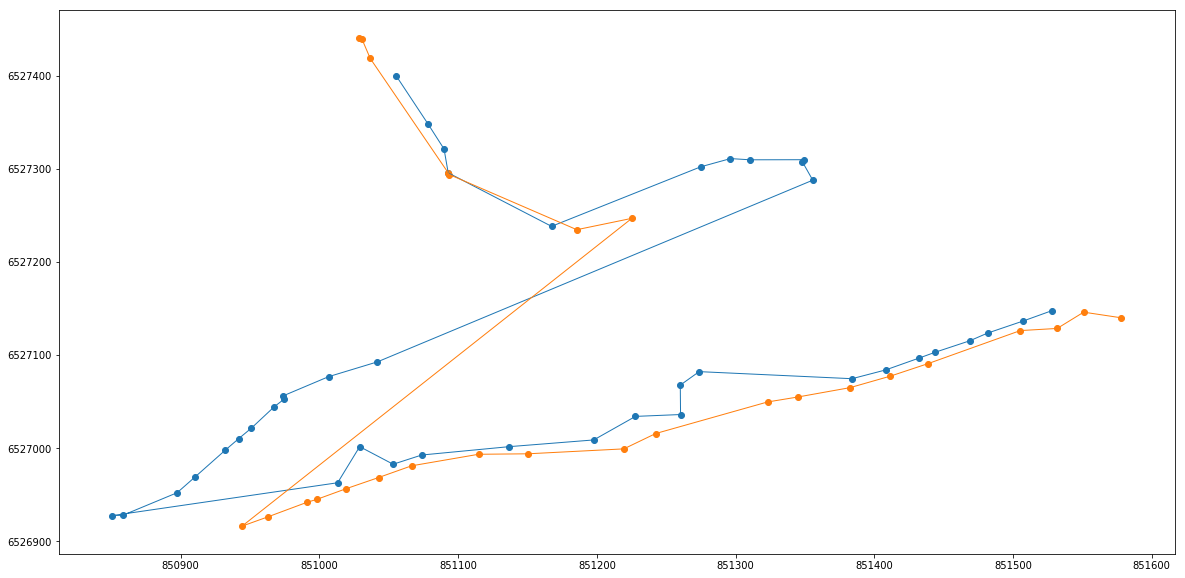

383.0713483098894 18.789346620724412


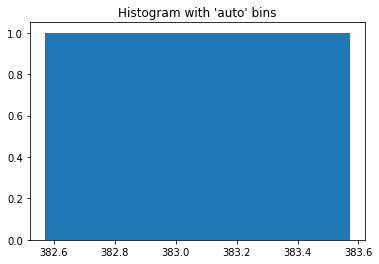

In [24]:
from shapely.geometry import mapping, Point, MultiPoint, MultiLineString, Polygon, LineString
from shapely.ops import nearest_points, linemerge, cascaded_union
from scipy.spatial import distance
import statistics 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from descartes import PolygonPatch
from centerline.main import Centerline
import networkx as nx
import geojson

class OdonymTopology(object):
    def __init__(self,df):
        df = df.sort_values(by=['numero'])
        
        even_df = df.loc[df['numero']%2==0]
        odd_df = df.loc[df['numero']%2!=0]
        
        even_df = even_df[even_df['numero'] < (even_df['numero'].mean() + 2 * even_df['numero'].std())]
        odd_df = odd_df[odd_df['numero'] < (odd_df['numero'].mean() + 2 * odd_df['numero'].std())]
        
        even_line, even_endings, even_ruledOut = self.createLineFromPoints(even_df)
        odd_line, odd_endings, odd_ruledOut = self.createLineFromPoints(odd_df)
        
        self.display([even_line, odd_line])
        
        self.addPointToTheOtherSide(even_line,odd_line)
        
    def createLineFromPoints(self, line_df):
        line_dict = line_df[['coordinate','numero']].set_index('coordinate').to_dict('index')
        line_endings = [line_df['coordinate'][0]]
        
        #display_line = []
        ruledOut = []
        
        success = False
        while not success:
            line = self.createGraphPathFromCoords(list(line_dict.keys()), line_endings, ruledOut)
            #self.display([line])
            ro = self.splitDiscontinuousPath(line_dict, line)

            if ro is None:
                success = True
            else:
                ruledOut += ro
            print(ro, success)
        return line, [line[0], line[-1]], ruledOut
    
    def addPointToTheOtherSide(self, line, otherLine):
        # take a line and add new point to it. return the points
        linestring = LineString(line)
        matrix = distance.cdist(line, otherLine, 'euclidean')
        direction = []
        width = []
        lines=[]
        
        # switch to a closer line thingy
        for i in range(len(line)-1):
            for j in range(len(otherLine)):
                if matrix[i][j] < 120:
                    x1, y1 = line[i]
                    x2, y2 = line[i+1]
                    x, y = otherLine[j]
                    
                    direction.append((x - x1) * (y2 - y1) -  (y - y1) * (x2 - x1))
                    
                    intersections = LineString([(x1,y1),(x,y)]).intersection(linestring)
                    
                    if type(intersections) == MultiPoint:
                        continue

                    p = Point(x,y)
                    l = LineString([(x1,y1),(x2,y2)])
                    w = l.interpolate(l.project(p)).distance(p)

                    lines+=[[(x1,y1),(x2,y2)],[(x1,y1),(x,y)]]

                    width.append(w)
        #self.display(lines)
        direction = statistics.mean(direction)
        averageWidth = pd.Series(width).quantile(0.25)
        
        print(direction, averageWidth)
        
        # predict position of missing nodes
        # for every missing point in the other line (nothing in the mean + 2* variance de witdh) add point in the direction
        
        
        
        plt.hist(direction, bins='auto')  # arguments are passed to np.histogram
        plt.title("Histogram with 'auto' bins")
        plt.show()
    
    def addElevation(self, linedict, default=False):
        if not default:
            for k in linedict.keys():
                linedict[k]['elevation'] = 0
        return linedict
    

    def splitDiscontinuousNumberPath(self,linedict, line):    
        differences = []
        
        for i in range(len(line)-1):
            u,v = line[i:i+2]
            difference = linedict[v]['numero']-linedict[u]['numero']
            differences.append([u,v,difference])
        
        ddf = pd.DataFrame(differences,columns=['origin','destination','diff'])
        
        def sign(s):
            signs = [1 if x >=0 else -1 for x in s]
            return sum(signs)
            
        ddf['sign'] = ddf['diff'].rolling(3).apply(sign,raw=True) 
        
        #print(ddf)
        ruledout = None
        positive = None
        for index, row in ddf.iterrows():
            if np.isnan(row['sign']):
                continue
            elif positive is None:
                positive = bool(row['sign']>=0)
            elif positive != bool(row['sign']>=0):
                i = index
                while bool(ddf.iloc[i]['diff']>=0) != positive:
                    i -= 1
                #print('we need to break:',i, ddf.iloc[i],linedict[ddf.iloc[i]['origin']],linedict[ddf.iloc[i]['destination']])
                #ruledout.append((ddf.iloc[i]['origin'],ddf.iloc[i]['destination']))
               # positive = bool(row['diff']>=0)
                ruledout = (ddf.iloc[i]['origin'],ddf.iloc[i]['destination'])
                break
        return ruledout
    
    def splitDiscontinuousPath(self, linedict, line, number=True, elevation=False, cutoffLength=False):
        ruledout = []
        
        if number:
            ro = self.splitDiscontinuousNumberPath(linedict, line)
            if ro is not None:
                ruledout.append(ro)
        
        # Check cross lines ! 
        return ruledout if len(ruledout) > 0 else None
            
    def createGraphPathFromCoords(self, coords, endings, ruledout):
        graph = nx.Graph()
        graph.add_nodes_from(coords,ending=False)
    
        #for p in coords:
        #   graph.add_node(p,ending=False)
        for e in endings:
            graph.node[e]['ending'] = True
        points = dict(enumerate(coords))
        
        # create matrix of distance and set diagonal values to infinity
        matrix = distance.cdist(coords, coords, 'euclidean')
        for i in range(len(coords)):
            matrix[i][i]=np.inf
        
        if len(ruledout)>0:
            inv_points = {v: k for k, v in points.items()}
            for u,v in ruledout:
                matrix[inv_points[u]][inv_points[v]]=matrix[inv_points[v]][inv_points[u]]=np.inf
                
        
        # create the line prioritizing the closer nodes
        while not np.isinf(np.min(matrix)):
            u,v = np.unravel_index(np.argmin(matrix, axis=None), matrix.shape)
            if len(graph[points[u]].keys()) < 2 and len(graph[points[v]].keys()) < 2 and not nx.has_path(graph,points[u],points[v]): 
                if (graph.node[points[u]]['ending'] and len(graph[points[u]].keys()) ==1) or (graph.node[points[v]]['ending'] and len(graph[points[v]].keys())==1) :
                    matrix[u][v] = matrix[v][u] = np.inf
                    continue
                graph.add_edge(points[u],points[v],weight=matrix[u][v])
                for i in [u,v]:
                    if len(graph[points[i]].keys()) == 2:
                        for j in range(len(matrix[i])):
                            matrix[i][j] = matrix[j][i] = np.inf

            matrix[u][v] = matrix[v][u] = np.inf

        # get extremities
        u,v = [x[0] for x in sorted(graph.degree, key=lambda x: x[1])[:2]]

        # return path 
        return nx.shortest_path(graph,source=u,target=v)
    
    def display(self, lines, inline=True): 
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111)
        
        for line in lines:
            ax.plot(*np.array(line).T, linewidth=1, solid_capstyle='round')
            ax.scatter([p[0] for p in line], [p[1] for p in line])
        if inline:
            plt.show()
        else:
            savefig( hash(line)+'.pdf', bbox_inches='tight')
        
        
ot = OdonymTopology(street_df)

#from geojson import Point, LineString, Feature, FeatureCollection, dump
#line = geojson.LineString(ot.even_line)
#features = []
#features.append(Feature(geometry=line, properties={"country": "France"}))
#feature_collection = FeatureCollection(features)
#with open('points.geojson','w+') as fp:
#    geojson.dump(feature_collection,fp)





In [43]:
        
def simplify(graph):
    nodes = list(graph.nodes())
    for node in nodes:
        if len(graph[node].keys()) == 2:
            node1 = list(graph[node].keys())[0]
            node2 = list(graph[node].keys())[1]

            if(node1 in graph[node2]):
                continue
                
            graph.add_edge(node1,node2, weight=graph[node][node1]['weight'] + graph[node][node2]['weight'])
            graph.remove_node(node)
    return graph


even_mp = even_df['coordinates'].unary_union
odd_mp = odd_df['coordinates'].unary_union

def createLine(mp,lp):
    if len(mp)==0:
        return lp
    elif lp is None:
        orig = mp.pop(0)
        nearest_geoms = nearest_points(orig, MultiPoint(mp))
        near_idx0 = nearest_geoms[0]
        near_idx1 = nearest_geoms[1]
        mp = [p for p in mp if p!=near_idx1]
        lp = [near_idx0,near_idx1]
        #print('first time',len(lp), len(mp))
        return createLine(mp, lp)
    else:
        nearest_geoms = nearest_points(MultiPoint(lp), MultiPoint(mp))
        near_idx0 = nearest_geoms[0]
        near_idx1 = nearest_geoms[1]
        mp = [p for p in mp if p!=near_idx1]
        if near_idx0 == lp[0]:
            lp.insert(0,near_idx1)
        else:
            lp.append(near_idx1)
        #print('\t',len(lp), len(mp))
        return createLine(mp,lp) 

def getCenterLine(evenl, oddl):
    startEvenl = evenl[0]
    stopEvenl = evenl[-1]
    startOddl = oddl[0]
    stopOddl = oddl[-1]
    print(startEvenl,stopEvenl,startOddl,stopOddl,len(evenl),len(oddl))
    # find one closest and link the others
    if startEvenl.distance(startOddl) < startEvenl.distance(stopOddl):
        line1 = [startOddl,startEvenl]
        line2 = [stopEvenl,stopOddl]
        oddlR = list(reversed(oddl))
        linearRing = evenl+line2+oddlR+line1
        polygon = Polygon([[p.x, p.y] for p in linearRing])
    else:
        line1 = [stopOddl,startEvenl]
        line2 = [stopEvenl,startOddl]
        linearRing = evenl+line2+oddl+line1
        polygon = Polygon([[p.x, p.y] for p in linearRing])
    
    centerlines = Centerline(polygon)
    
    missingLines = []
    for line in centerlines:
        u,v = Point(line.coords[0]),Point(line.coords[-1])
        
        pool = [l.coords[0] for l in centerlines if l != line]+[l.coords[-1] for l in centerlines if l != line]
        nearest_geoms = nearest_points(u, MultiPoint(pool))
        closest_to_u = nearest_geoms[1]
        nearest_geoms = nearest_points(v, MultiPoint(pool))
        closest_to_v = nearest_geoms[1]
        if closest_to_u == closest_to_v:
            # it is an extremity, only to the closest
            if u.distance(closest_to_u) < v.distance(closest_to_u):
                missingLines.append([u,closest_to_u])
            else:
                missingLines.append([v,closest_to_u])
        else:
            missingLines.append([u,closest_to_u])
            missingLines.append([v,closest_to_v])
    
    g = nx.Graph()
    for cl in centerlines:
        for i in range(len(cl.coords)-1):
            u=cl.coords[i]
            v=cl.coords[i+1]
            g.add_node(u)
            g.add_node(v)
            g.add_edge(u,v,weight=Point(u).distance(Point(v)))
    for ml in missingLines:
        u = (ml[0].x, ml[0].y)
        v = (ml[1].x, ml[1].y)
        g.add_node(u)
        g.add_node(v)
        g.add_edge(u,v,weight=Point(u).distance(Point(v)))
    print(nx.info(g))
    g=simplify(g)
    print(nx.info(g))
    apd = dict(nx.all_pairs_dijkstra(g))
    longest = (0, None)
    for n,(dist,path) in apd.items():
        length = max(dist.values())
        n2 = [k for k, v in dist.items() if v == length][0]
    
        print(n,'to',n2,':', length, longest[0])
        if length > longest[0]:
            longest = (length, path[n2])
    
    centerline = LineString(longest[1])
            
    return centerline, polygon
    
evenline = createLine(list(even_mp),None)
oddline = createLine(list(odd_mp),None)
print(evenline, oddline)
#centerline, polygon = getCenterLine(evenline, oddline)
#print(type(centerline))
multi_line = MultiLineString([LineString(evenline), LineString(oddline)])
line_poly = multi_line.convex_hull

IndentationError: expected an indented block (<ipython-input-43-e1b792cf7b7d>, line 5)

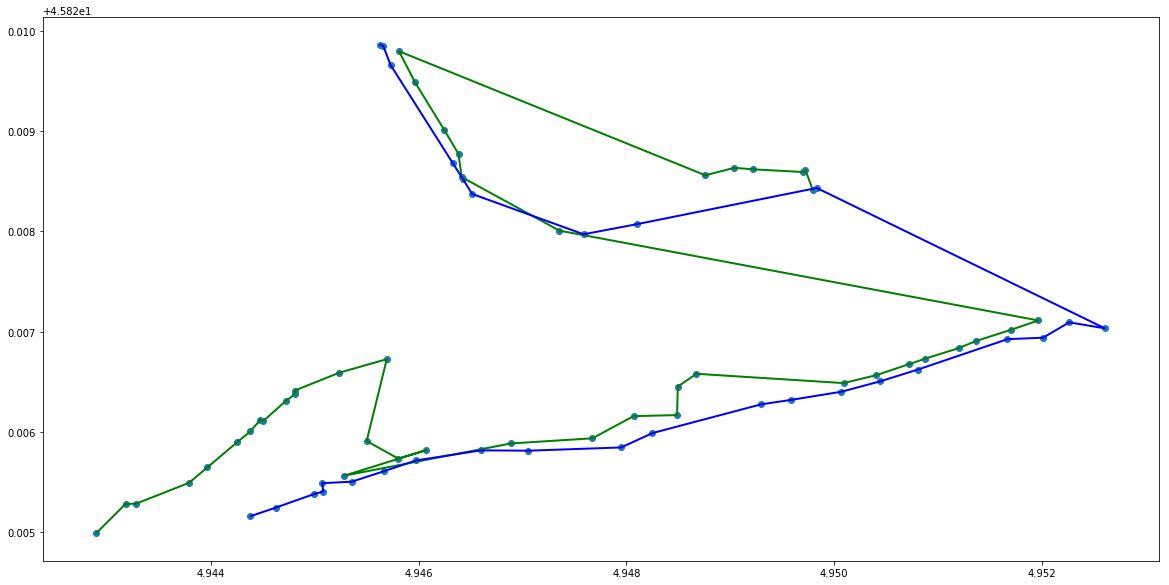

In [11]:

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(*np.array(LineString(evenline)).T, color='green', linewidth=2, solid_capstyle='round')
ax.plot(*np.array(LineString(oddline)).T, color='blue', linewidth=2, solid_capstyle='round')
#ax.plot(*np.array(centerline).T, color='red', linewidth=1, solid_capstyle='round')

ax.scatter([p.x for p in street_df['coordinates'].unary_union], [p.y for p in street_df['coordinates'].unary_union])
#patch = PolygonPatch(polygon, fc='#999999', ec='#999999', alpha=0.5, zorder=1)
#ax.add_patch(patch)
plt.show()

In [14]:
import random
import os
import geojson
from mapboxgl.viz import *
from mapboxgl.utils import *

# Create a geojson file export from a Pandas dataframe
#df_to_geojson(street_df.reset_index(), filename='points.geojson',
#              properties=['numero'],
#              lat='lat', lon='lon', precision=10)

# Must be a public token, starting with `pk`
token = 'pk.eyJ1Ijoic2hhbmdkYWVtb24iLCJhIjoiZjJRcmZGayJ9._dYrpwwYABAtlrxIfXUE1A'

# JSON join-data object
#data = geojson.dump(mapping(multi_line))

# Generate data breaks and color stops from colorBrewer
color_breaks = [0,10,100,1000,10000]
color_stops = create_color_stops(color_breaks, colors='YlGnBu')

# Create the viz from the dataframe
viz = LinestringViz('points.geojson',
                access_token=token,
                height='800px',
                center=(4.9, 45.8),
                zoom=11,
                below_layer='waterway-label')
viz.show()

In [33]:
street_df

numero  code_insee nom_ld         x          y  \
nom_commune nom_voie                                                       
Miribel     montée neuve     427        1249    NaN  851219.4  6526999.1   
            montée neuve     194        1249    NaN  851432.5  6527096.8   
            montée neuve     184        1249    NaN  851443.8  6527102.9   
            montée neuve     236        1249    NaN  851408.1  6527083.9   
            montée neuve     115        1249    NaN  851505.2  6527126.2   
            montée neuve     960        1249    NaN  850850.5  6526927.4   
            montée neuve    1646        1249    NaN  851349.6  6527309.8   
            montée neuve    2036        1249    NaN  851078.3  6527348.1   
            montée neuve     340        1249    NaN  851273.7  6527082.1   
            montée neuve     497        1249    NaN  851150.1  6526993.8   
            montée neuve     368        1249    NaN  851260.1  6527067.6   
            montée neuve    1634        1249    NaN  851355.6  6527287.8   
            montée neuve    1959        1249    NaN  851093.7  6527293.8   
            montée neuve    2145        1249    NaN  851030.6  6527439.5   
            montée neuve     217        1249    NaN  851411.4  6527077.2   
            montée neuve    1252        1249    NaN  851041.8  6527092.6   
            montée neuve    1034        1249    NaN  850897.4  6526952.0   
            montée neuve      55        1249    NaN  851550.9  6527146.0   
            montée neuve    9011        1249    NaN  851358.5  6527290.2   
            montée neuve     442        1249    NaN  851227.8  6527034.0   
            montée neuve     715        1249    NaN  850944.2  6526916.1   
            montée neuve     388        1249    NaN  851260.3  6527036.0   
            montée neuve    2070        1249    NaN  851055.4  6527399.7   
            montée neuve    9003        1249    NaN  851085.6  6527311.4   
            montée neuve    9026        1249    NaN  850829.4  6526894.5   
            montée neuve    9032        1249    NaN  850949.0  6527023.2   
            montée neuve     160        1249    NaN  851468.9  6527115.3   
            montée neuve     635        1249    NaN  851019.0  6526956.2   
            montée neuve     661        1249    NaN  850998.0  6526944.8   
            montée neuve    1014        1249    NaN  850858.3  6526927.8   
...                          ...         ...    ...       ...        ...   
            montée neuve      78        1249    NaN  851527.8  6527147.5   
            montée neuve     307        1249    NaN  851323.0  6527049.5   
            montée neuve     549        1249    NaN  851114.7  6526993.3   
            montée neuve     108        1249    NaN  851507.5  6527136.6   
            montée neuve     142        1249    NaN  851481.6  6527123.5   
            montée neuve    1062        1249    NaN  850910.6  6526969.3   
            montée neuve    9024        1249    NaN  851042.5  6527434.0   
            montée neuve    1116        1249    NaN  850941.7  6527010.0   
            montée neuve    1170        1249    NaN  850973.7  6527056.0   
            montée neuve    1829        1249    NaN  851185.5  6527234.6   
            montée neuve    1106        1249    NaN  850932.0  6526997.6   
            montée neuve     575        1249    NaN  851066.4  6526980.9   
            montée neuve     600        1249    NaN  851053.1  6526982.6   
            montée neuve      83        1249    NaN  851531.8  6527128.5   
            montée neuve    1842        1249    NaN  851167.3  6527238.2   
            montée neuve    9001        1249    NaN  851101.1  6527277.2   
            montée neuve    2145        1249    NaN  851028.4  6527440.7   
            montée neuve    1702        1249    NaN  851296.3  6527311.0   
            montée neuve    1152        1249    NaN  850967.5  6527044.5   
            montée neuve    9031        1249    NaN  850996.9  6526954.0  

In [93]:
p = Point(0.5,1)
l = LineString([(0,0),(1,0)])
l.interpolate(l.project(p)).distance(p)










1.0